In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
from tqdm.auto import tqdm
import random
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report

import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('train.csv').drop(columns = 'ID')
test = pd.read_csv('test.csv').drop(columns = 'ID')

In [45]:
train.head()

COMPONENT_ARBITRARY  ANONYMOUS_1  YEAR  SAMPLE_TRANSFER_DAY  ANONYMOUS_2  \
0          COMPONENT3         1486  2011                    7          200   
1          COMPONENT2         1350  2021                   51          375   
2          COMPONENT2         2415  2015                    2          200   
3          COMPONENT3         7389  2010                    2          200   
4          COMPONENT3         3954  2015                    4          200   

   AG   AL    B  BA  BE  ...  U25  U20   U14       U6       U4  V  V100  \
0   0    3   93   0   0  ...  NaN  NaN   NaN      NaN      NaN  0   NaN   
1   0    2   19   0   0  ...  2.0  4.0   6.0    216.0   1454.0  0   NaN   
2   0  110    1   1   0  ...  0.0  3.0  39.0  11261.0  41081.0  0   NaN   
3   0    8    3   0   0  ...  NaN  NaN   NaN      NaN      NaN  0   NaN   
4   0    1  157   0   0  ...  NaN  NaN   NaN      NaN      NaN  0   NaN   

     V40   ZN  Y_LABEL  
0  154.0   75        0  
1   44.0  652        0  
2   72.6  412        1  
3  133.3    7        0  
4  133.1  128        0  

[5 rows x 53 columns]

In [31]:
train.columns

Index(['COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'YEAR', 'SAMPLE_TRANSFER_DAY',
       'ANONYMOUS_2', 'AG', 'AL', 'B', 'BA', 'BE', 'CA', 'CD', 'CO', 'CR',
       'CU', 'FH2O', 'FNOX', 'FOPTIMETHGLY', 'FOXID', 'FSO4', 'FTBN', 'FE',
       'FUEL', 'H2O', 'K', 'LI', 'MG', 'MN', 'MO', 'NA', 'NI', 'P', 'PB',
       'PQINDEX', 'S', 'SB', 'SI', 'SN', 'SOOTPERCENTAGE', 'TI', 'U100', 'U75',
       'U50', 'U25', 'U20', 'U14', 'U6', 'U4', 'V', 'V100', 'V40', 'ZN',
       'Y_LABEL'],
      dtype='object')

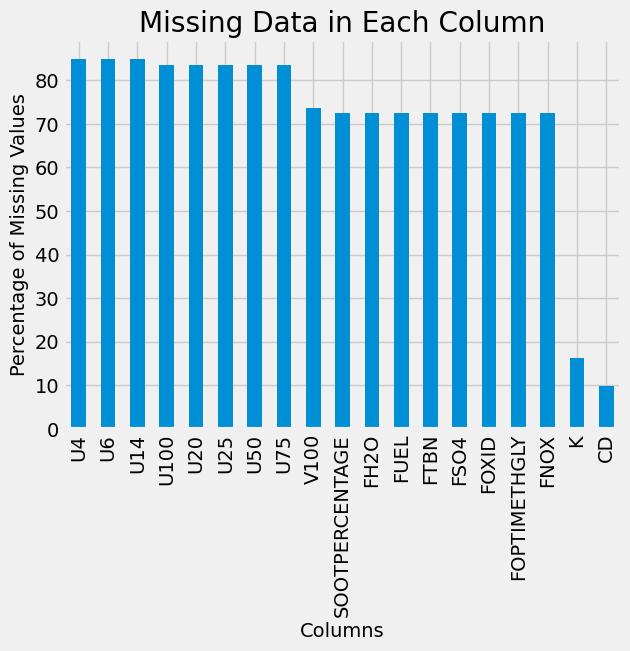

In [32]:
def plot_missing_data(df):
    # 각 컬럼별로 결측치의 비율을 계산
    missing_ratio = df.isnull().mean() * 100
    missing_ratio = missing_ratio[missing_ratio > 0].sort_values(ascending=False)
    
    # 비율이 0보다 큰 컬럼만 시각화
    if not missing_ratio.empty:
        missing_ratio.plot.bar()
        plt.ylabel('Percentage of Missing Values')
        plt.xlabel('Columns')
        plt.title('Missing Data in Each Column')
        plt.show()
    else:
        print("No missing data to display")
plot_missing_data(train)

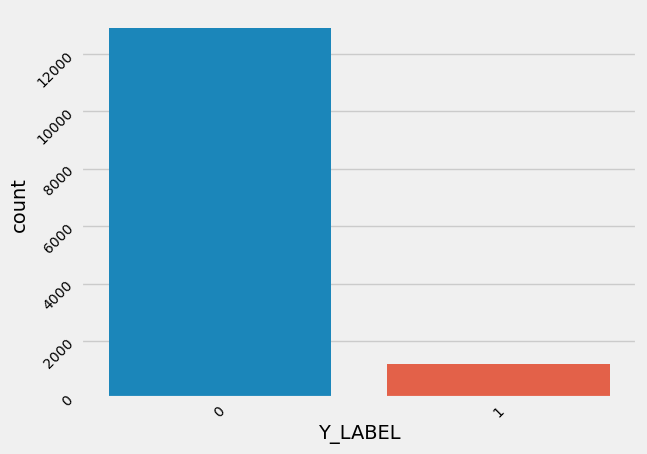

In [33]:
import seaborn as sns
fig,axs=plt.subplots(1,1)
sns.countplot(x='Y_LABEL',data=train)
axs.tick_params(labelsize=10)
axs.tick_params(rotation=45)

# Y_LABEL 9:1 비율 

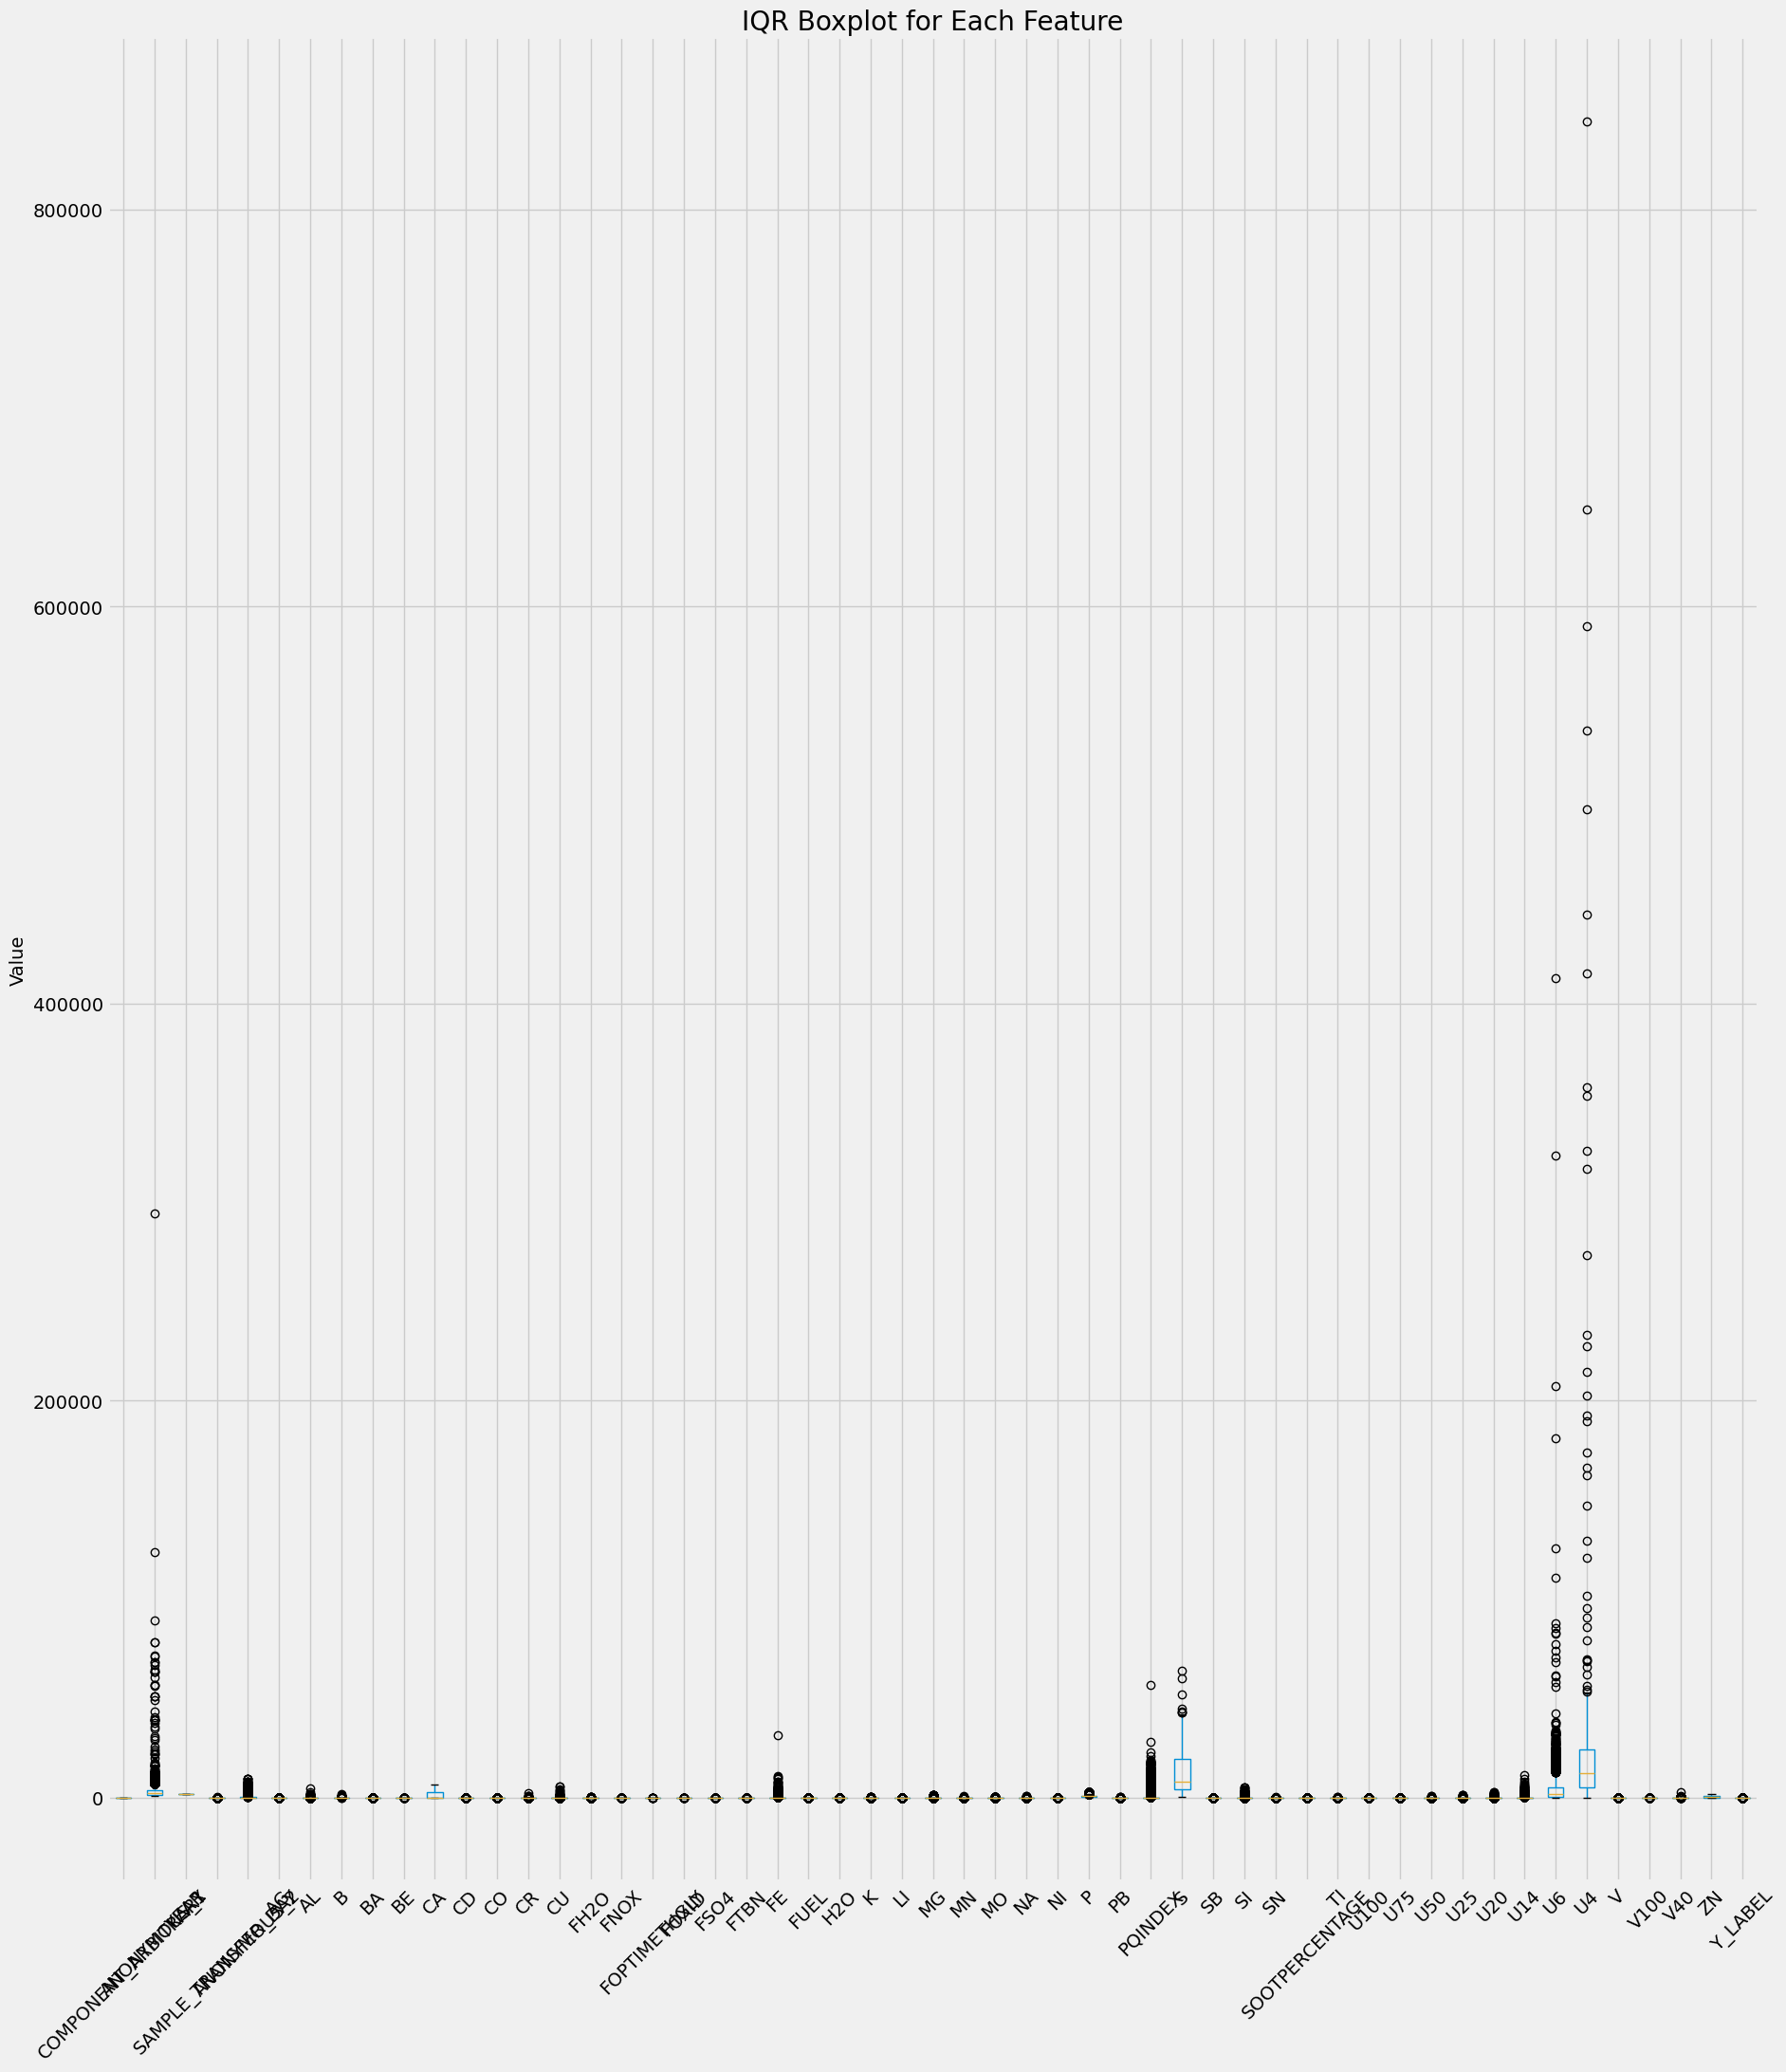

In [59]:
def plot_iqr_boxplot(df):
    plt.figure(figsize=(20, 24))
    df.boxplot()
    plt.xticks(rotation=45)
    plt.title('IQR Boxplot for Each Feature')
    plt.ylabel('Value')
    plt.show()
    
    
plot_iqr_boxplot(train)

In [9]:
le1 = LabelEncoder()

train['COMPONENT_ARBITRARY'] = le1.fit_transform(train['COMPONENT_ARBITRARY'])

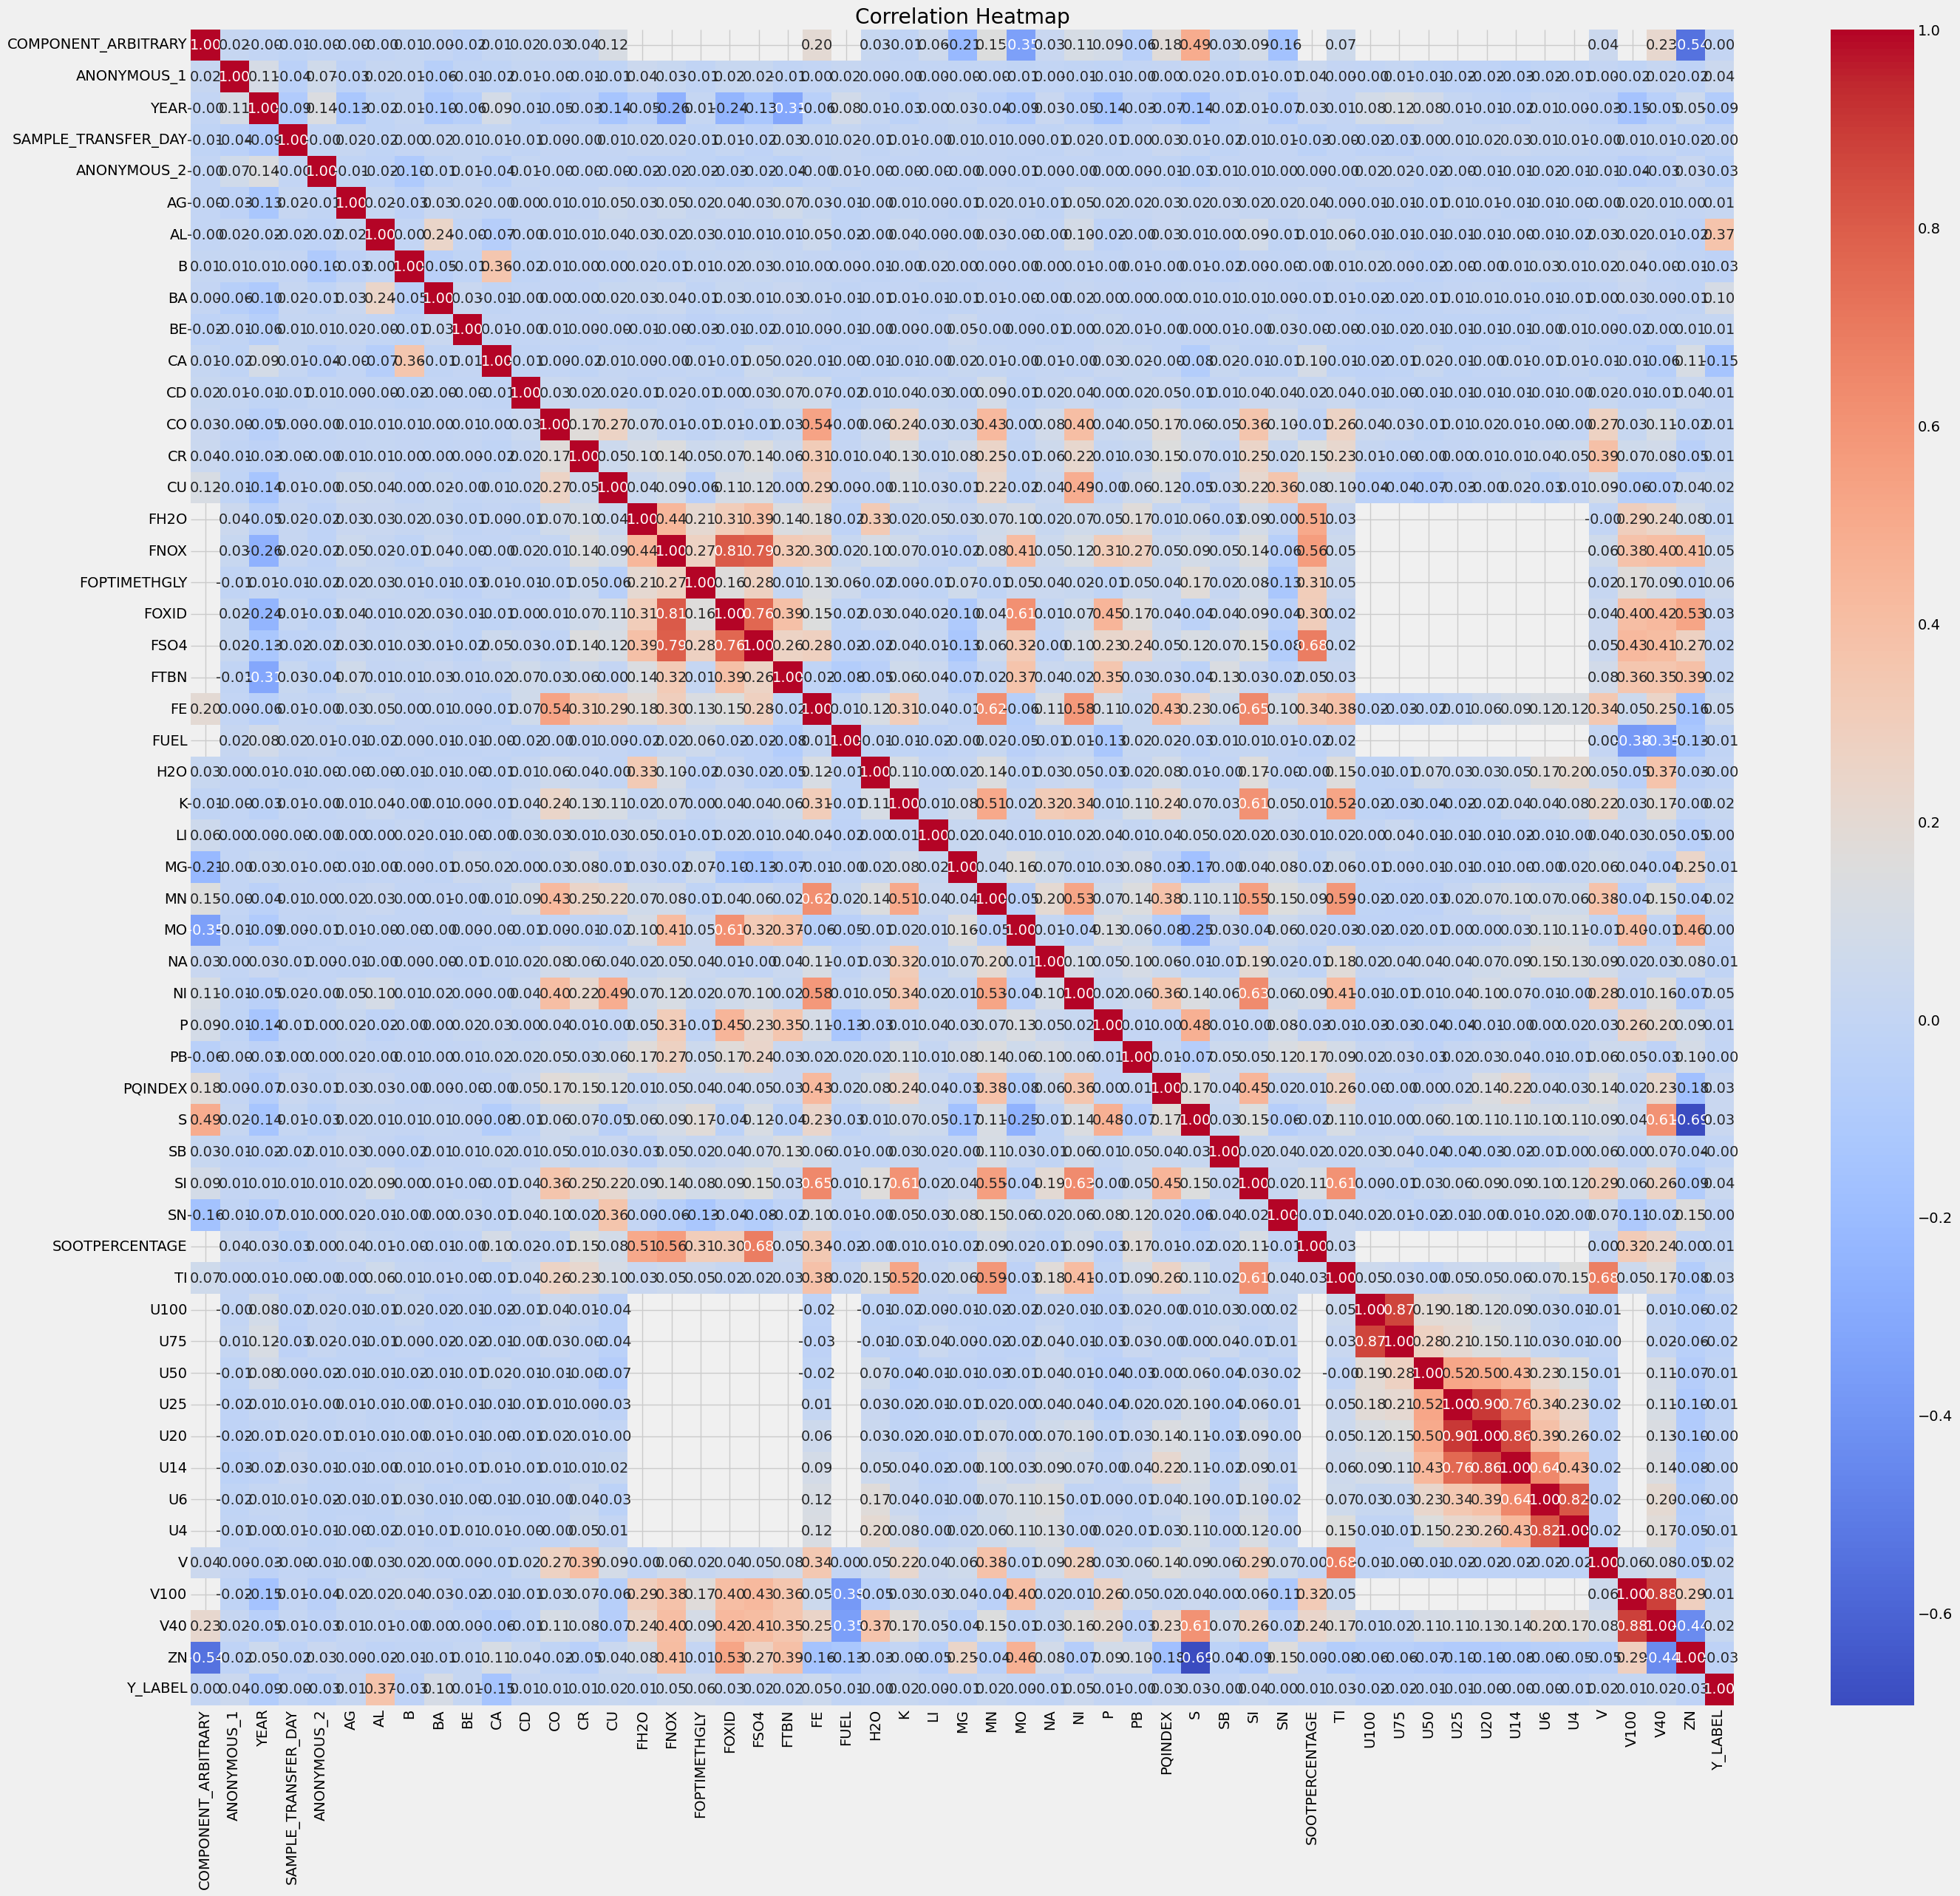

In [58]:
plt.close()
def plot_correlation_heatmap(df):
    # 상관관계 계산
    correlation = df.corr()

    # 히트맵 생성
    plt.figure(figsize=(30,28))
    sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap')
    plt.show()
    
plot_correlation_heatmap(train)

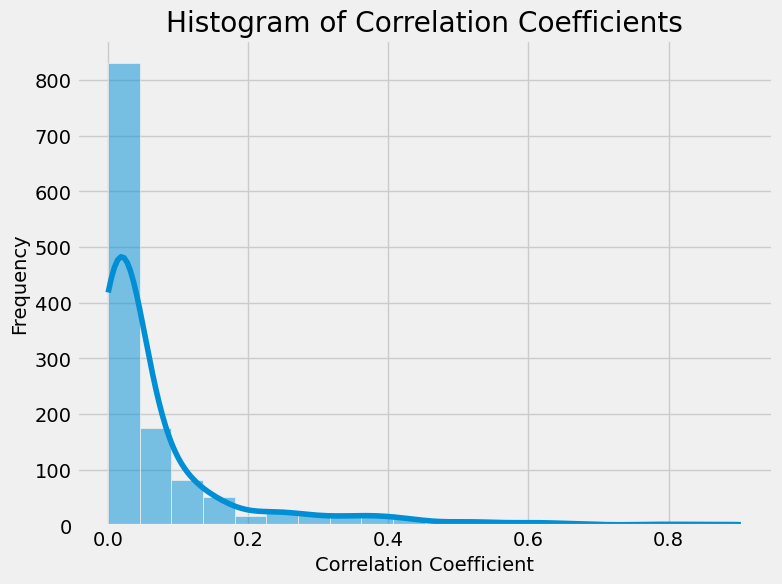

In [51]:
def plot_correlation_coefficients_histogram(df):
    # 상관관계 계산
    corr_matrix = df.corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # 상관관계 계수 추출
    corr_values = upper_tri.stack().tolist()

    # 히스토그램 그리기
    plt.figure(figsize=(8, 6))
    sns.histplot(corr_values, bins=20, kde=True)
    plt.title('Histogram of Correlation Coefficients')
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Frequency')
    plt.show()
    
plot_correlation_coefficients_histogram(train)

In [60]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14095 entries, 0 to 14094
Data columns (total 53 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   COMPONENT_ARBITRARY  14095 non-null  int32  
 1   ANONYMOUS_1          14095 non-null  int64  
 2   YEAR                 14095 non-null  int64  
 3   SAMPLE_TRANSFER_DAY  14095 non-null  int64  
 4   ANONYMOUS_2          14095 non-null  int64  
 5   AG                   14095 non-null  int64  
 6   AL                   14095 non-null  int64  
 7   B                    14095 non-null  int64  
 8   BA                   14095 non-null  int64  
 9   BE                   14095 non-null  int64  
 10  CA                   14095 non-null  int64  
 11  CD                   12701 non-null  float64
 12  CO                   14095 non-null  int64  
 13  CR                   14095 non-null  int64  
 14  CU                   14095 non-null  int64  
 15  FH2O                 3890 non-null  

In [10]:
X_train = train.drop('Y_LABEL', axis=1)
y_train = train['Y_LABEL']

In [56]:
y_train

0        0
1        0
2        1
3        0
4        0
        ..
14090    0
14091    0
14092    0
14093    0
14094    0
Name: Y_LABEL, Length: 14095, dtype: int64

In [16]:
# 결측치 처리

# 선형 보간법을 사용하여 결측치 채우기
train = train.interpolate()

print(train.isna().sum())

COMPONENT_ARBITRARY    0
ANONYMOUS_1            0
YEAR                   0
SAMPLE_TRANSFER_DAY    0
ANONYMOUS_2            0
AG                     0
AL                     0
B                      0
BA                     0
BE                     0
CA                     0
CD                     0
CO                     0
CR                     0
CU                     0
FH2O                   9
FNOX                   9
FOPTIMETHGLY           9
FOXID                  9
FSO4                   9
FTBN                   9
FE                     0
FUEL                   9
H2O                    0
K                      0
LI                     0
MG                     0
MN                     0
MO                     0
NA                     0
NI                     0
P                      0
PB                     0
PQINDEX                0
S                      0
SB                     0
SI                     0
SN                     0
SOOTPERCENTAGE         9
TI                     0


In [17]:
# 남은 결측치 제거 

# 결측치가 있는 모든 행 제거
train = train.dropna(axis='rows')

In [22]:
X_train = train.drop('Y_LABEL', axis=1)
y_train = train['Y_LABEL']

In [27]:
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier


# 데이터를 학습 및 테스트 세트로 분리
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

smote_enn = SMOTEENN(random_state=42)
X_new, y_new = smote_enn.fit_resample(X_train, y_train)

# 모델 학습
model = RandomForestClassifier(random_state=42)
model.fit(X_new, y_new)

# 모델 평가
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1341
           1       0.67      0.65      0.66       109

    accuracy                           0.95      1450
   macro avg       0.82      0.81      0.82      1450
weighted avg       0.95      0.95      0.95      1450



In [ ]:
from sklearn.metrics import roc_curve, confusion_matrix

fpr1, tpr1, thresholds1 = roc_curve(y1, model1.decision_function(X1))
fpr2, tpr2, thresholds2 = roc_curve(y2, model2.decision_function(X2))

c1 = confusion_matrix(y1, y_pred1, labels=[1, 0])
c2 = confusion_matrix(y2, y_pred2, labels=[1, 0])
r1 = c1[0, 0] / (c1[0, 0] + c1[0, 1])
r2 = c2[0, 0] / (c2[0, 0] + c2[0, 1])
f1 = c1[1, 0] / (c1[1, 0] + c1[1, 1])
f2 = c2[1, 0] / (c2[1, 0] + c2[1, 1])

plt.plot(fpr1, tpr1, ':', label="대칭")
plt.plot(fpr2, tpr2, '-', label="비대칭")
plt.plot([f1], [r1], 'ro')
plt.plot([f2], [r2], 'ro')
plt.legend()
plt.xlabel('Fall-Out')
plt.ylabel('Recall')
plt.title('ROC 커브')
plt.show()

In [28]:
train.shape

(14086, 53)

In [29]:
X_train.shape

(3381, 52)

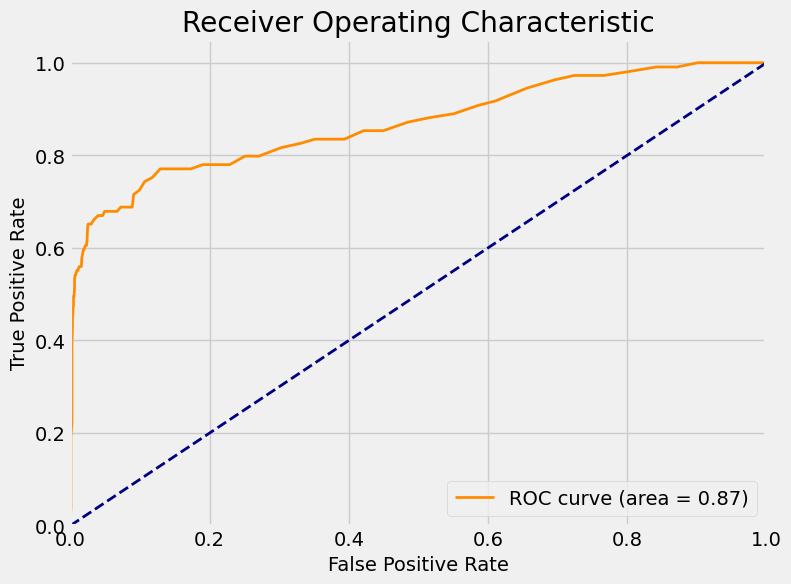

In [31]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 예측 확률 계산
y_scores = model.predict_proba(X_test)[:, 1]

# ROC 곡선 계산
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [32]:
numerical_data = train.select_dtypes(include=['int64', 'float64'])

scaler = RobustScaler()

train = scaler.fit_transform(numerical_data)
train = pd.DataFrame(train, columns=numerical_data.columns)
train.head()

COMPONENT_ARBITRARY  ANONYMOUS_1      YEAR  SAMPLE_TRANSFER_DAY  \
0                 -1.0     2.110644  0.142857                  0.2   
1                 -1.0    -0.125117 -0.857143                  0.0   
2                  0.0    -0.492530  0.571429                  0.0   
3                  0.0     0.396359 -0.142857                  3.4   
4                  0.0     0.582633  0.285714                 -0.4   

   ANONYMOUS_2   AG        AL         B   BA   BE  ...       U25       U20  \
0     0.000000  0.0 -0.333333 -0.093458  0.0  0.0  ... -0.430152 -0.394020   
1     0.000000  0.0 -0.333333 -0.046729  2.0  0.0  ... -0.422852 -0.392060   
2     0.833333  0.0  0.333333 -0.084112  1.0  0.0  ... -0.415553 -0.390100   
3     0.000000  0.0 -0.666667 -0.084112  0.0  0.0  ... -0.408253 -0.388139   
4     0.000000  0.0  1.666667  0.700935  0.0  0.0  ... -0.400953 -0.386179   

        U14        U6        U4    V      V100       V40        ZN  Y_LABEL  
0 -0.332597  0.513186  0.348268  0.0 -0.142857 -0.188838  0.461183      0.0  
1 -0.343453  0.353746  0.150440  0.0 -0.428571 -0.208716  0.600739      0.0  
2 -0.354309  0.194306 -0.047388  0.0 -0.361905  0.956422 -0.477819      0.0  
3 -0.365164  0.034866 -0.245216  0.0 -0.295238  0.332569 -0.455638      0.0  
4 -0.376020 -0.124573 -0.443043  0.0 -0.228571  0.042049  0.523105      0.0  

[5 rows x 53 columns]

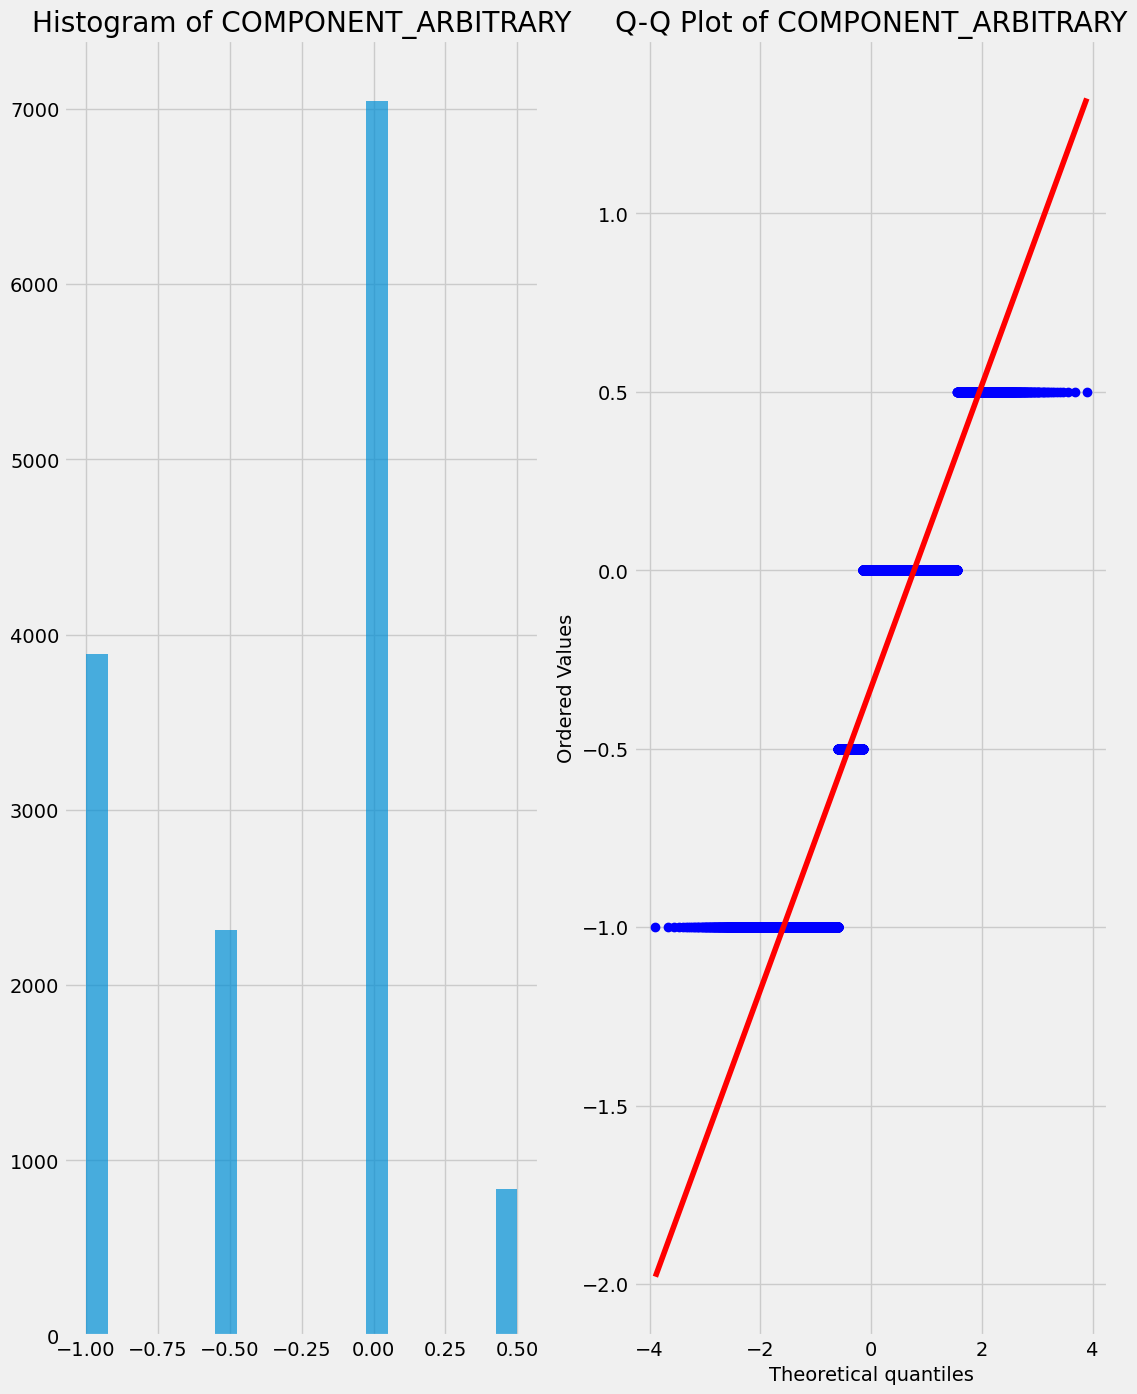

<Figure size 640x480 with 0 Axes>

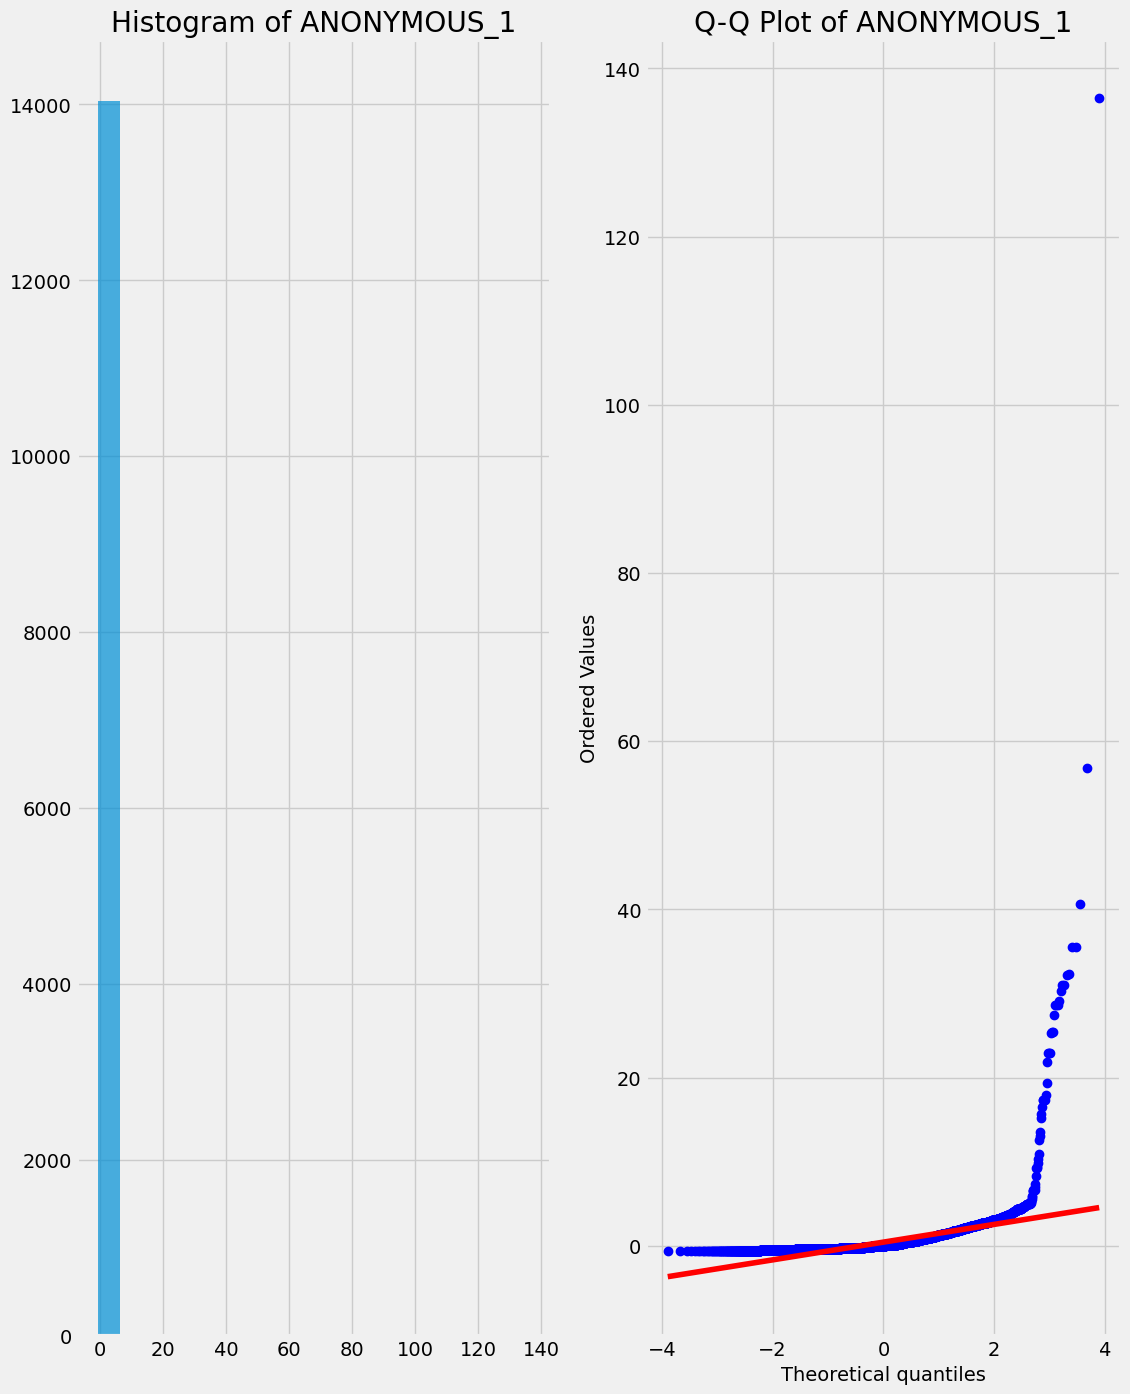

<Figure size 640x480 with 0 Axes>

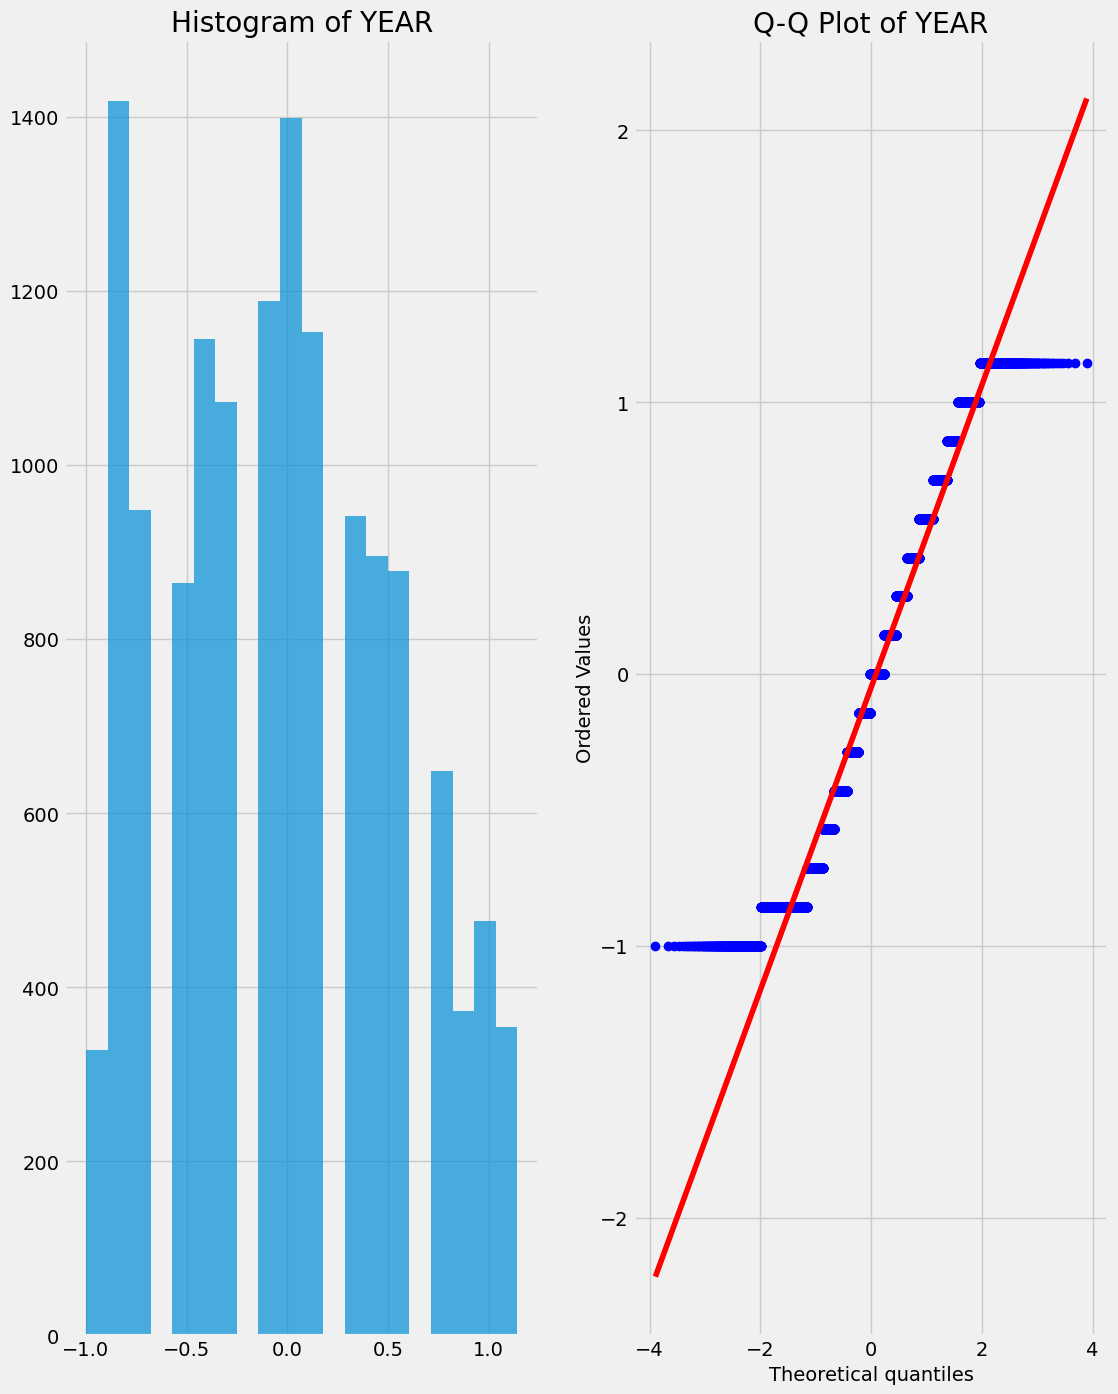

<Figure size 640x480 with 0 Axes>

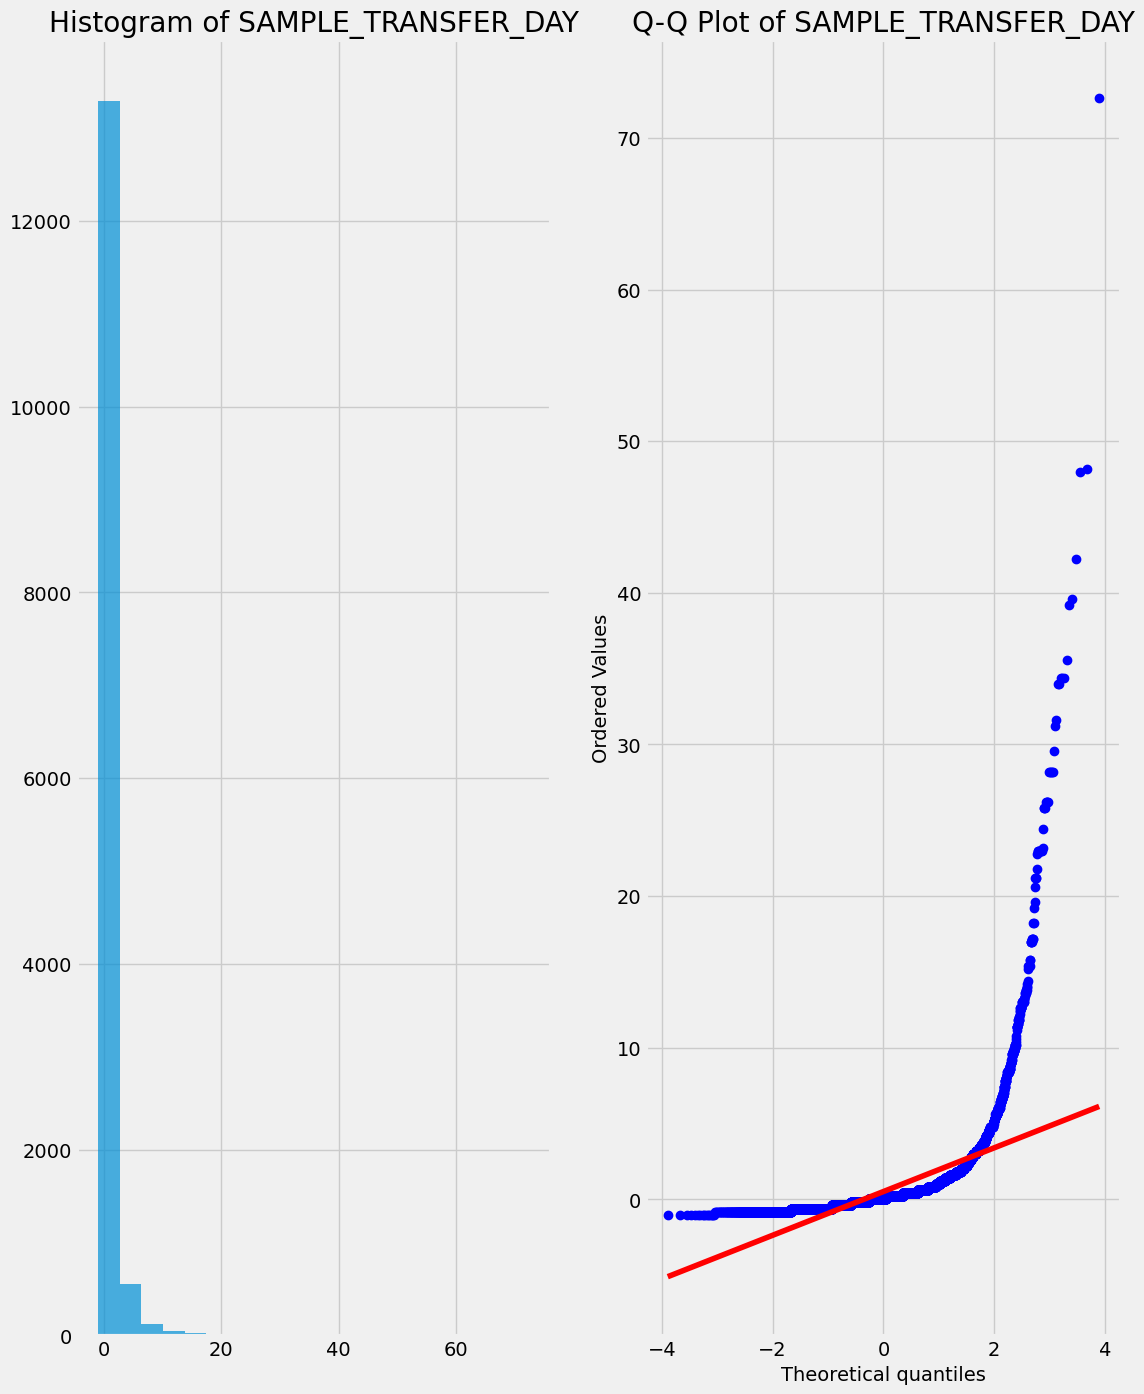

<Figure size 640x480 with 0 Axes>

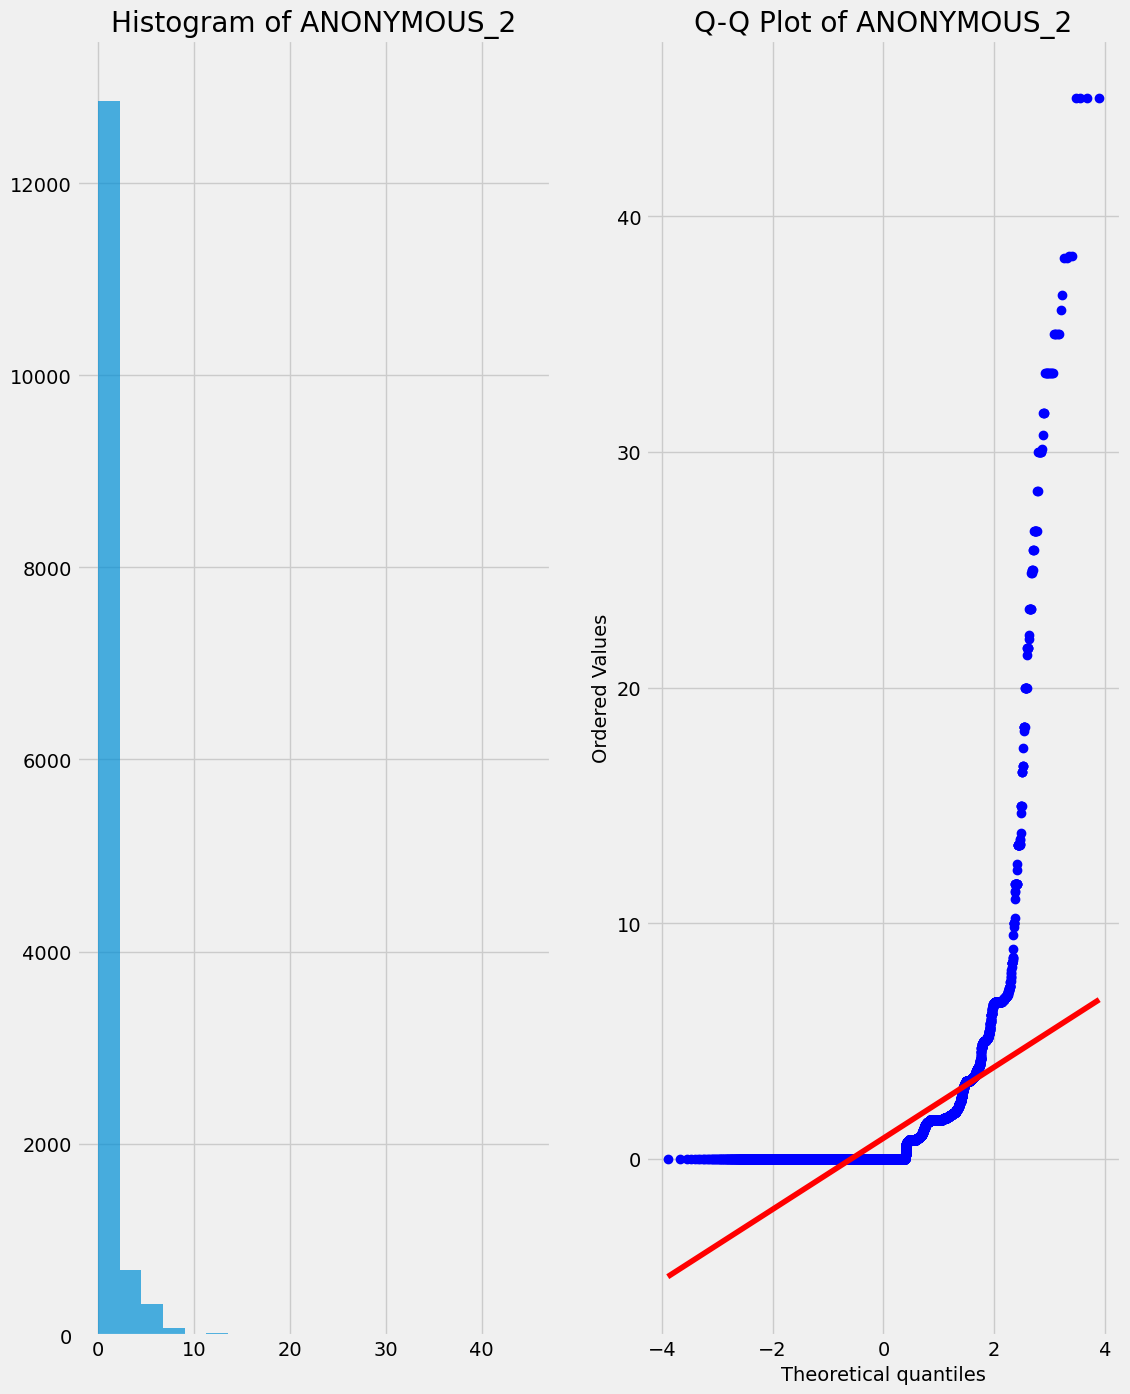

<Figure size 640x480 with 0 Axes>

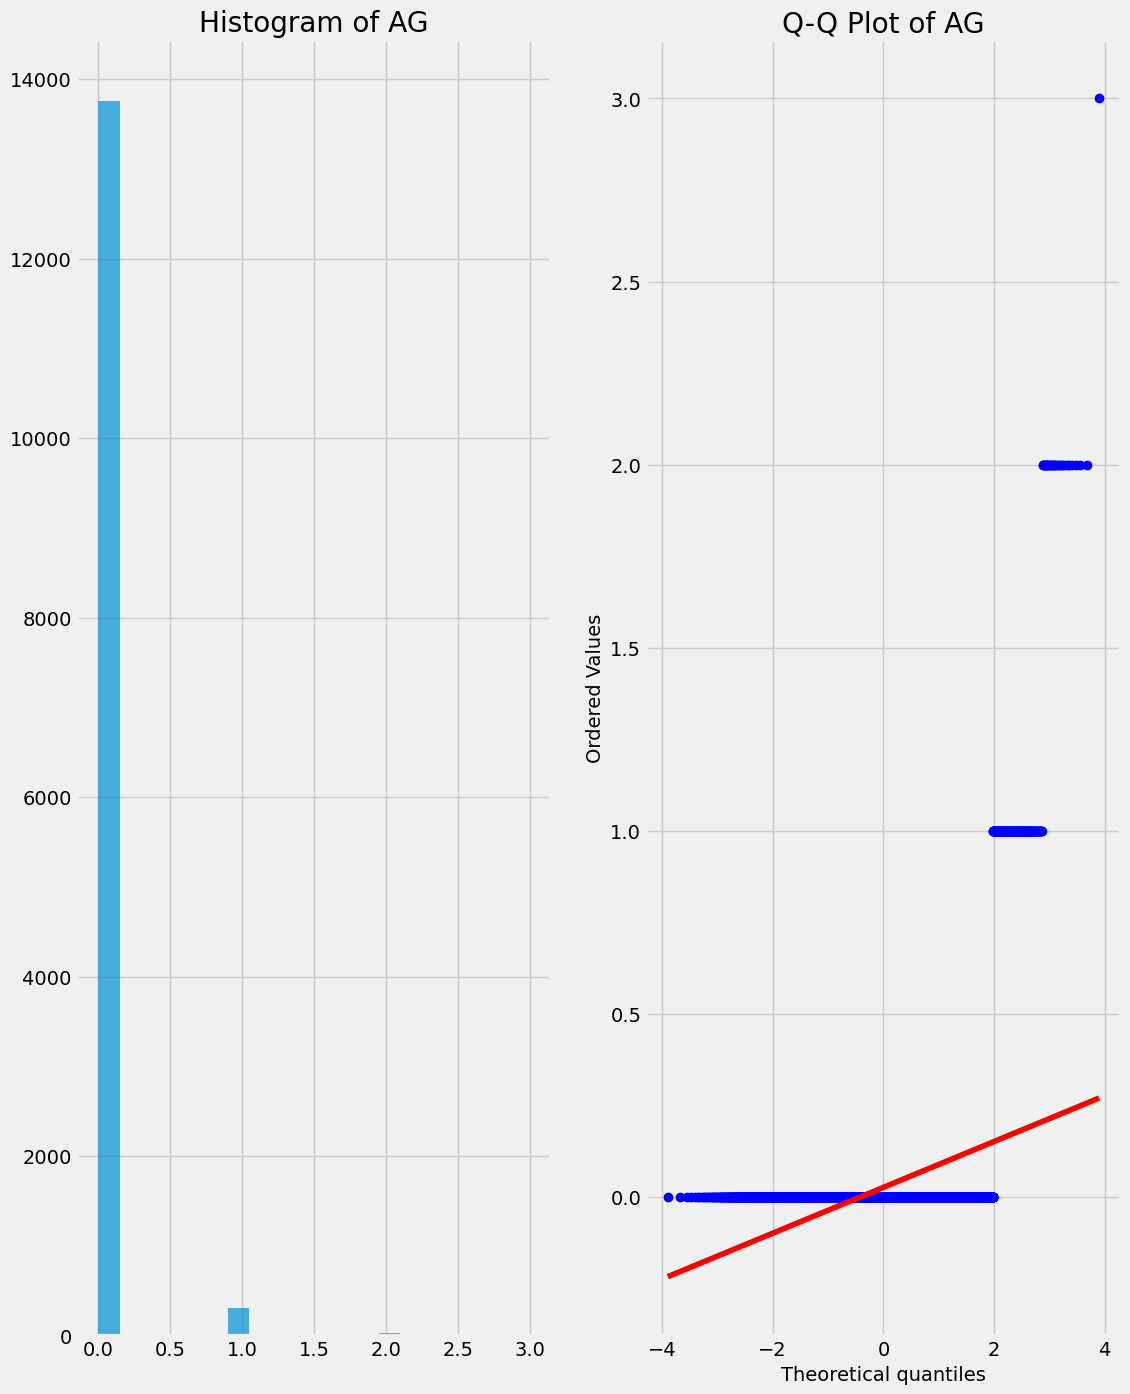

<Figure size 640x480 with 0 Axes>

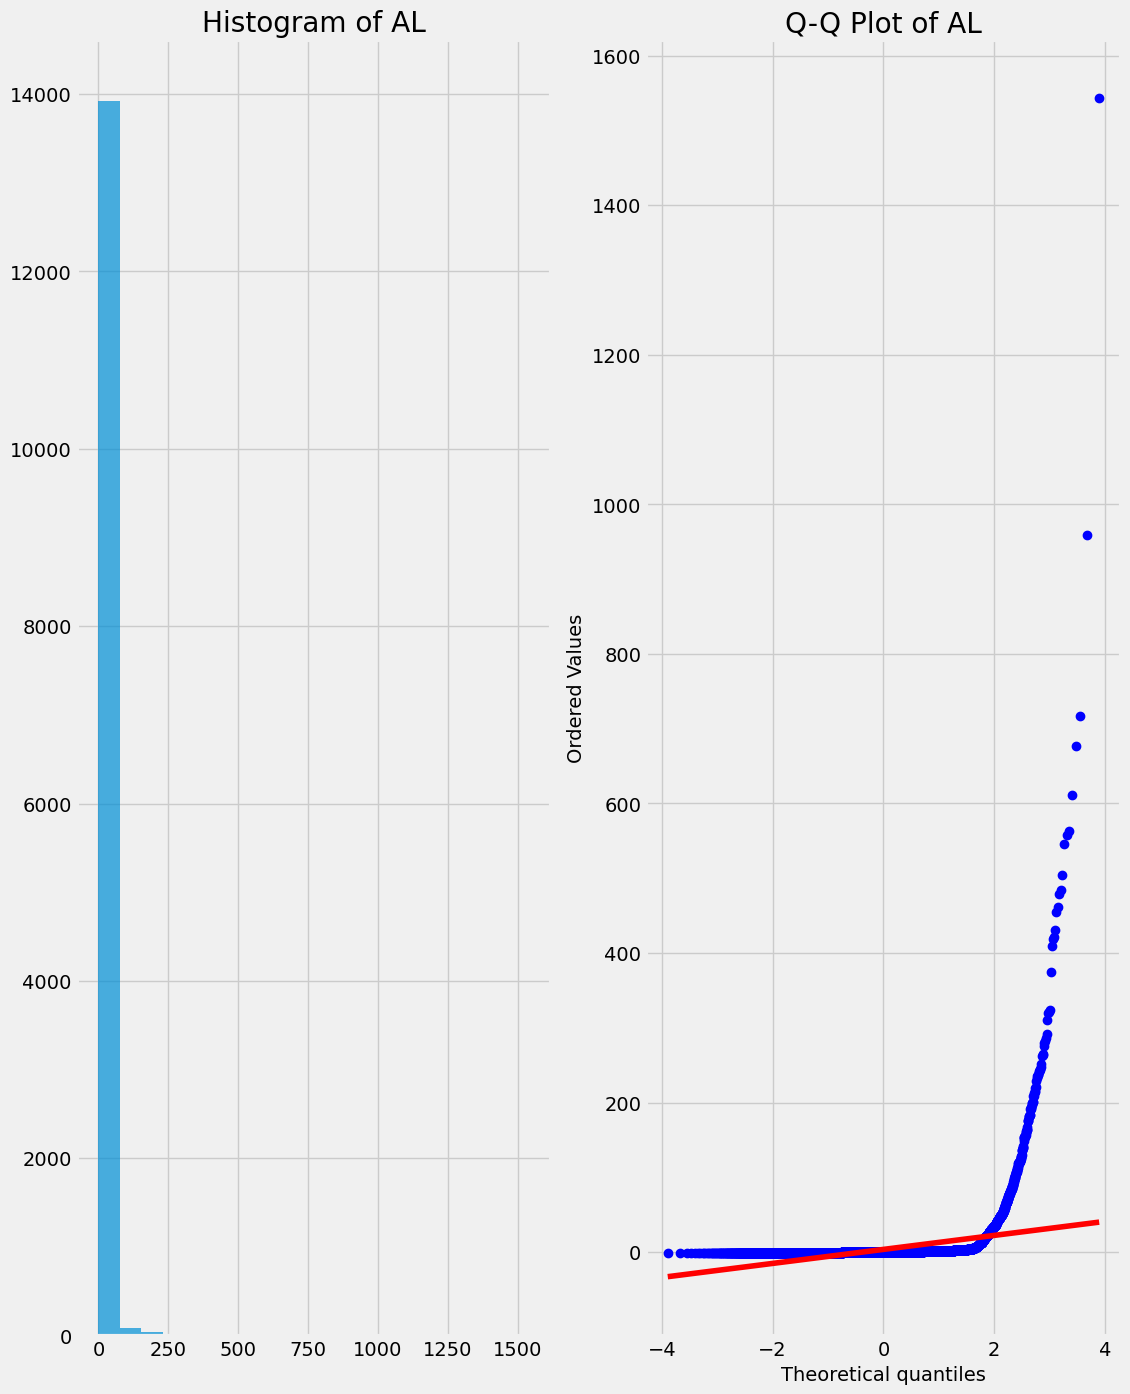

<Figure size 640x480 with 0 Axes>

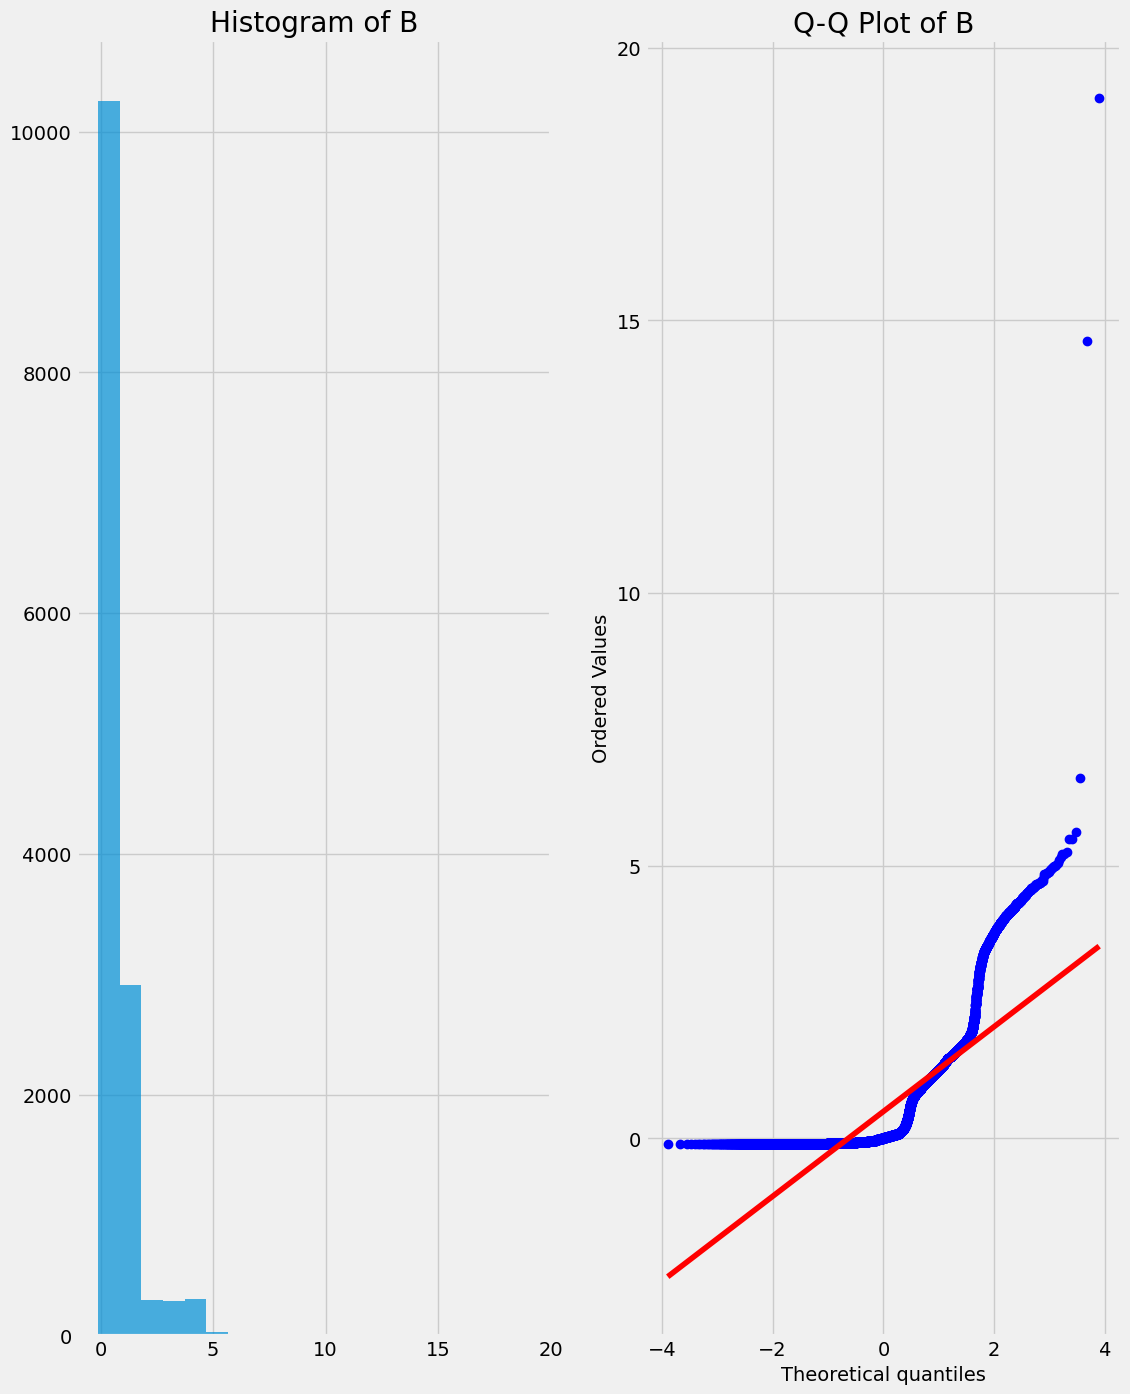

<Figure size 640x480 with 0 Axes>

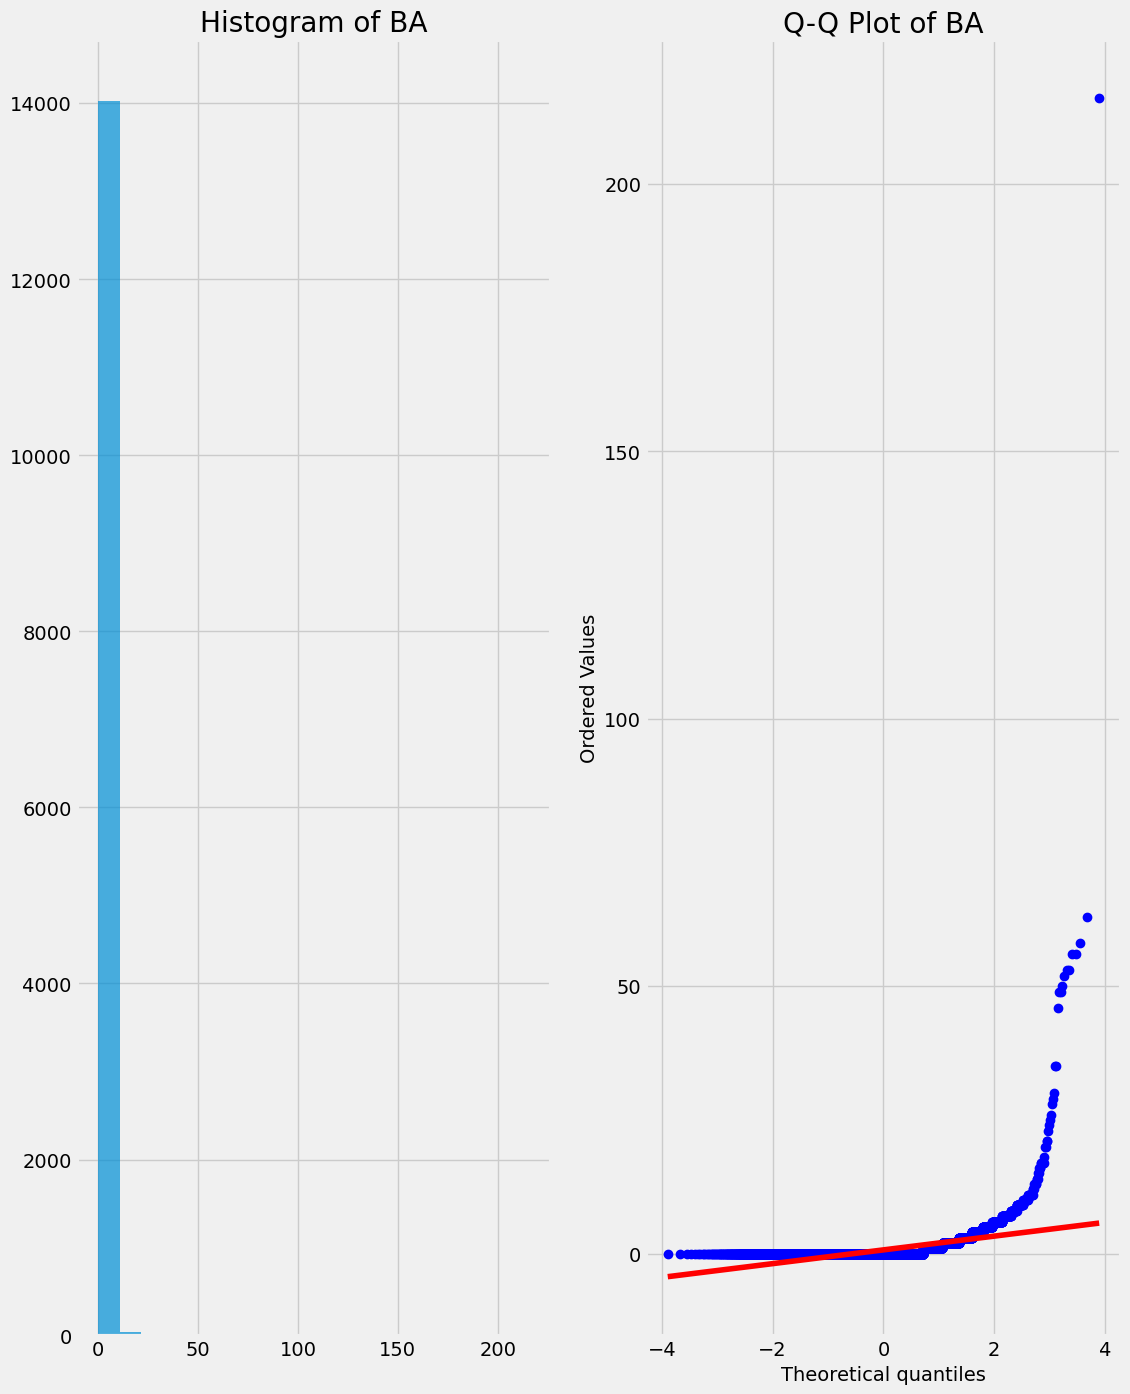

<Figure size 640x480 with 0 Axes>

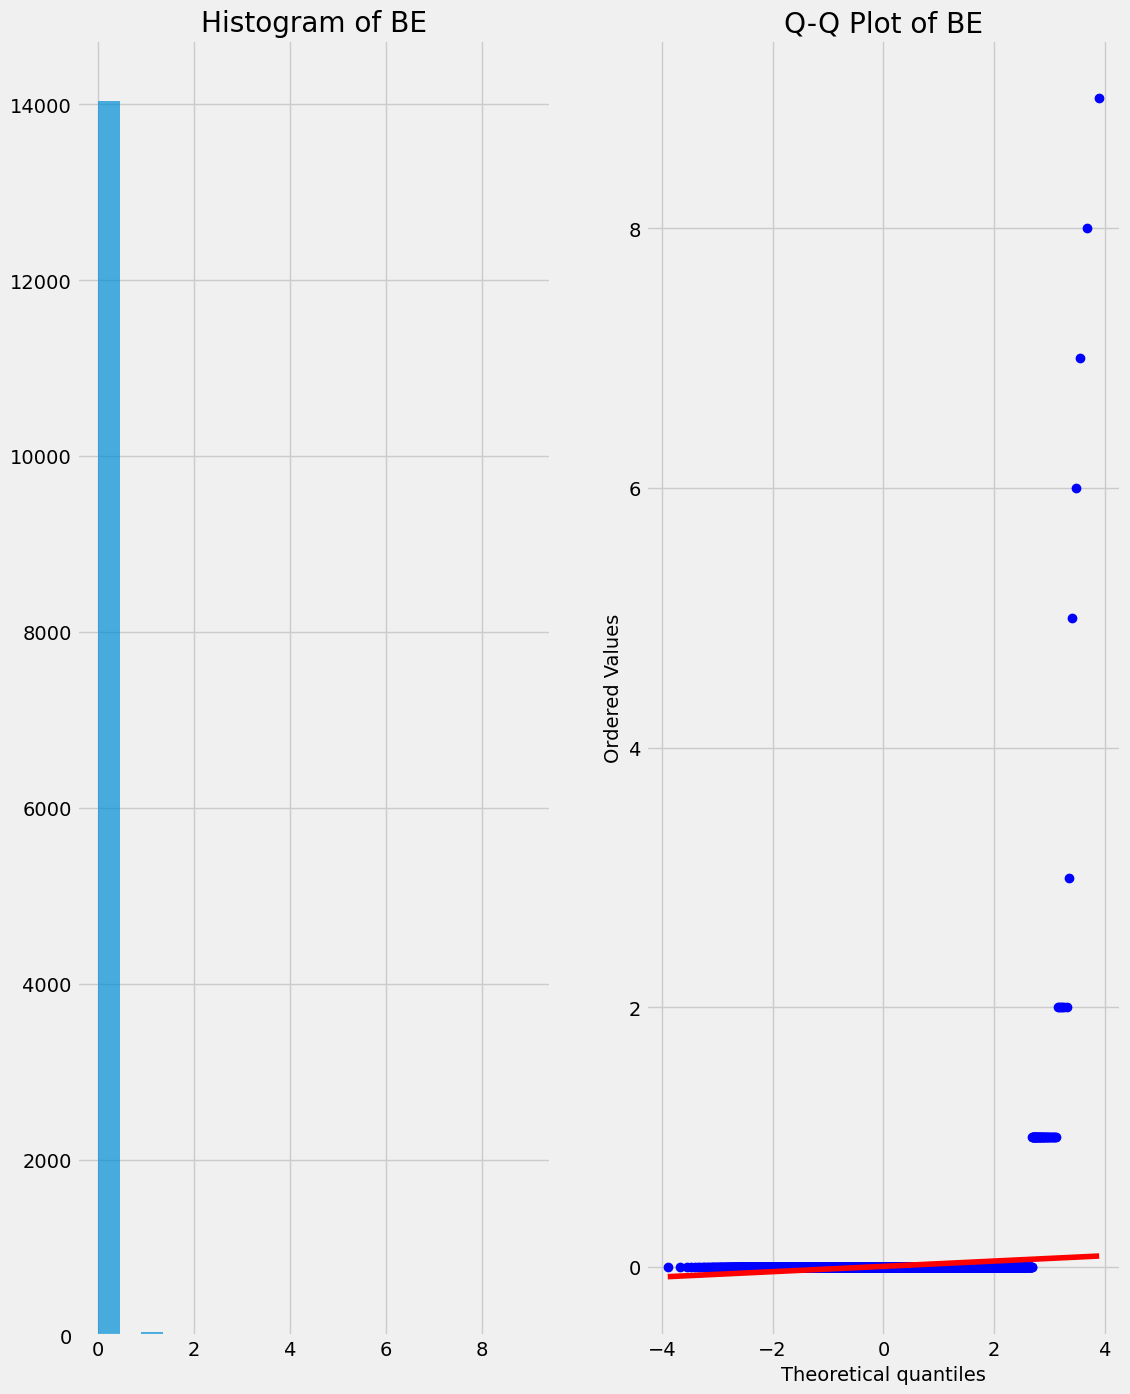

<Figure size 640x480 with 0 Axes>

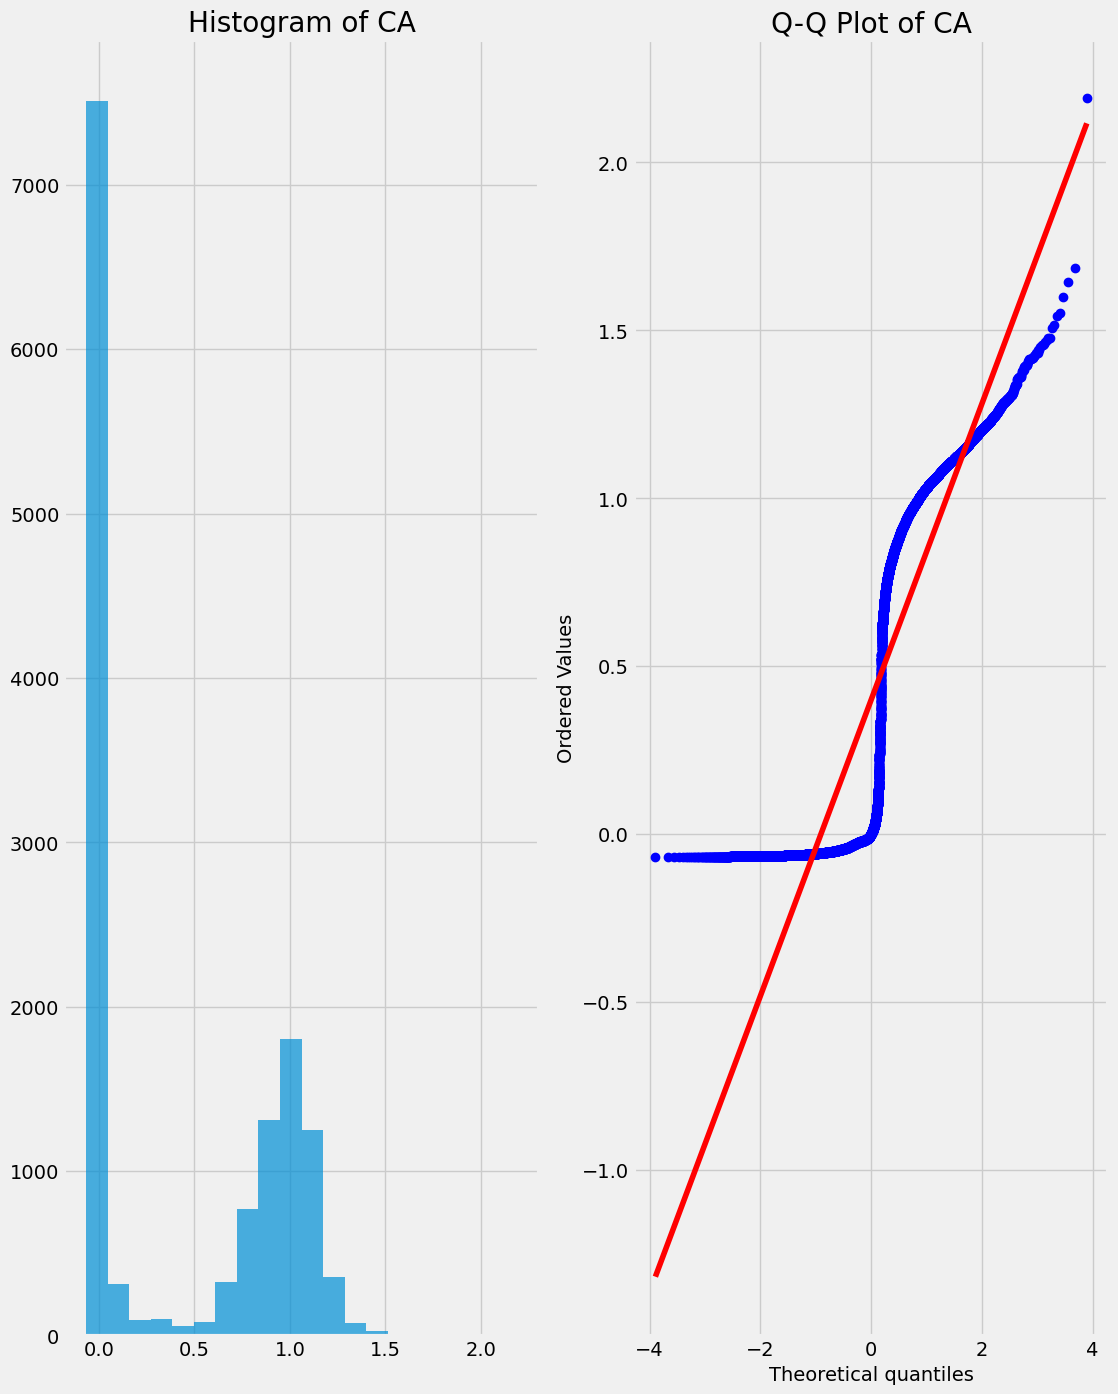

<Figure size 640x480 with 0 Axes>

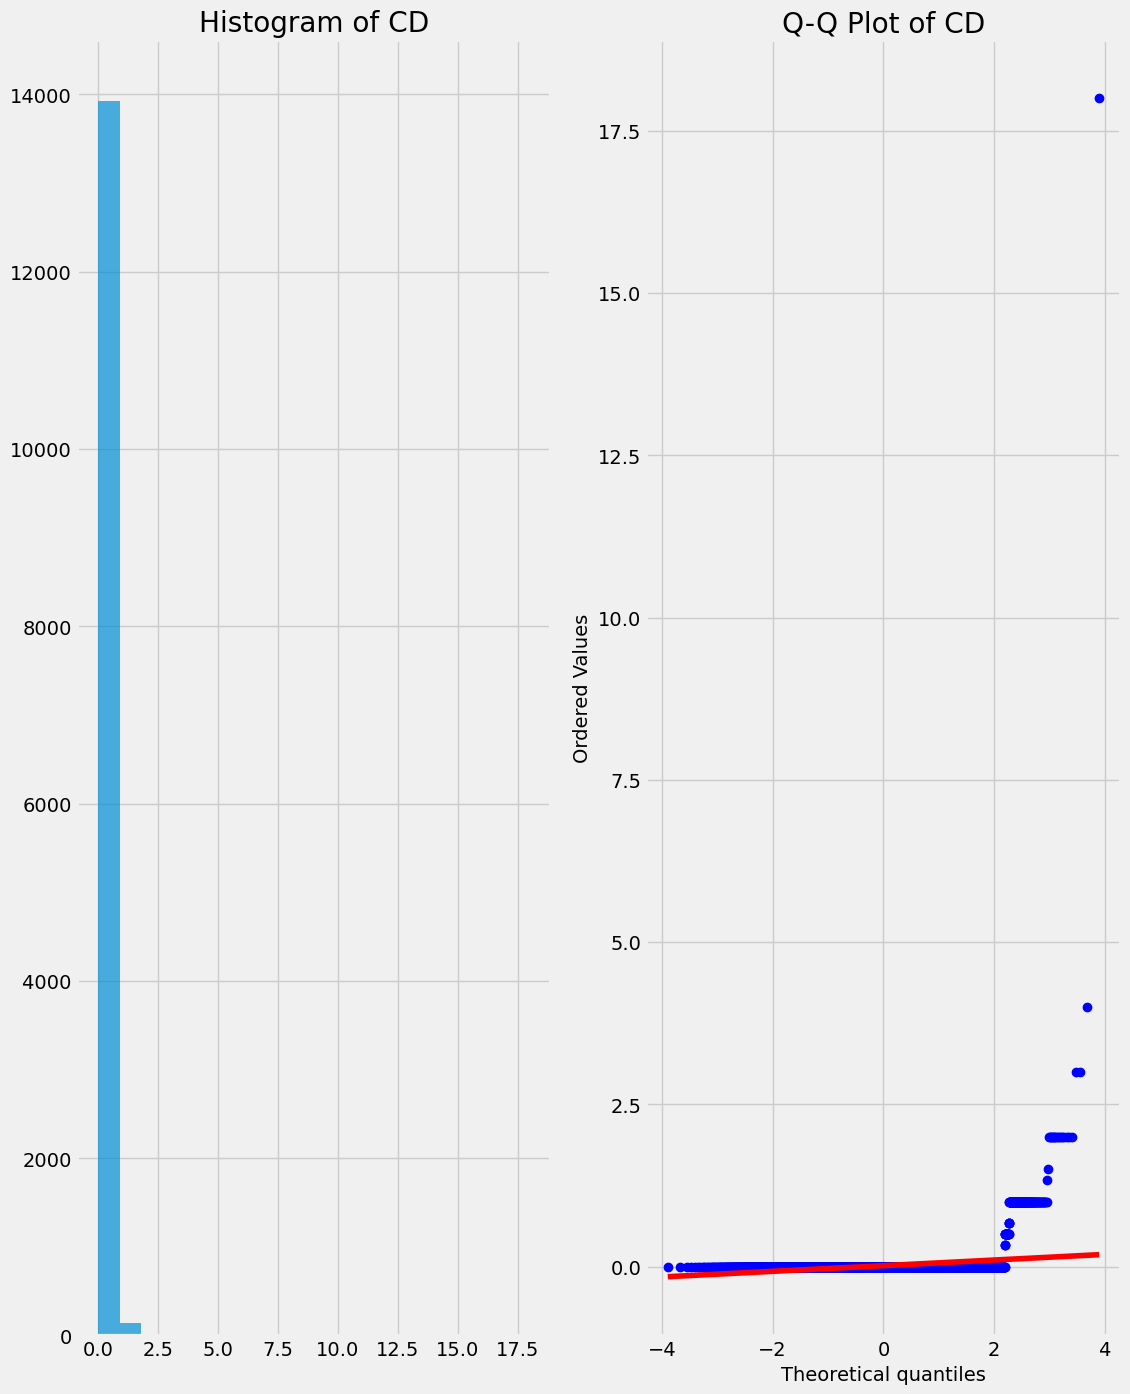

<Figure size 640x480 with 0 Axes>

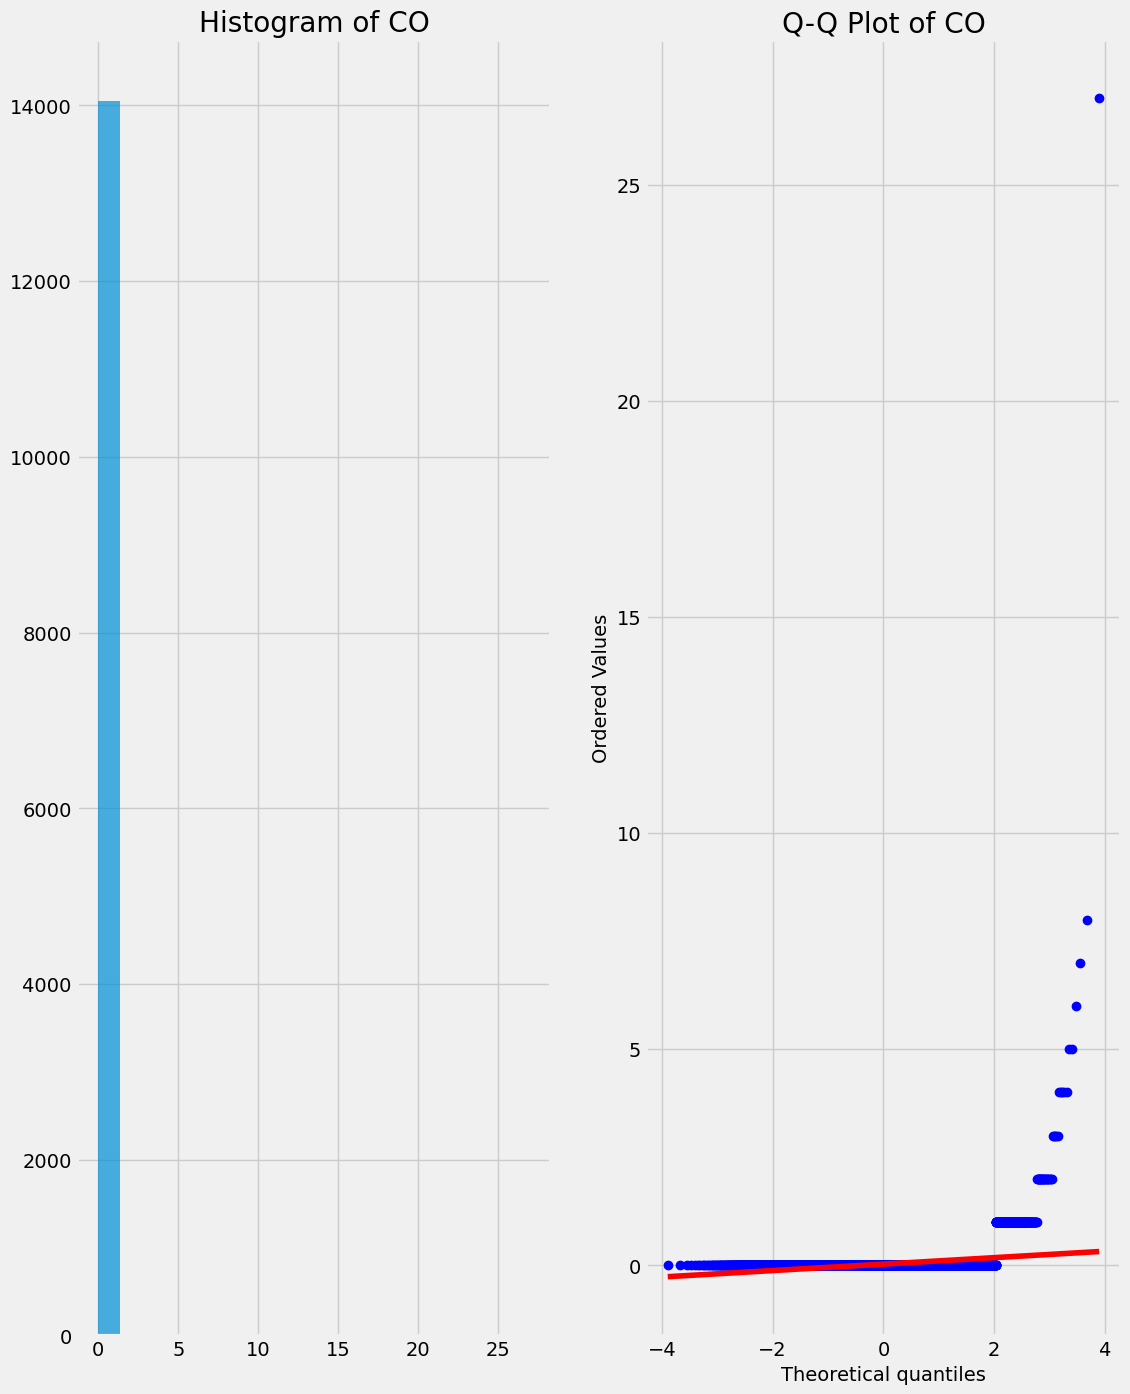

<Figure size 640x480 with 0 Axes>

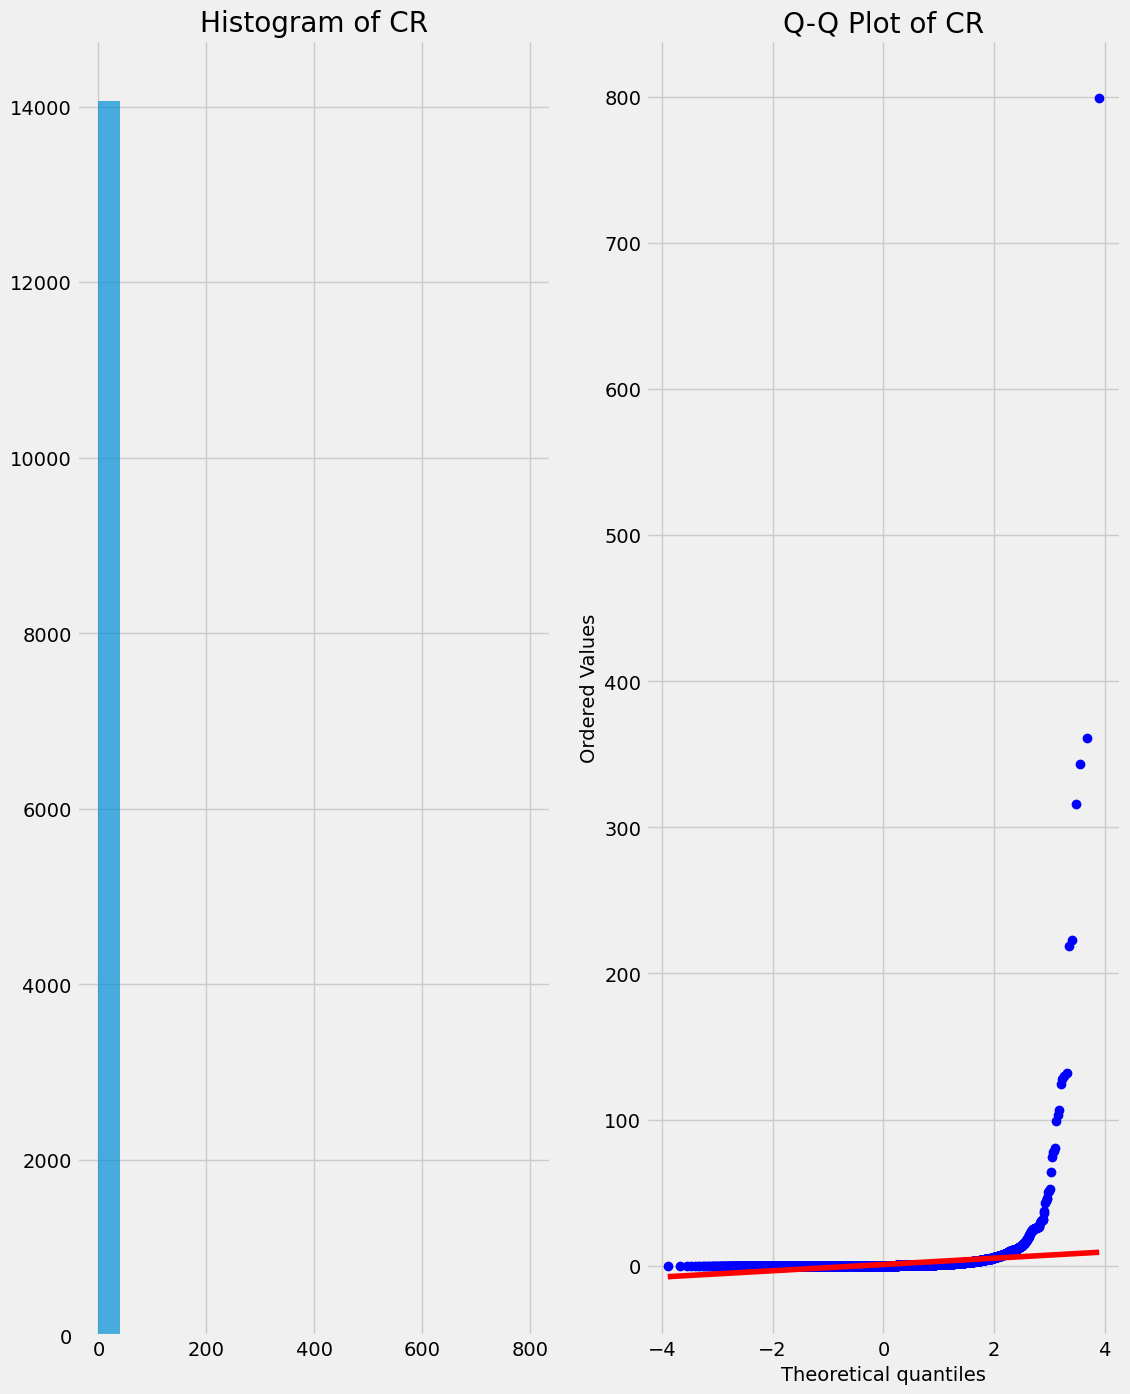

<Figure size 640x480 with 0 Axes>

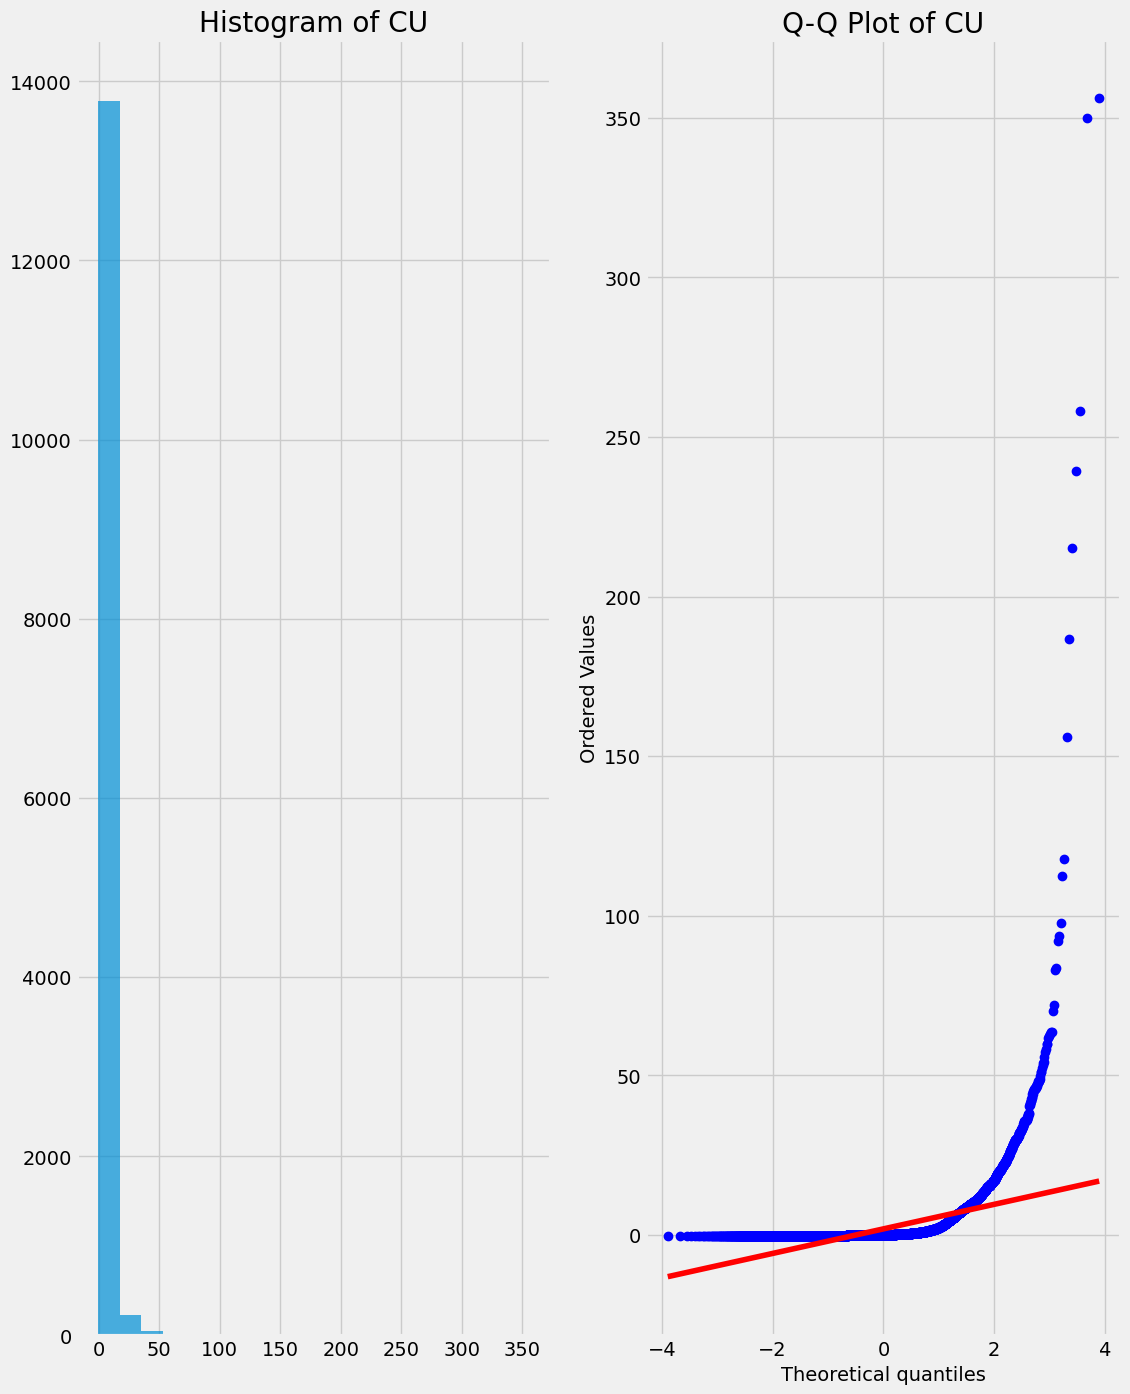

<Figure size 640x480 with 0 Axes>

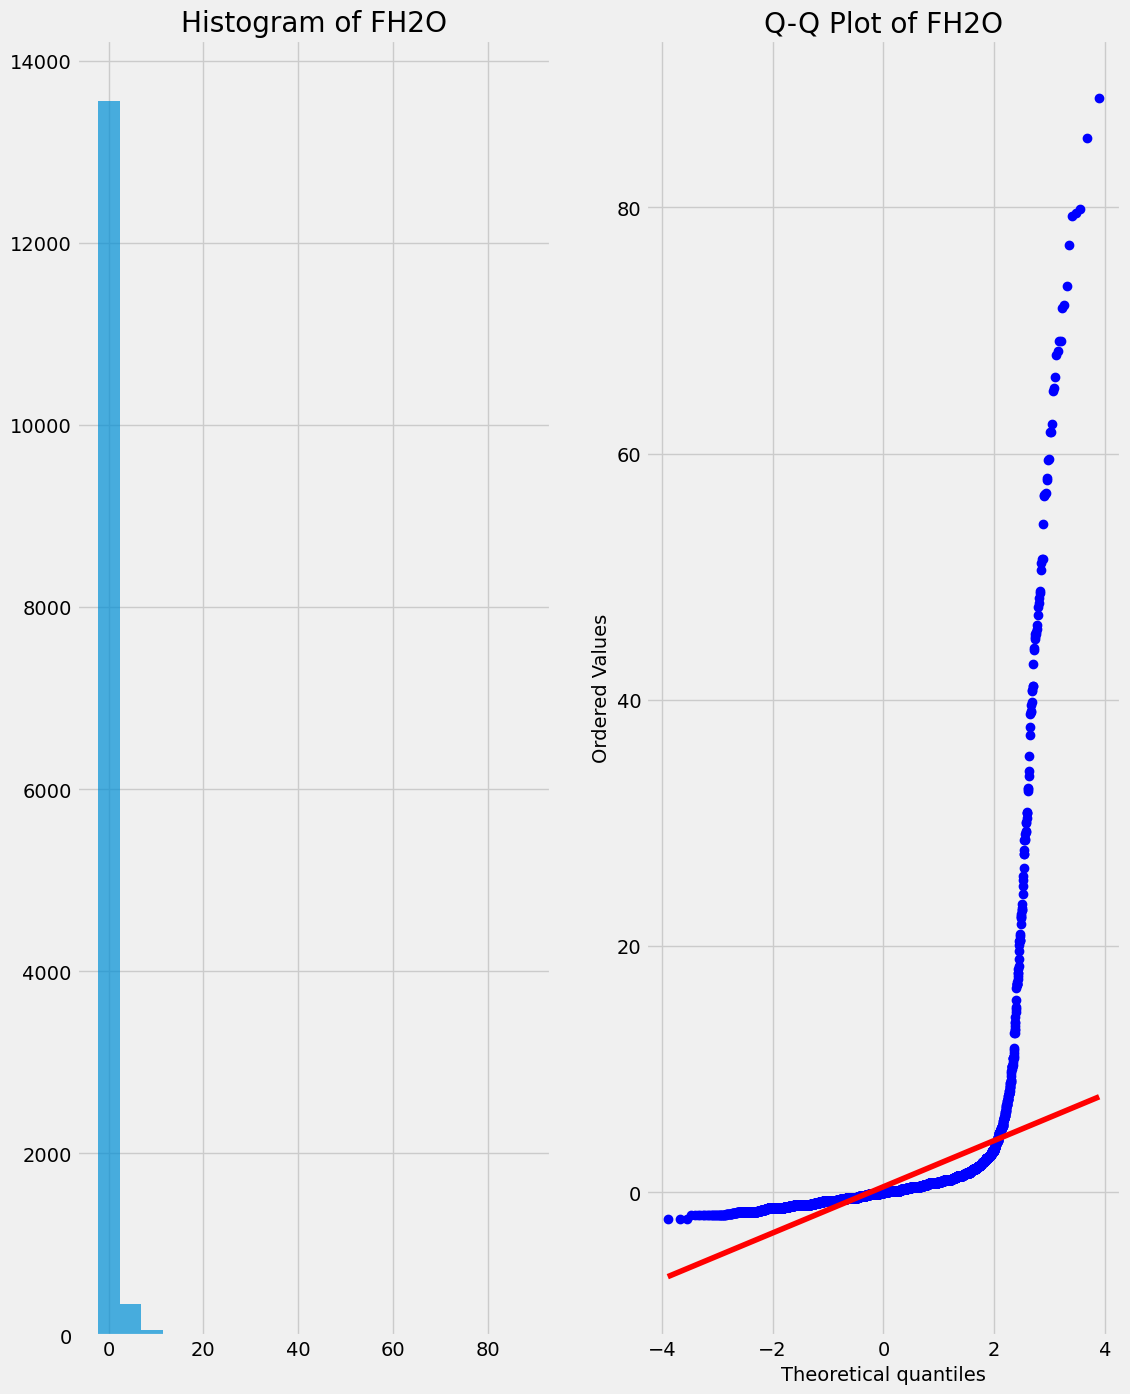

<Figure size 640x480 with 0 Axes>

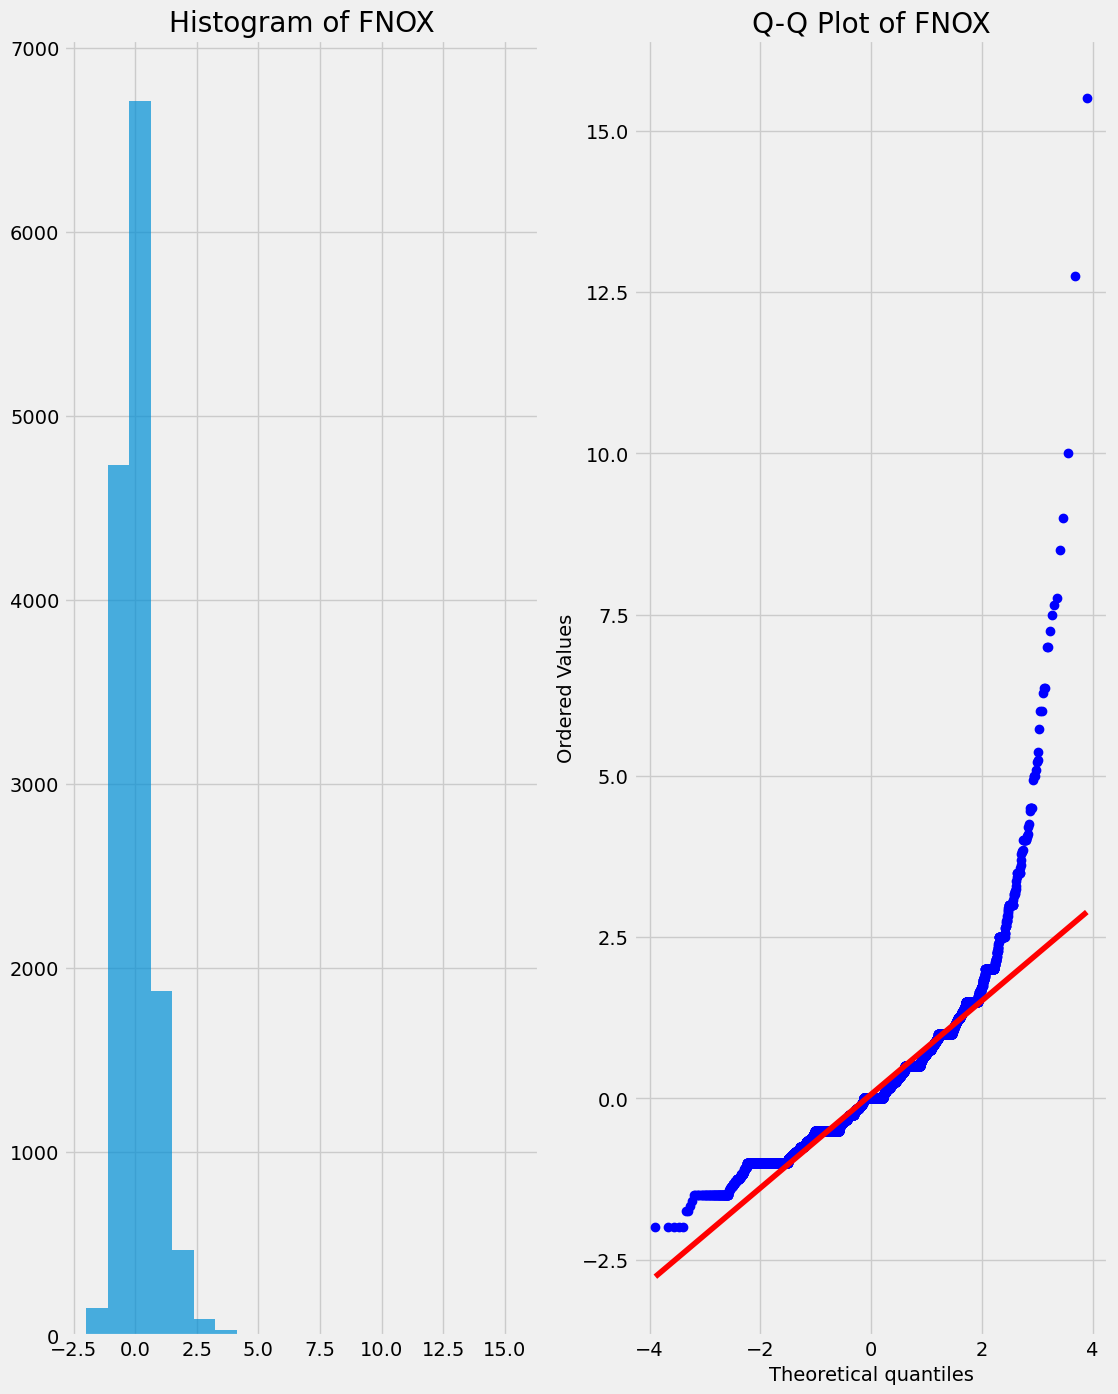

<Figure size 640x480 with 0 Axes>

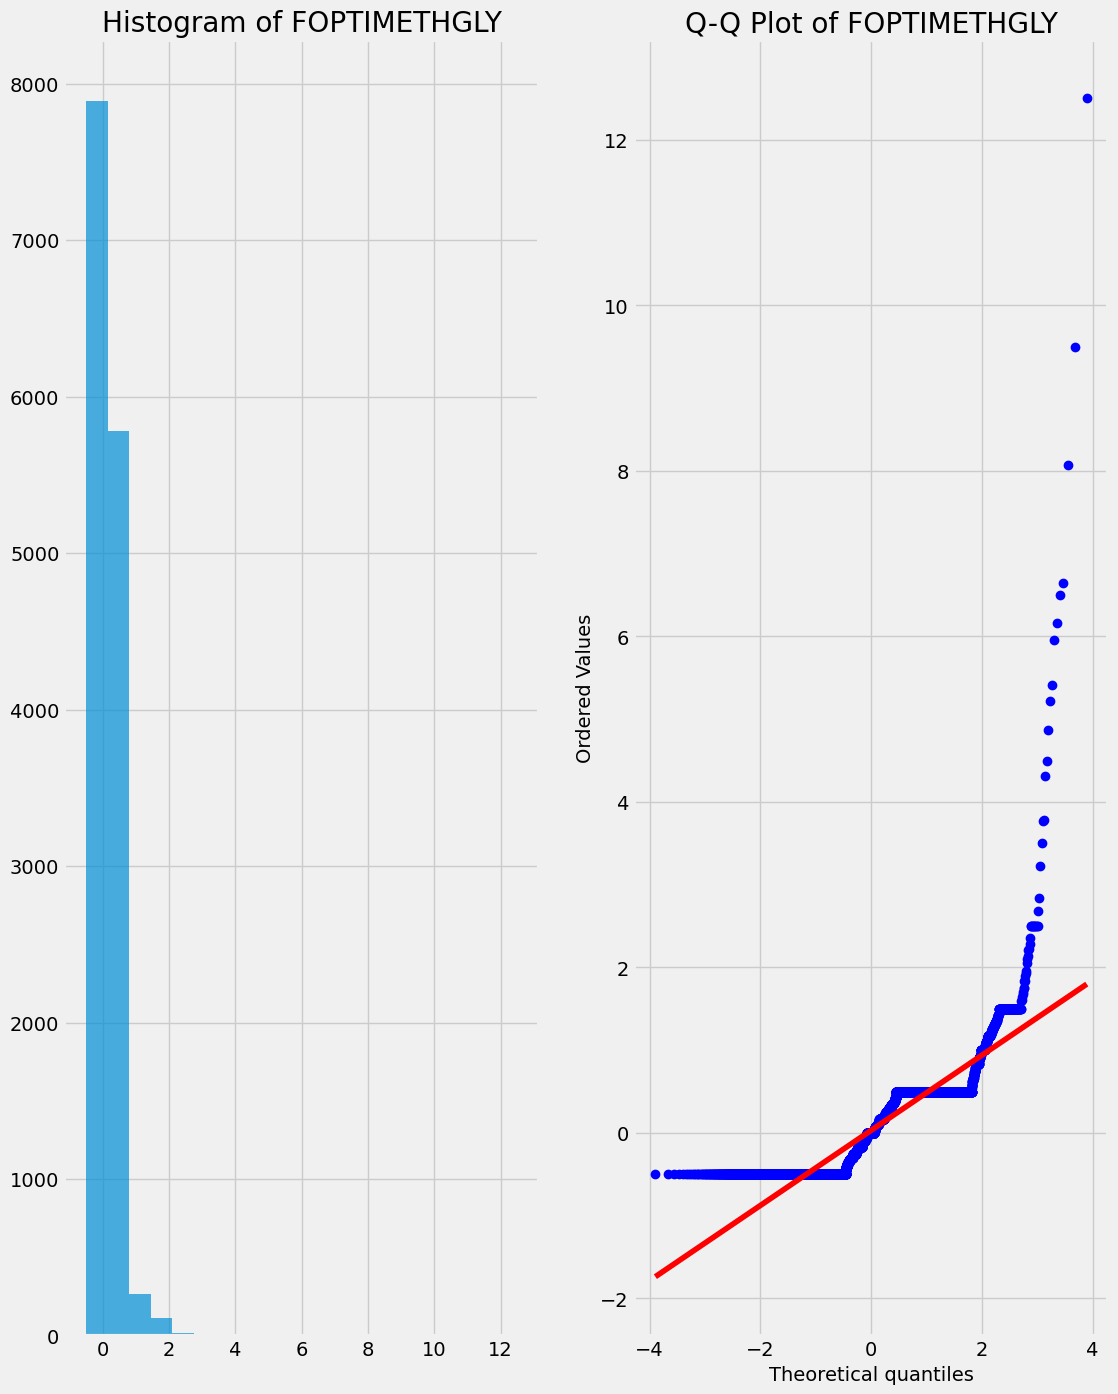

<Figure size 640x480 with 0 Axes>

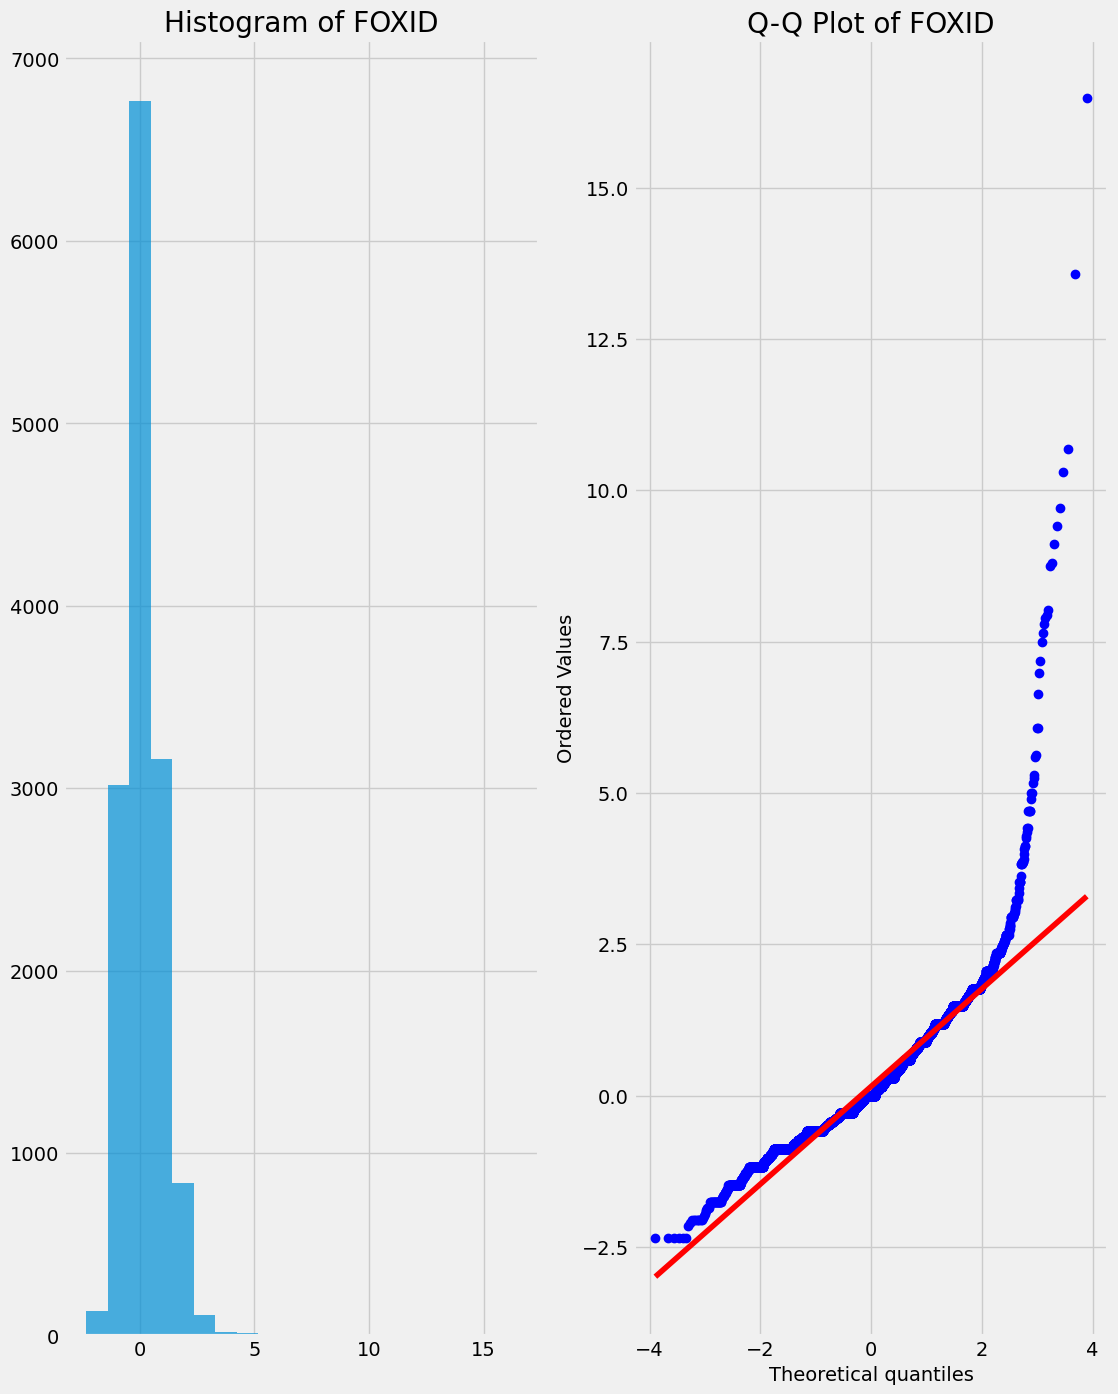

<Figure size 640x480 with 0 Axes>

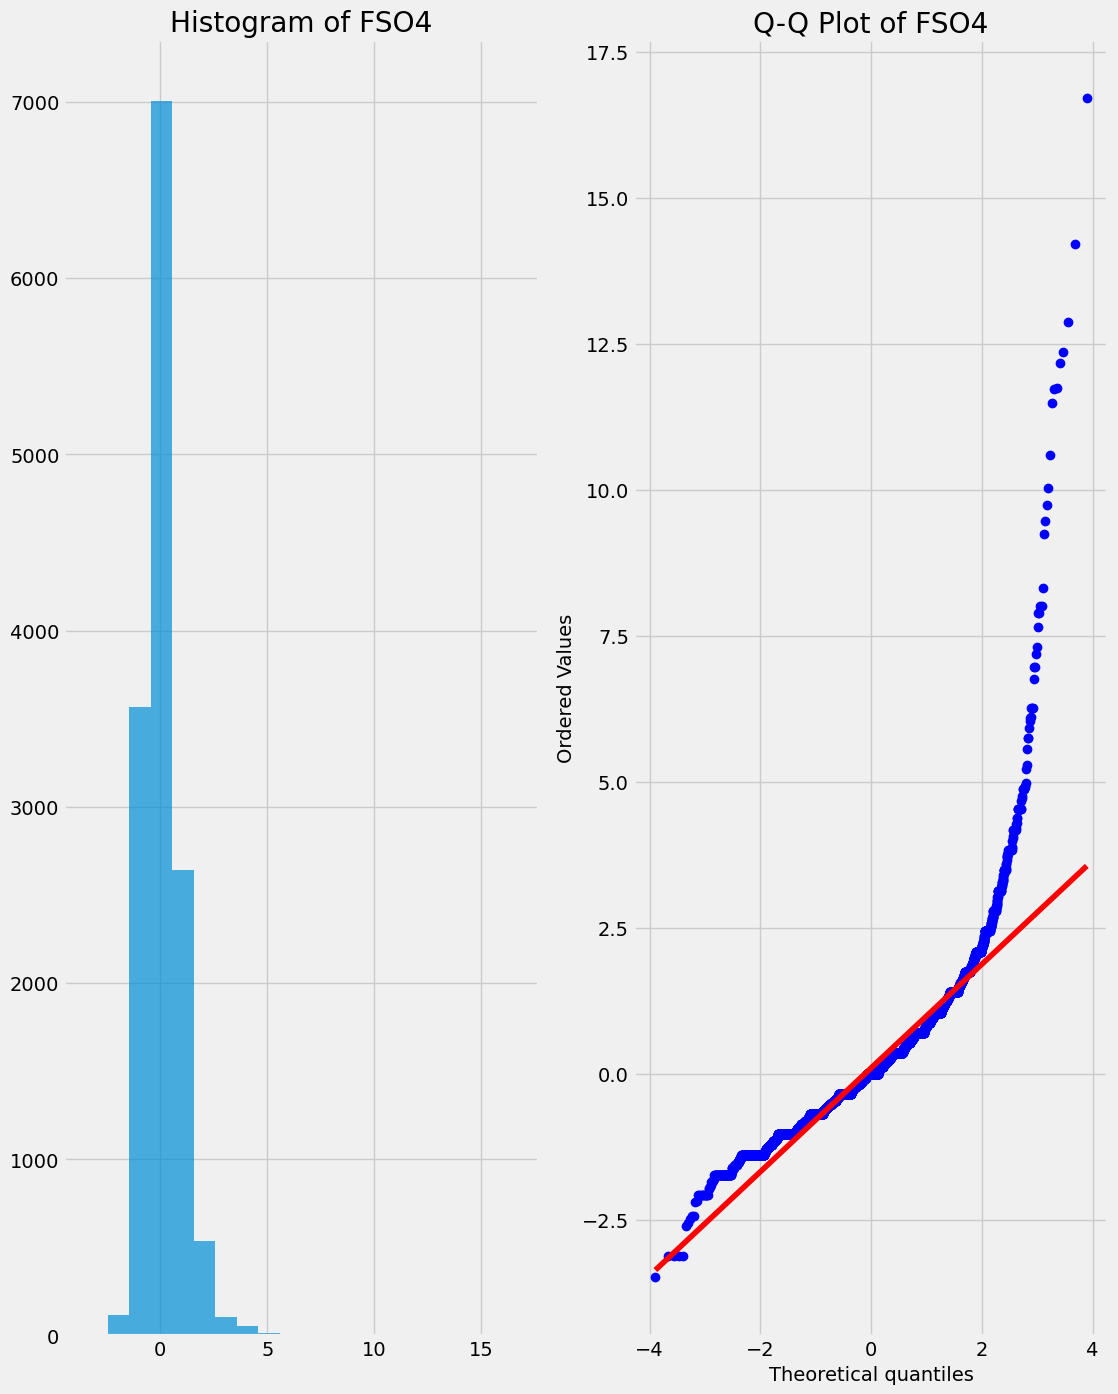

<Figure size 640x480 with 0 Axes>

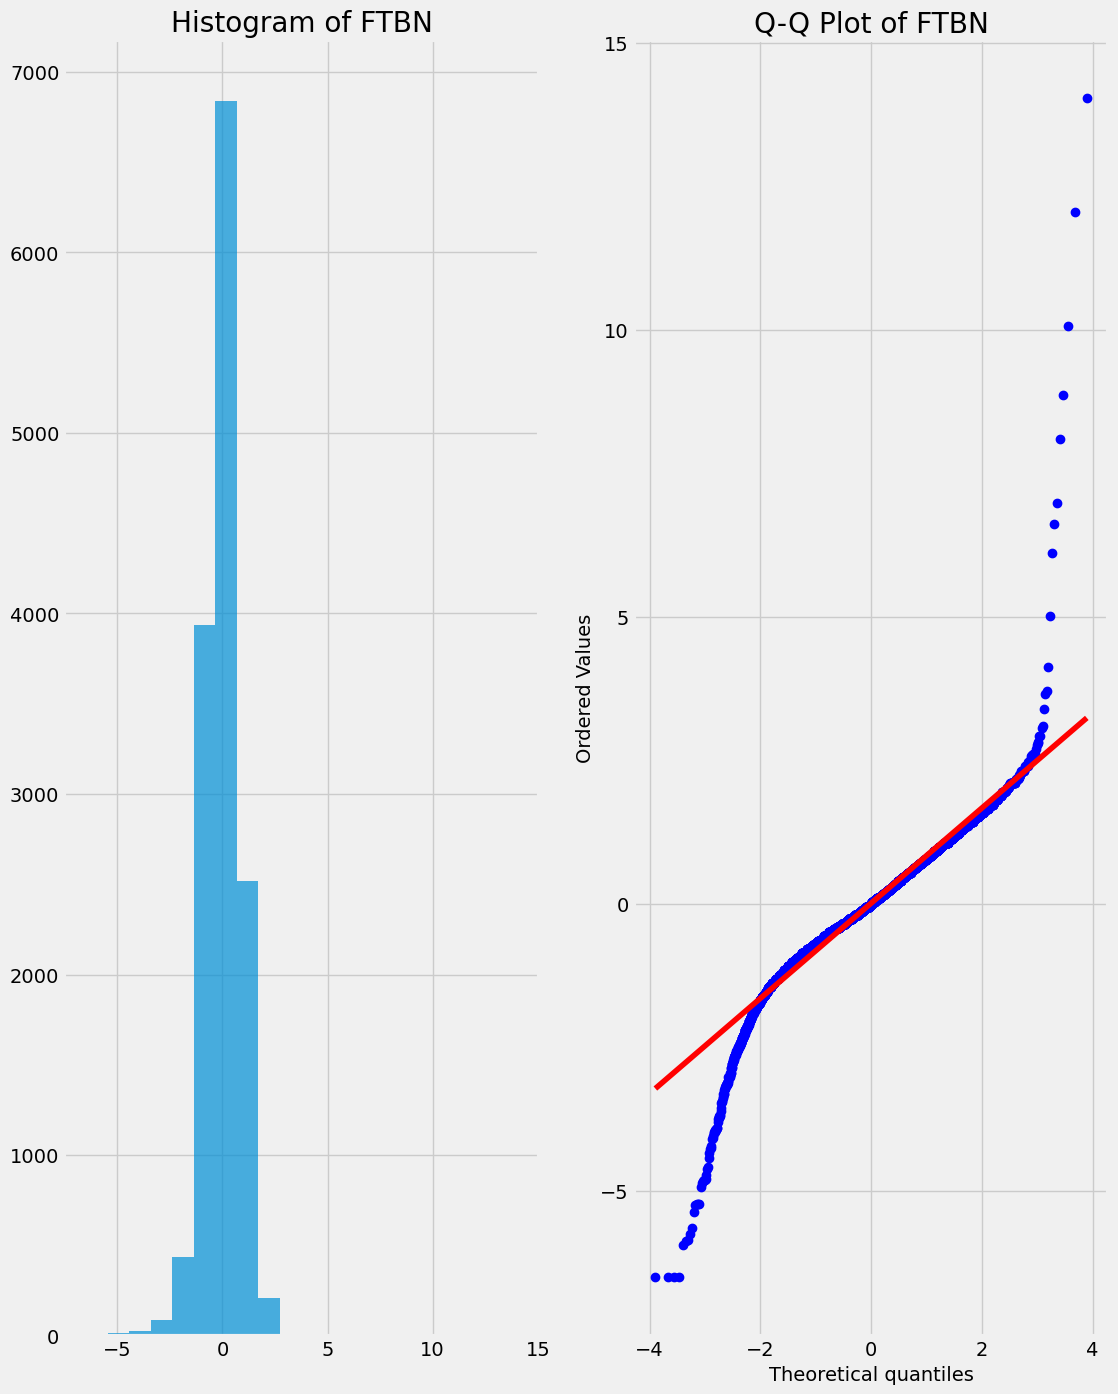

<Figure size 640x480 with 0 Axes>

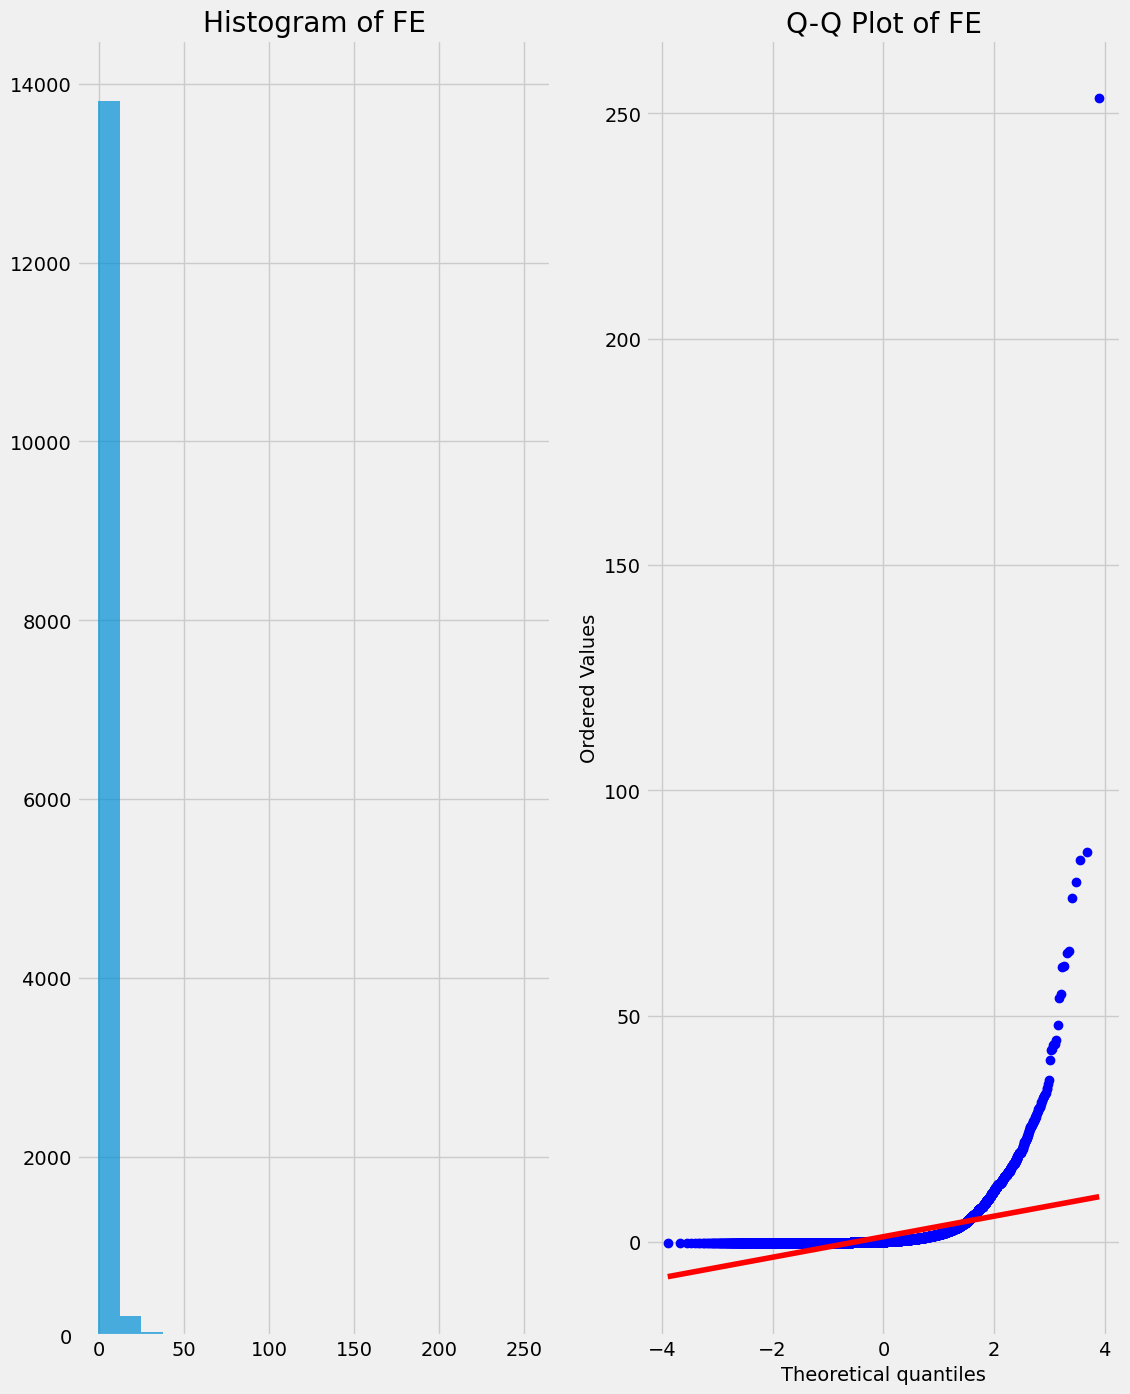

<Figure size 640x480 with 0 Axes>

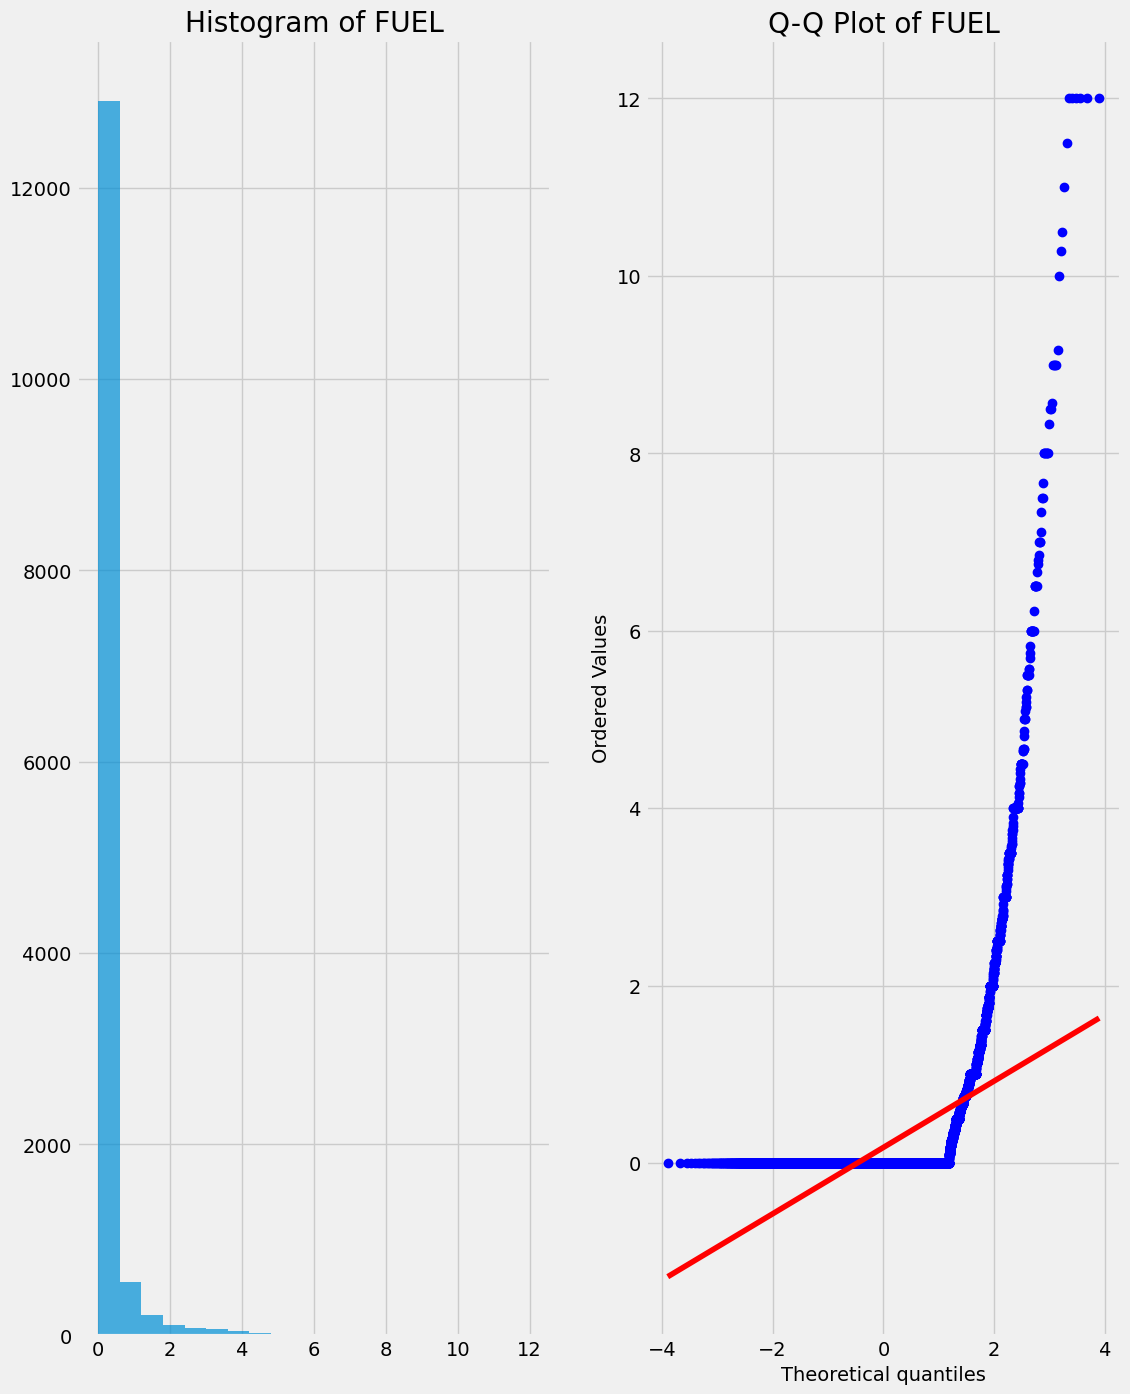

<Figure size 640x480 with 0 Axes>

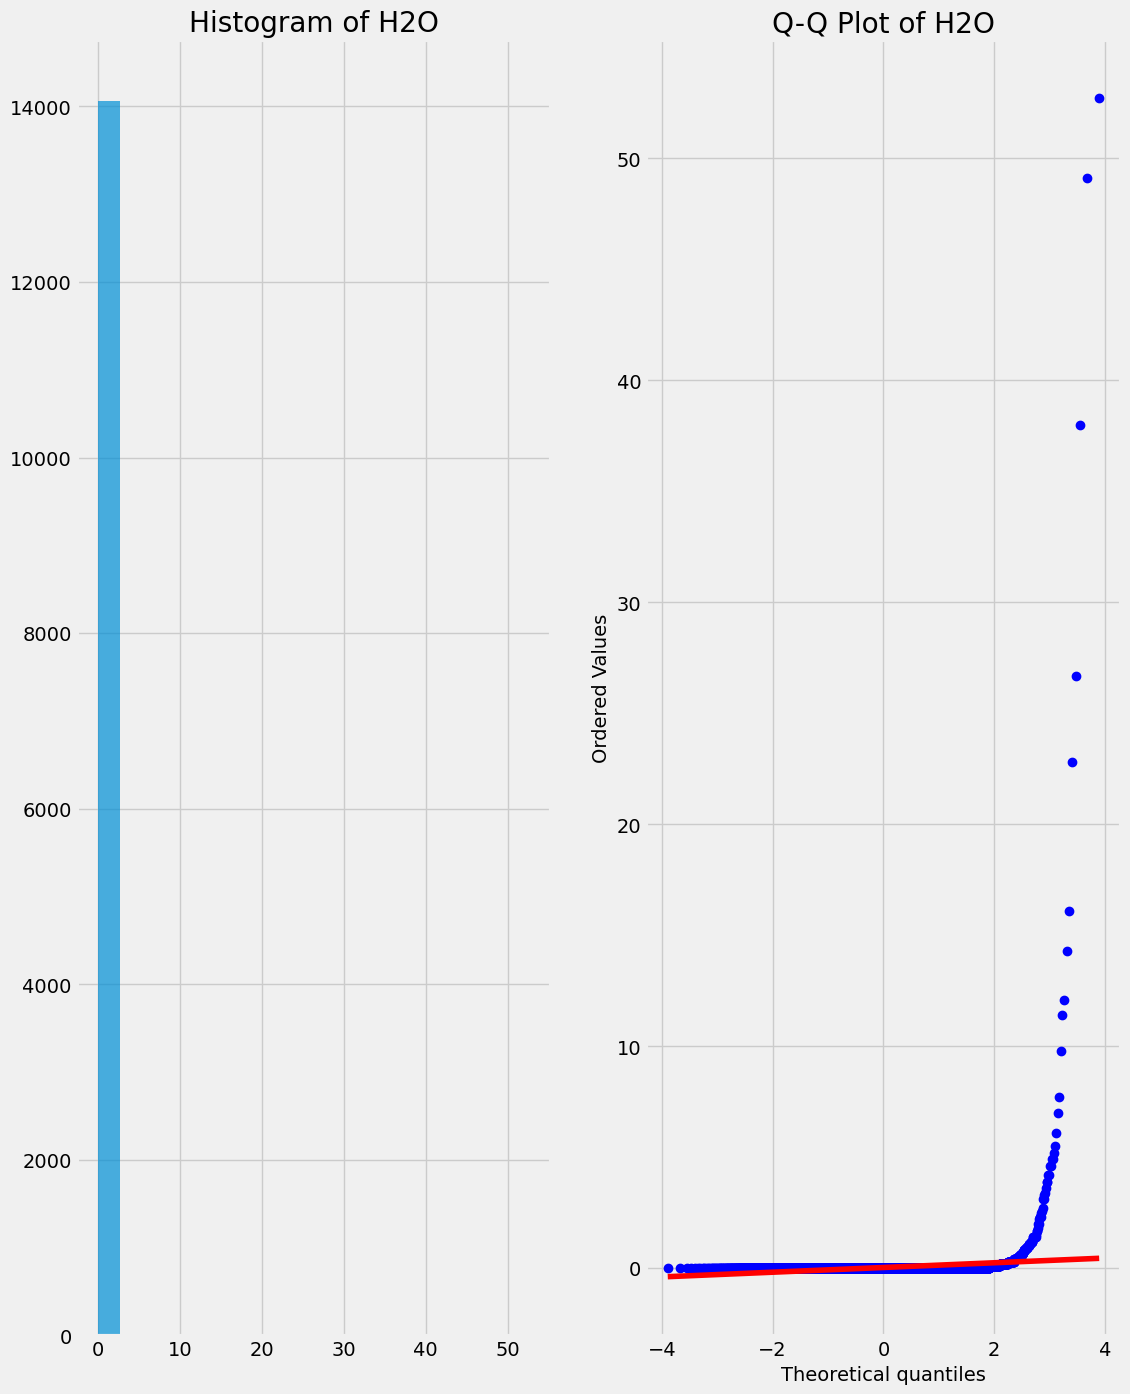

<Figure size 640x480 with 0 Axes>

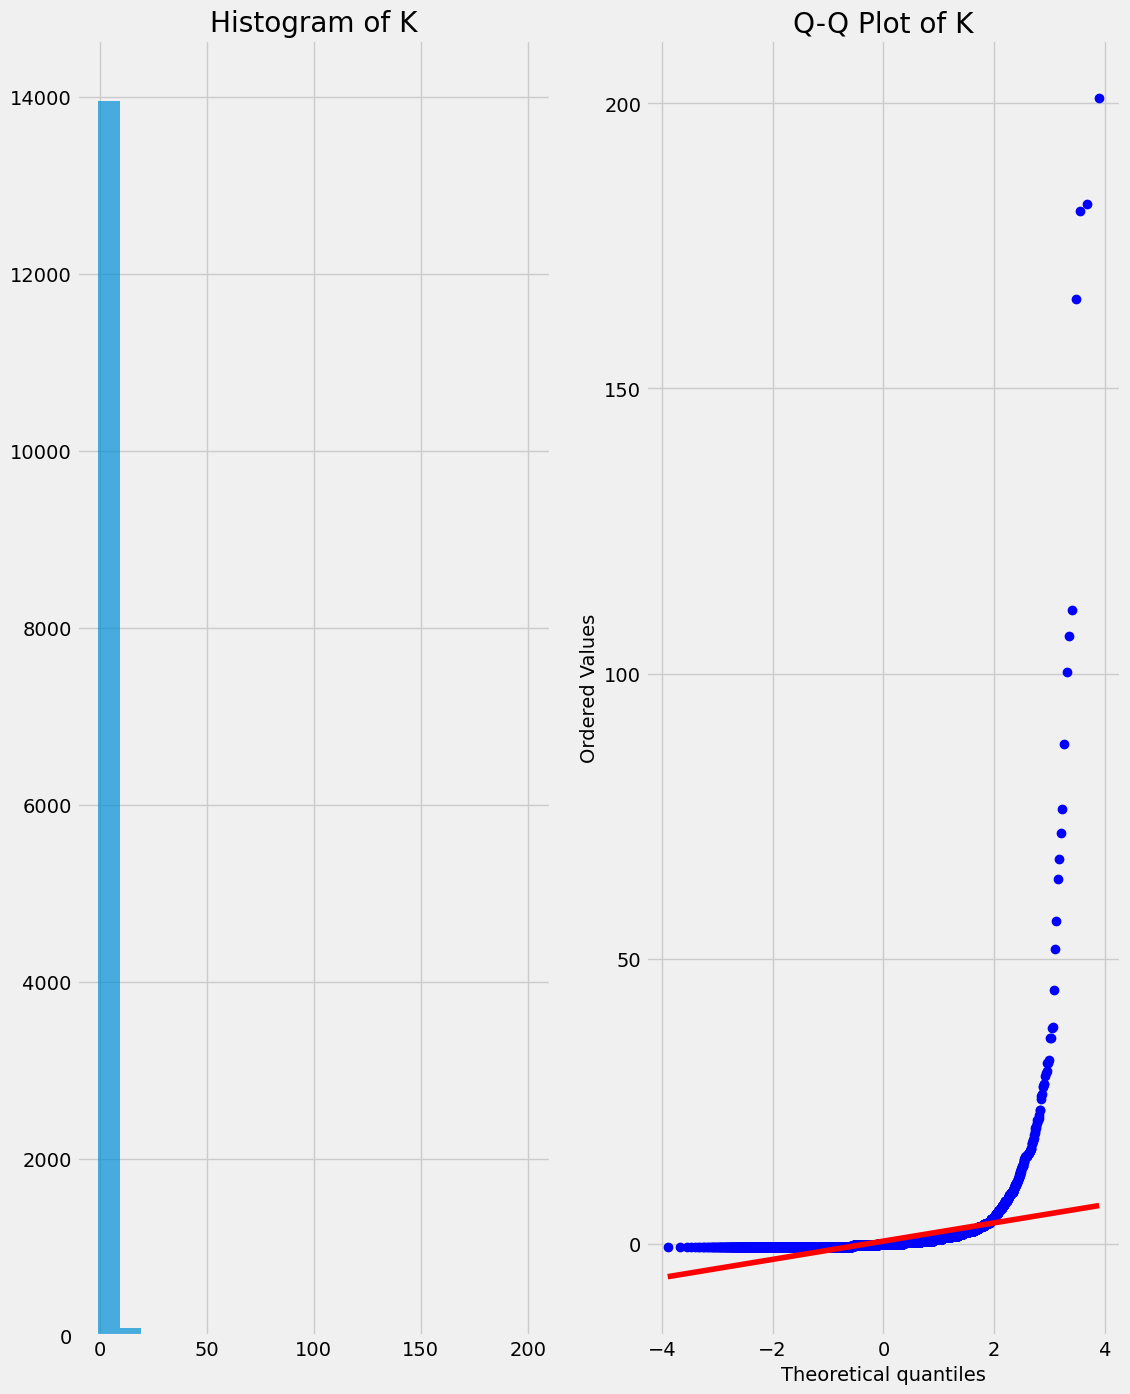

<Figure size 640x480 with 0 Axes>

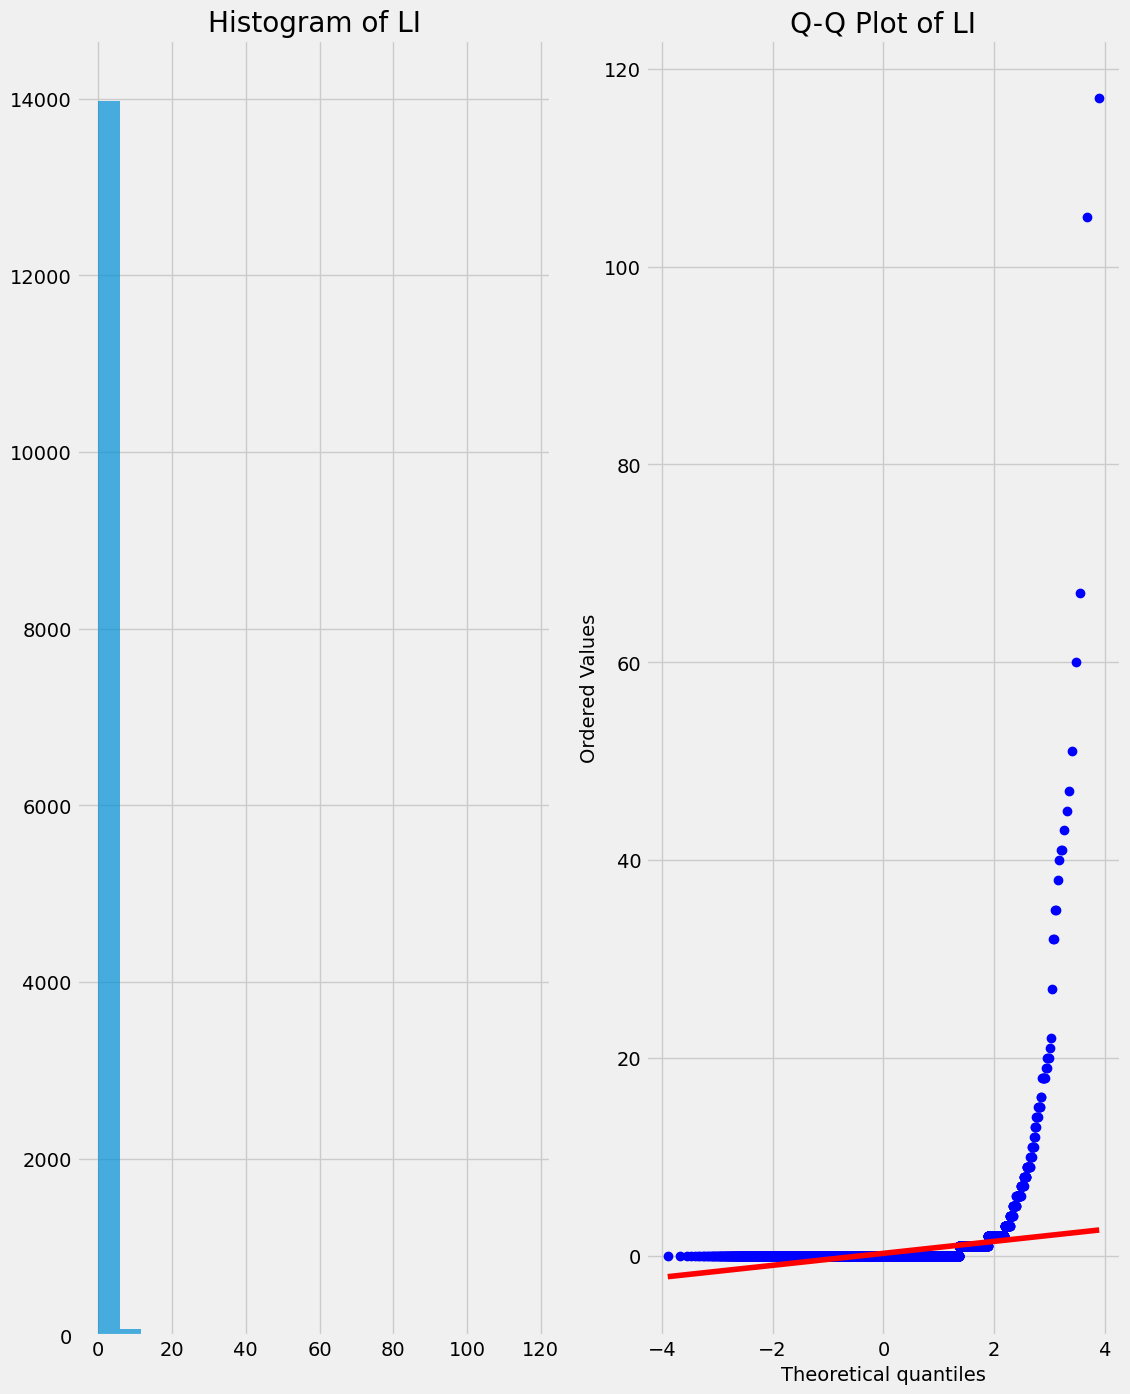

<Figure size 640x480 with 0 Axes>

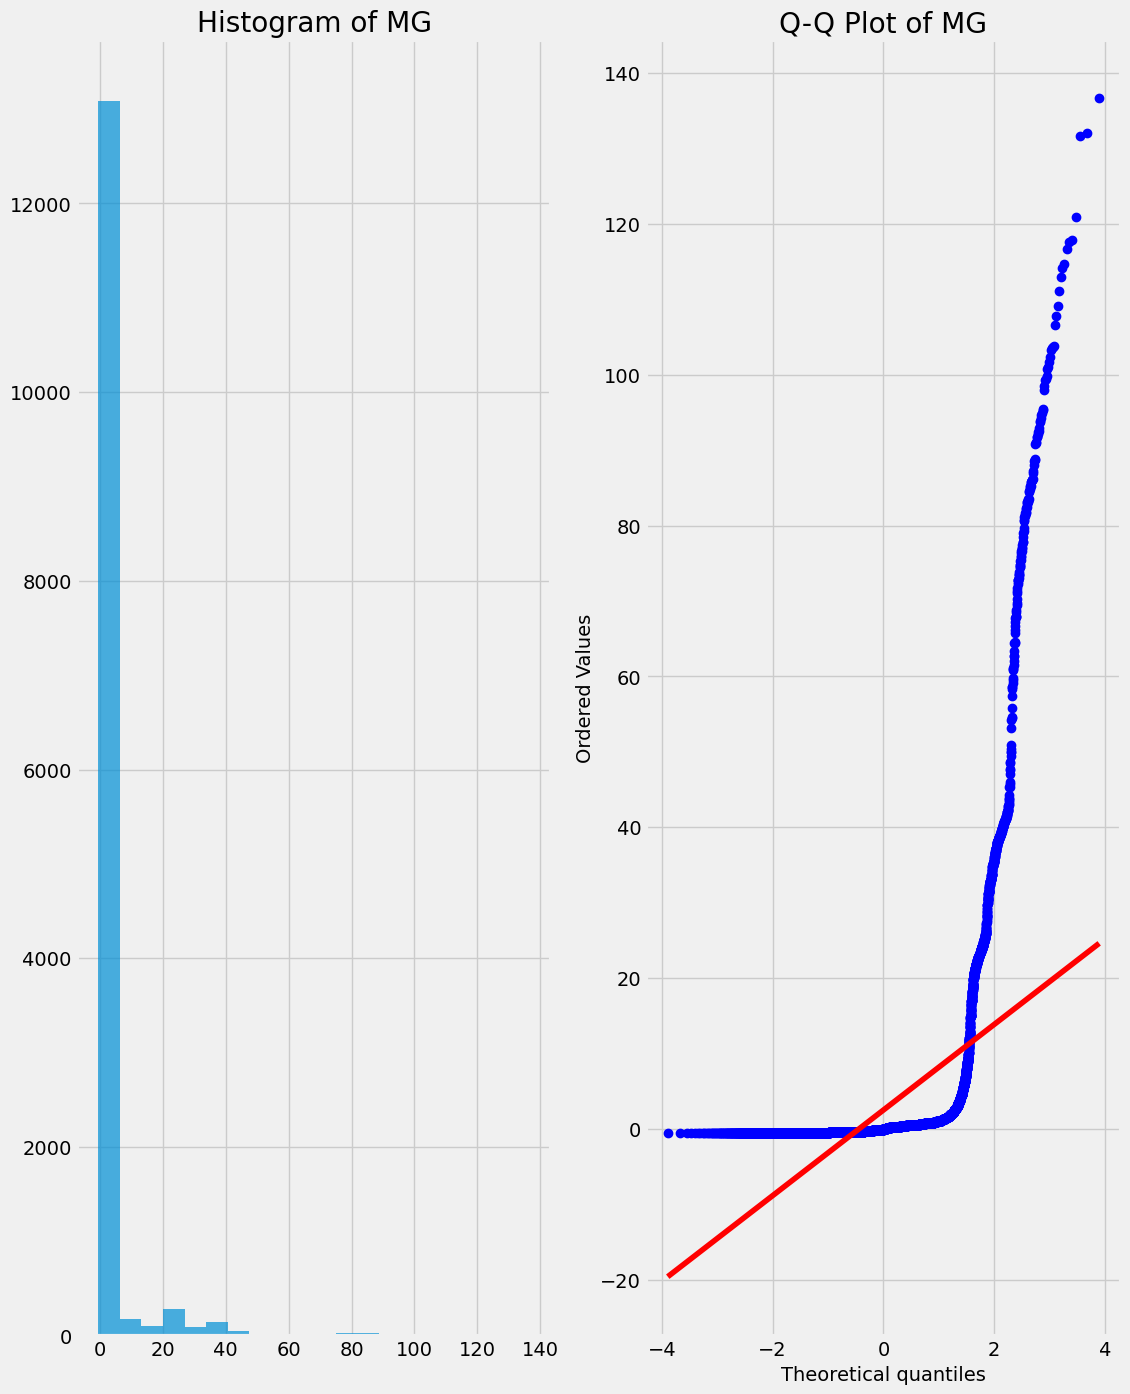

<Figure size 640x480 with 0 Axes>

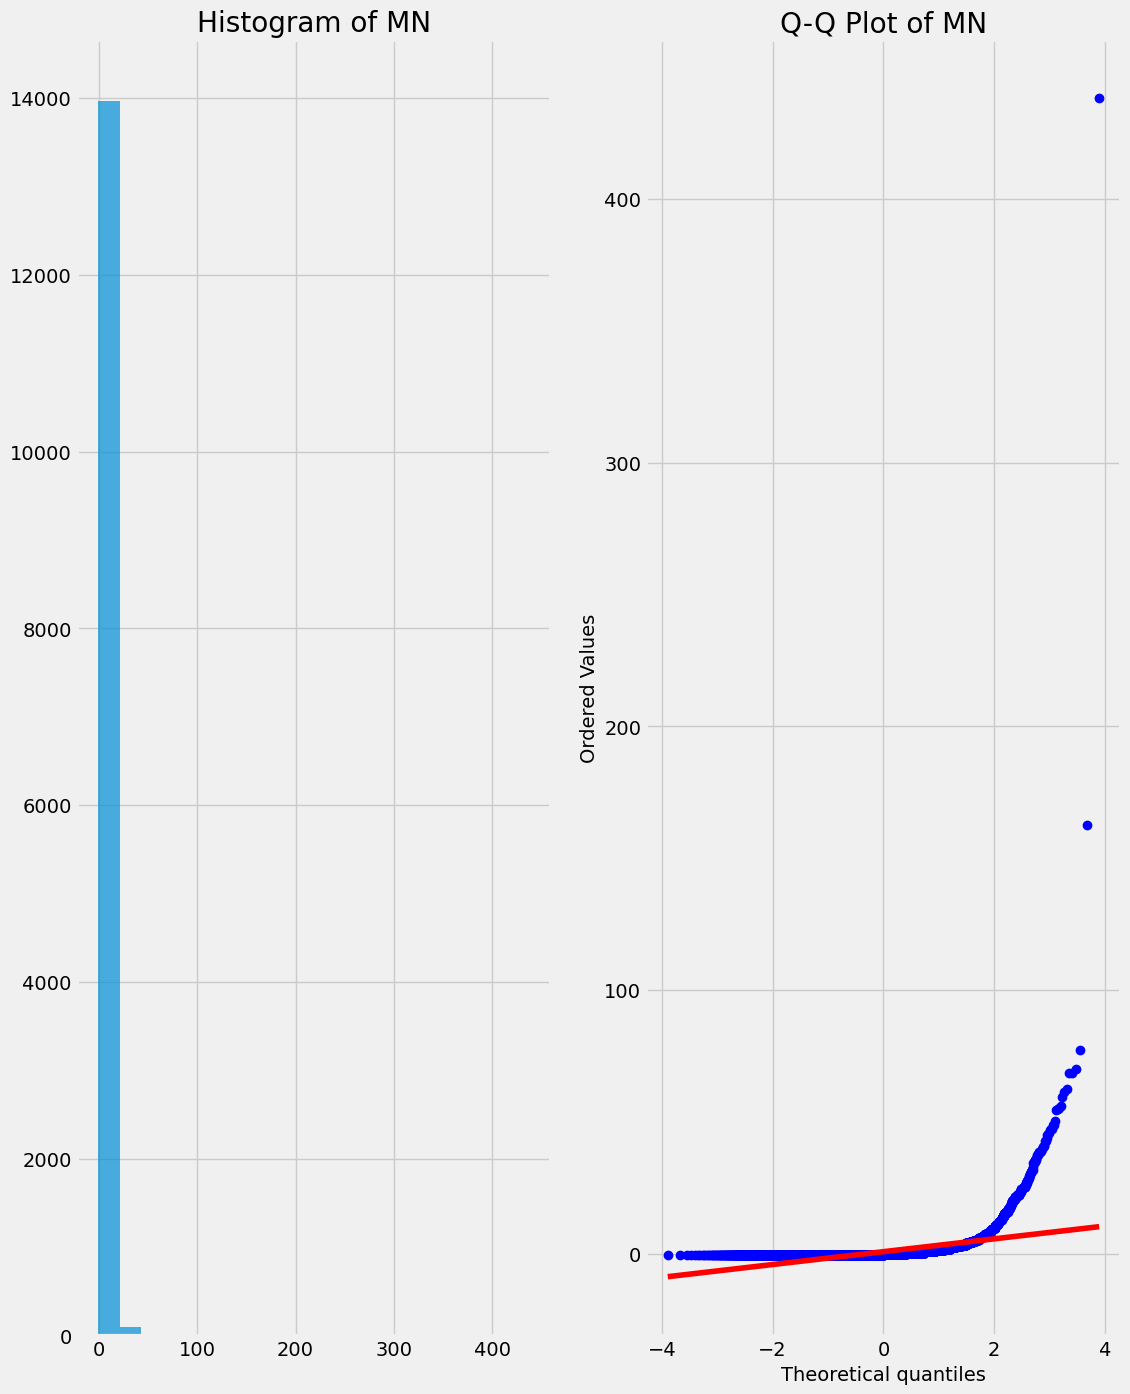

<Figure size 640x480 with 0 Axes>

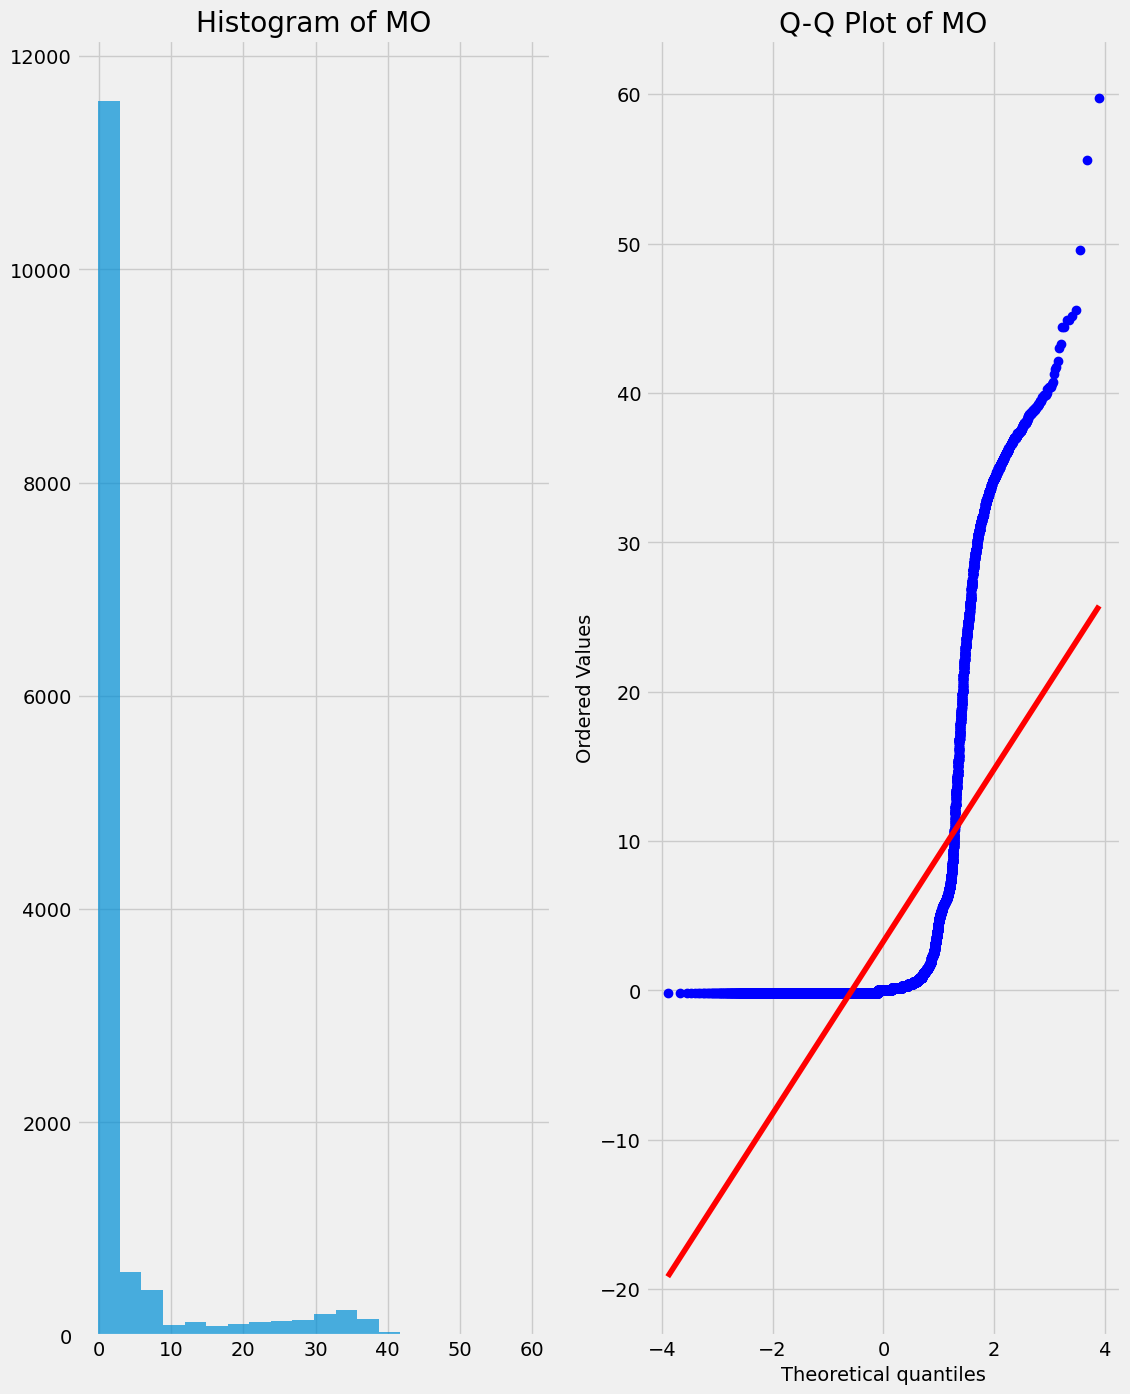

<Figure size 640x480 with 0 Axes>

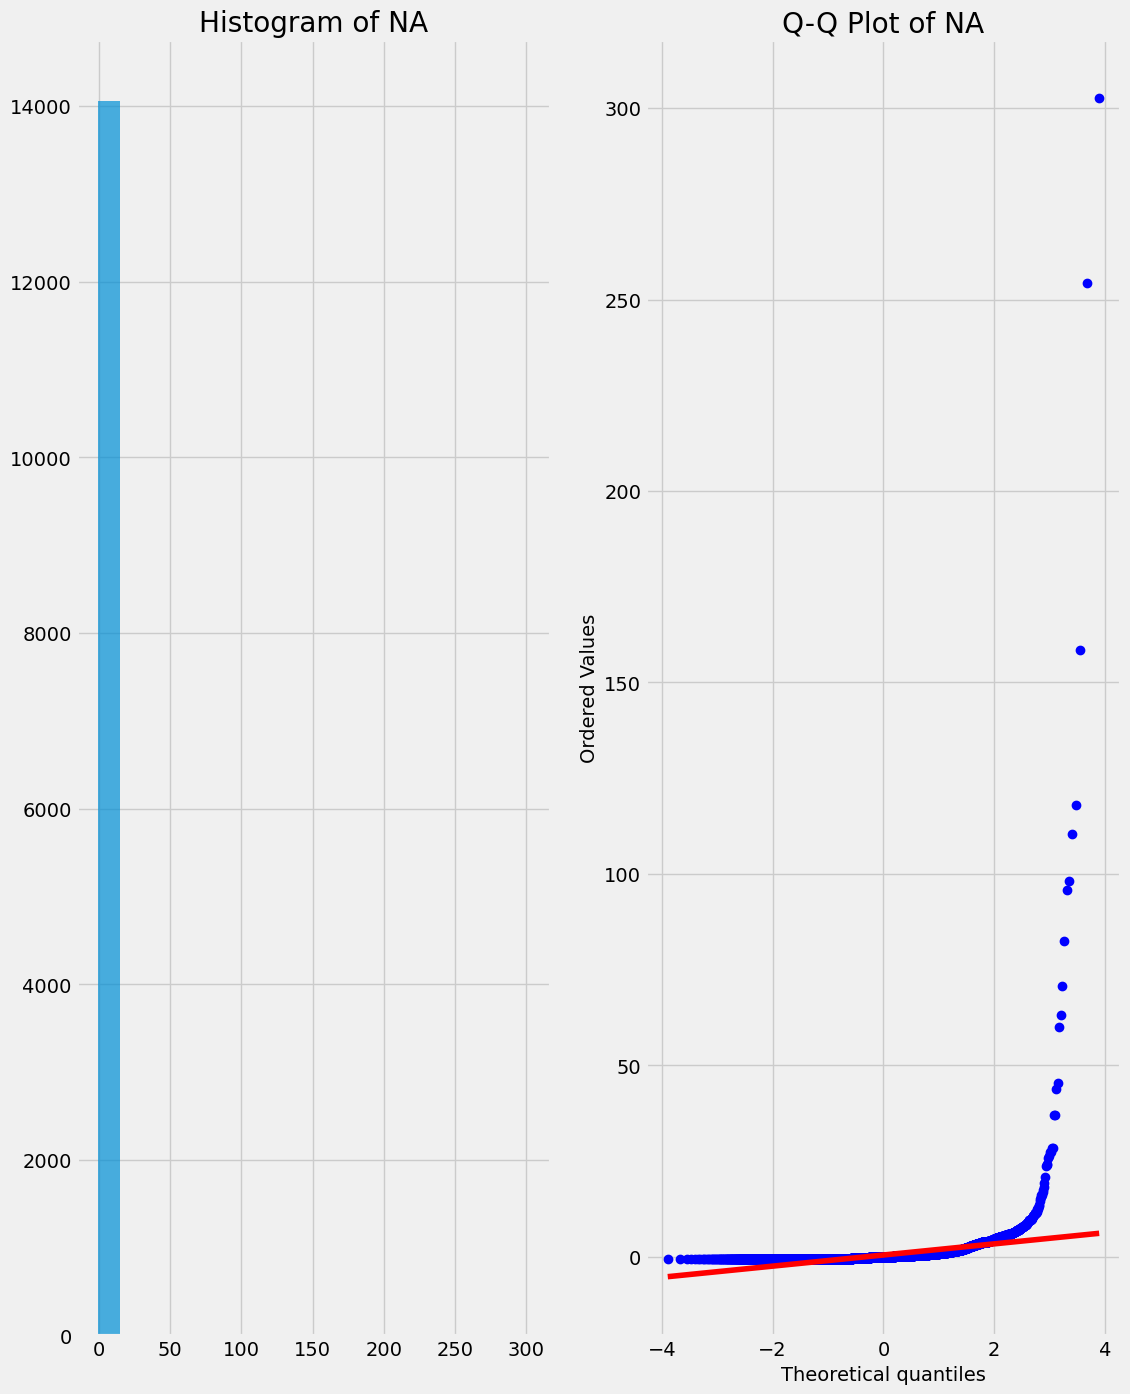

<Figure size 640x480 with 0 Axes>

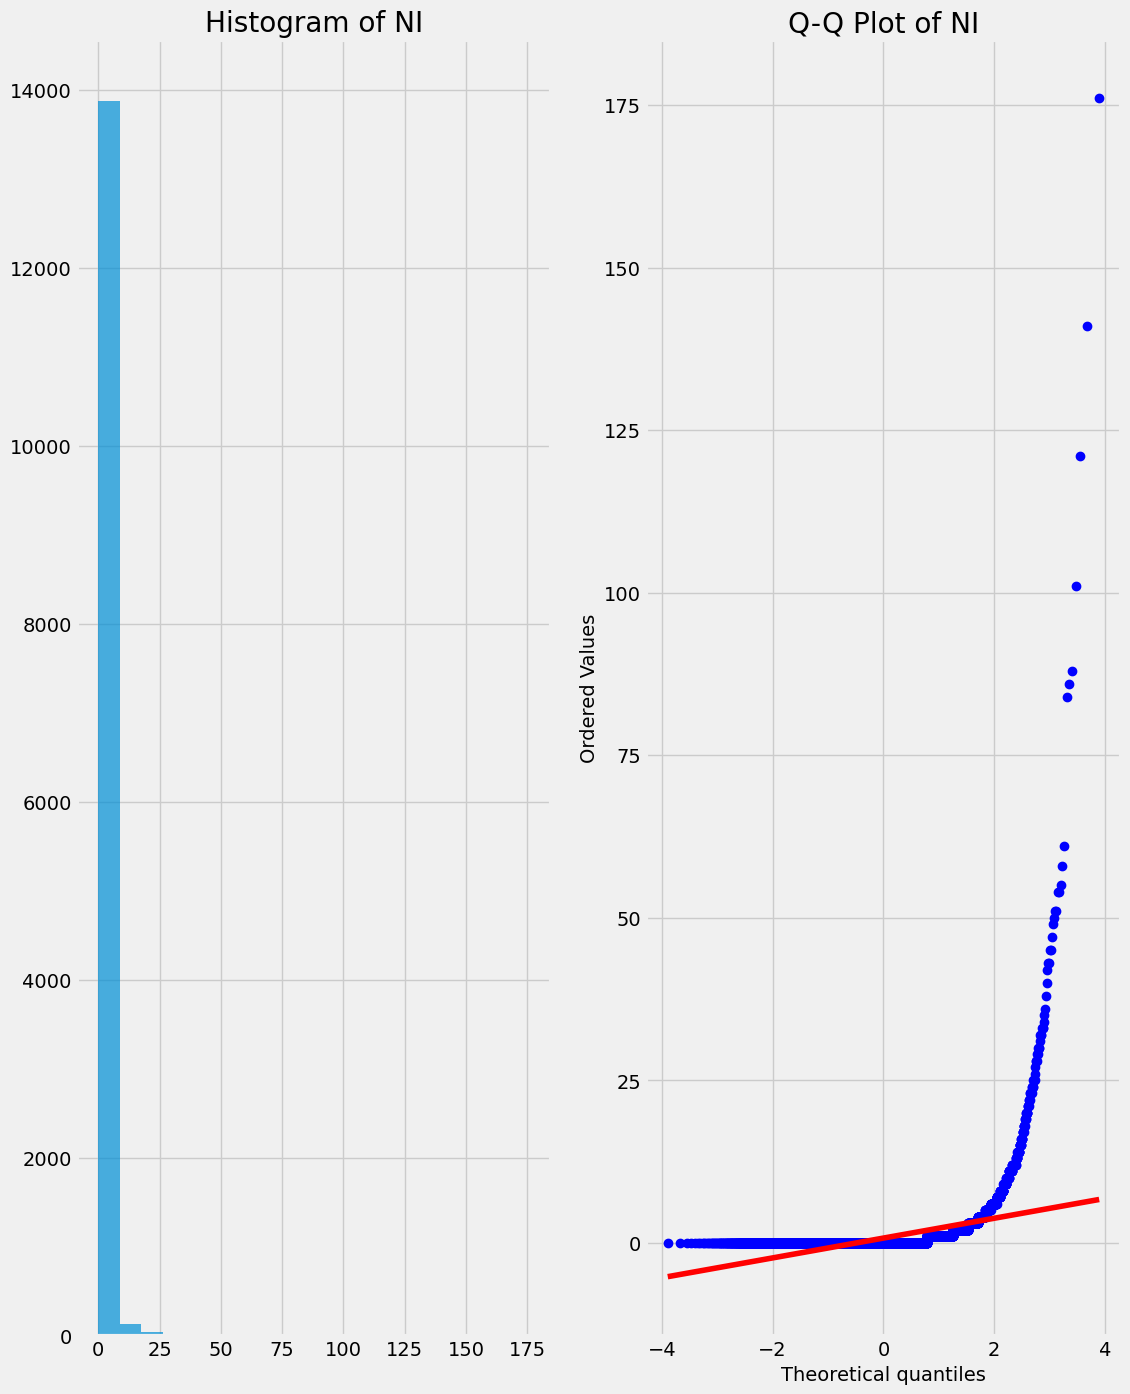

<Figure size 640x480 with 0 Axes>

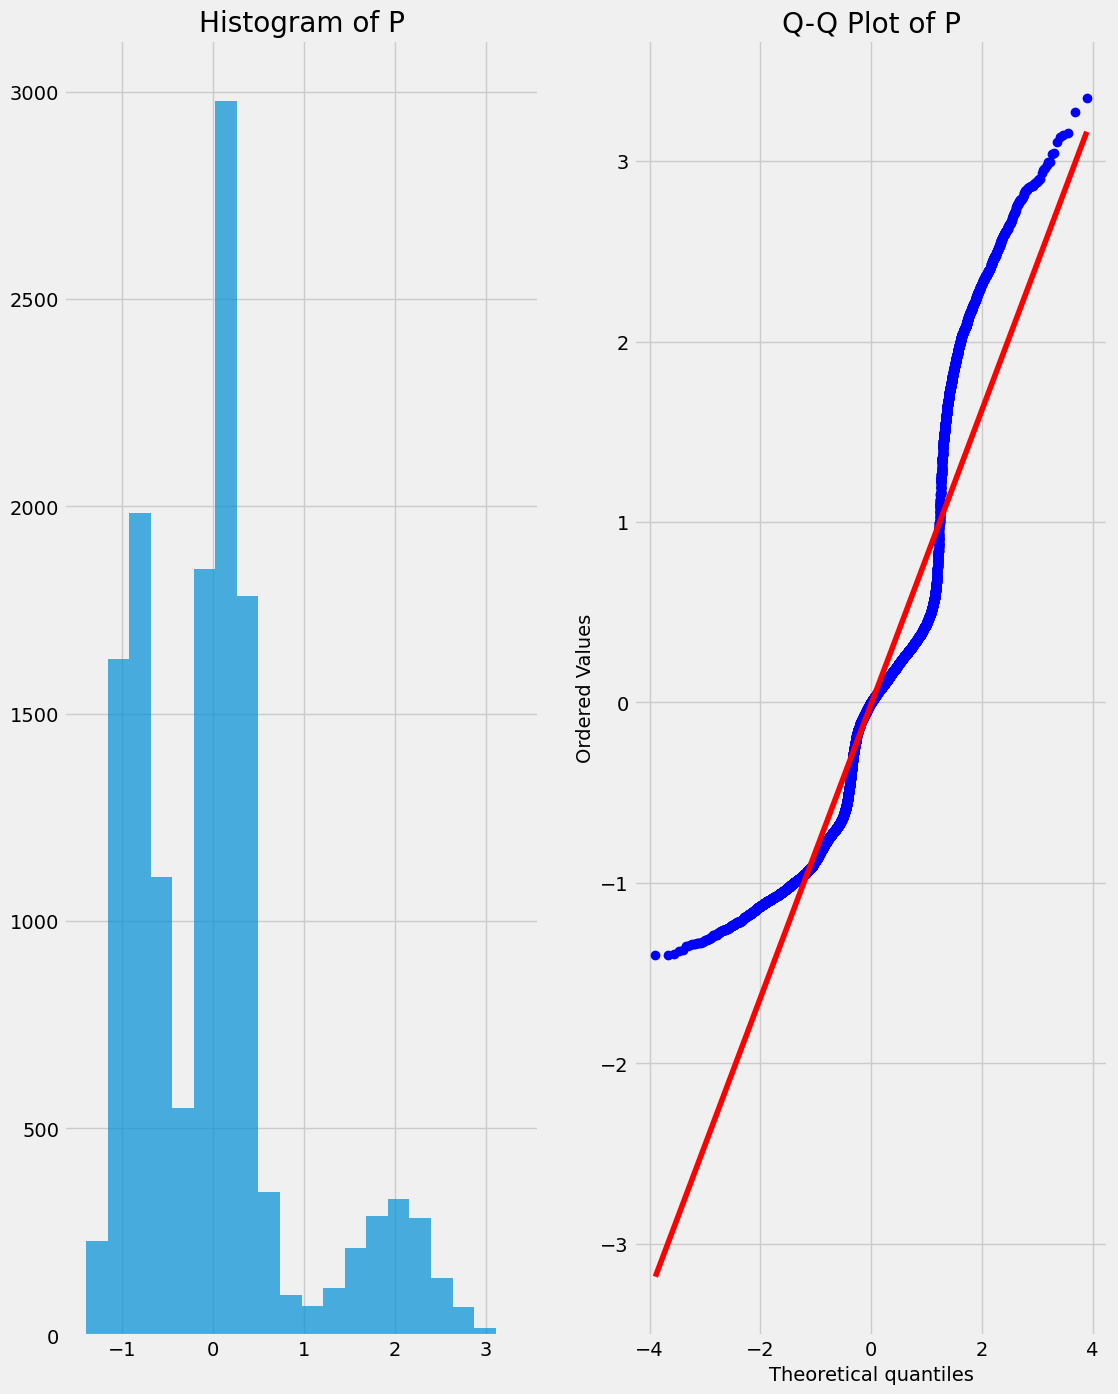

<Figure size 640x480 with 0 Axes>

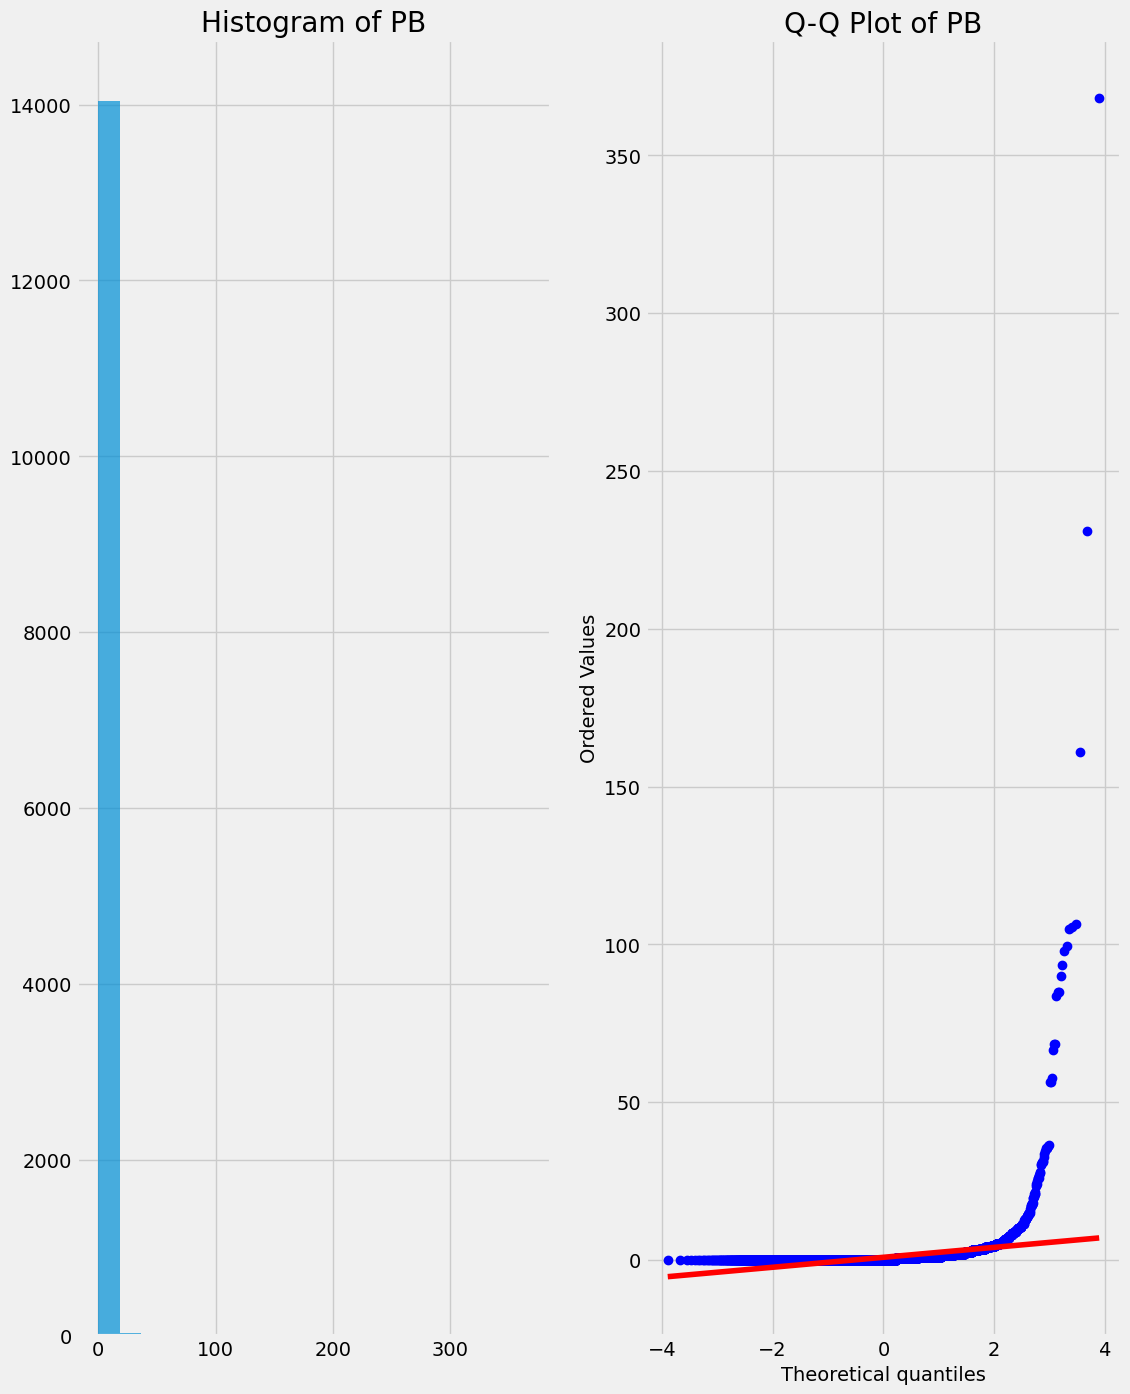

<Figure size 640x480 with 0 Axes>

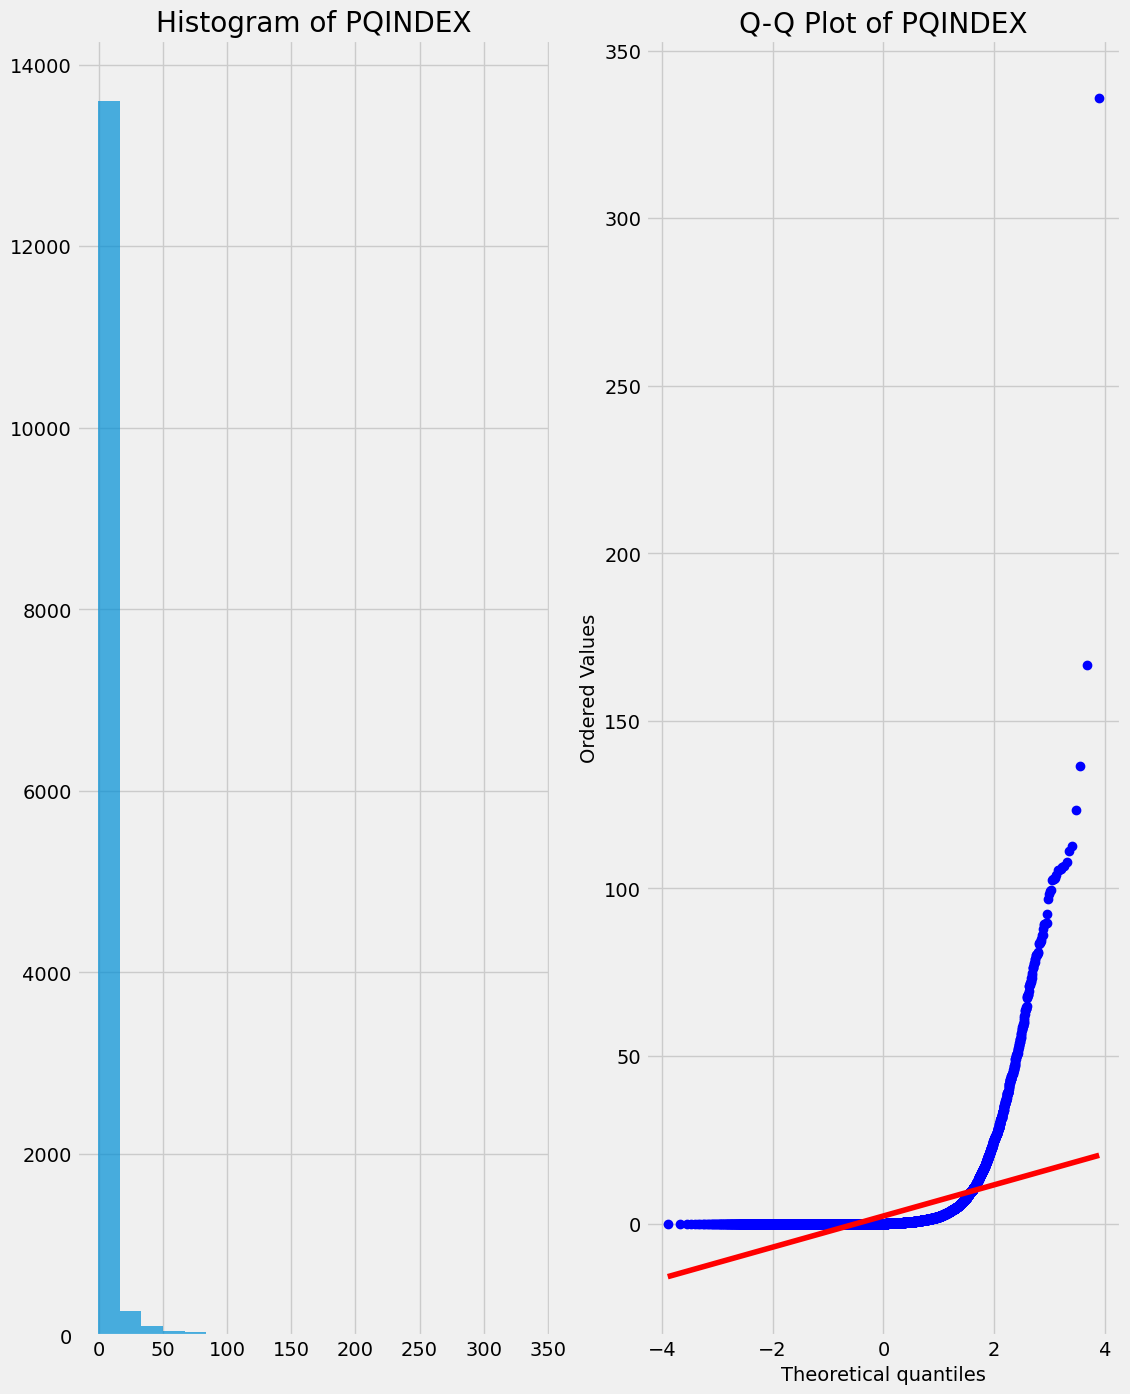

<Figure size 640x480 with 0 Axes>

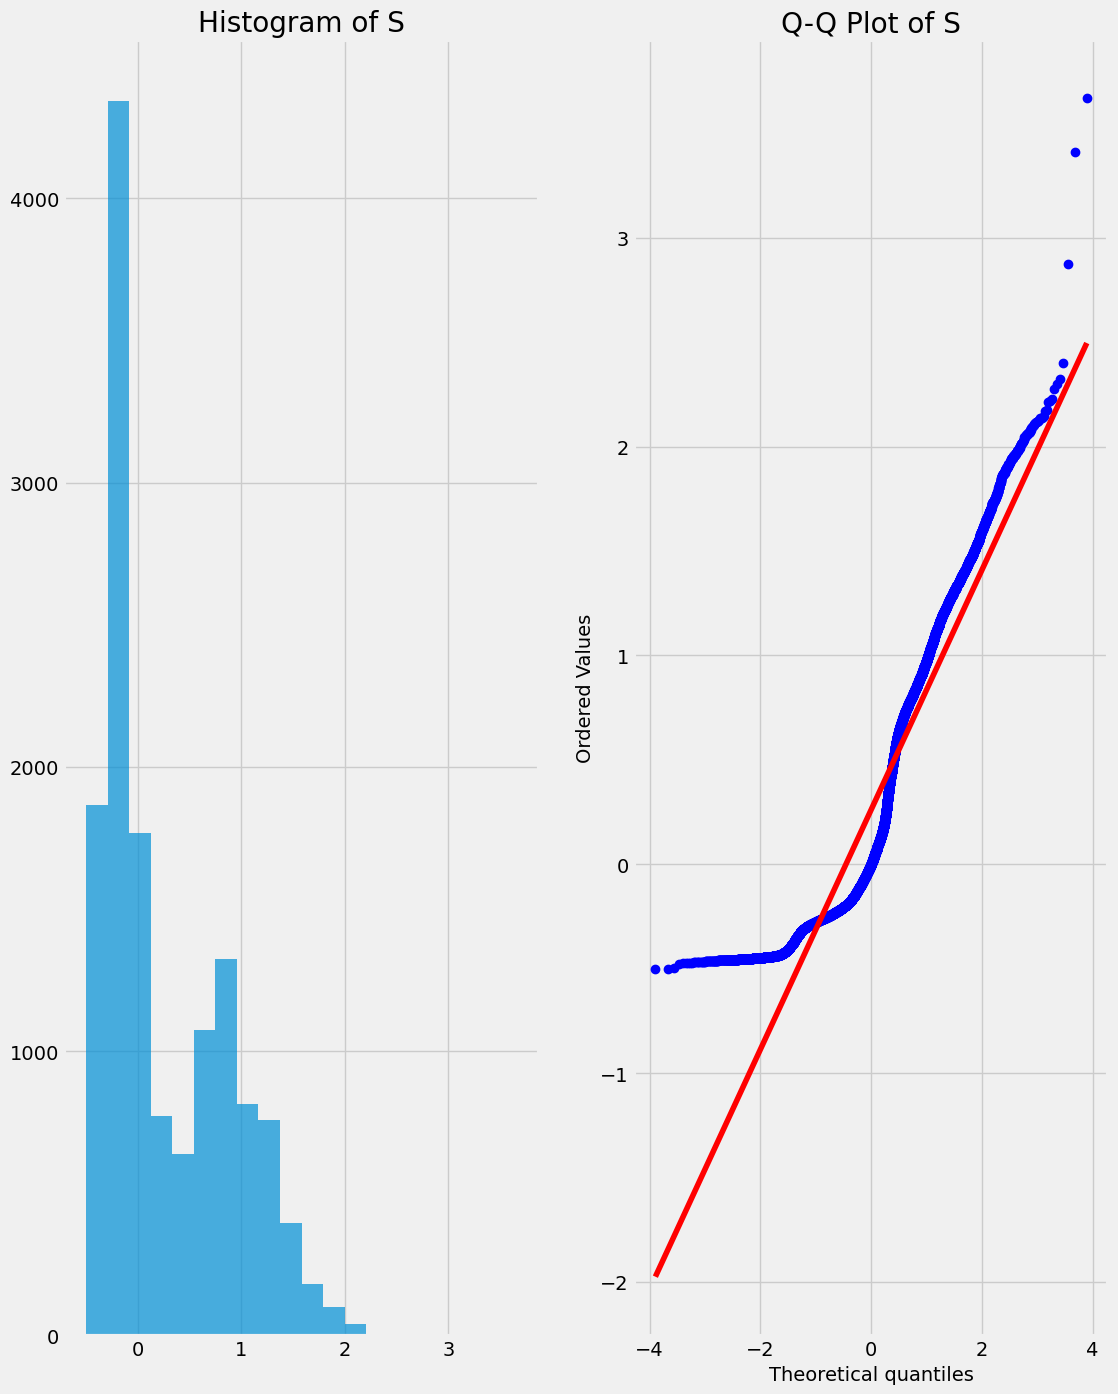

<Figure size 640x480 with 0 Axes>

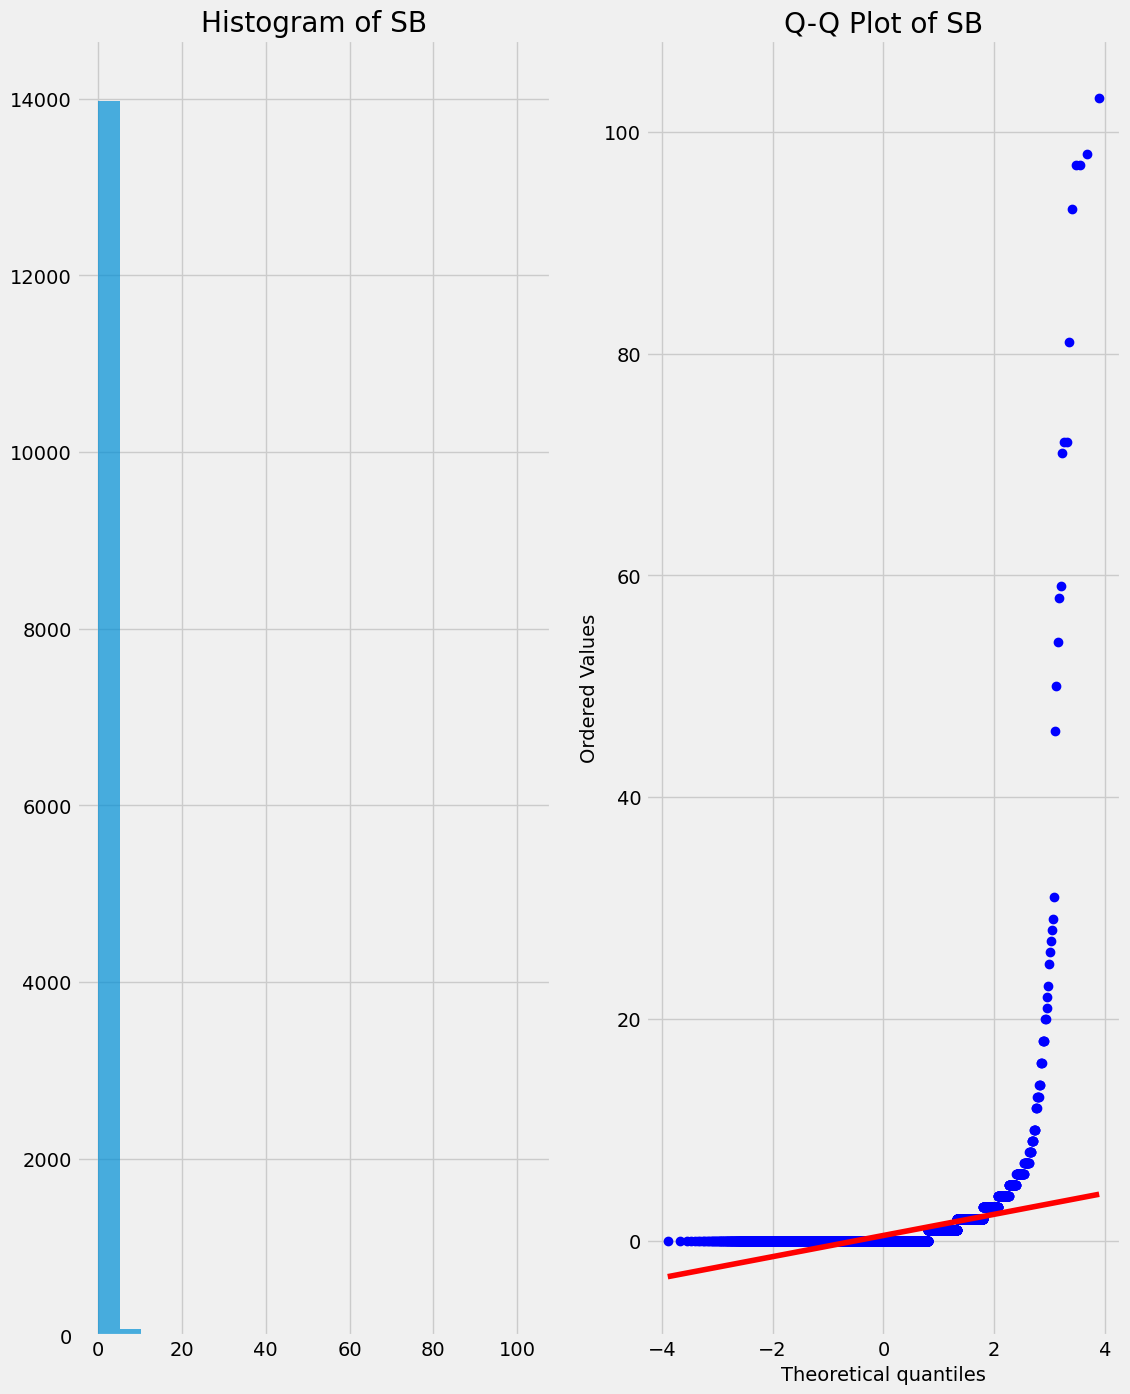

<Figure size 640x480 with 0 Axes>

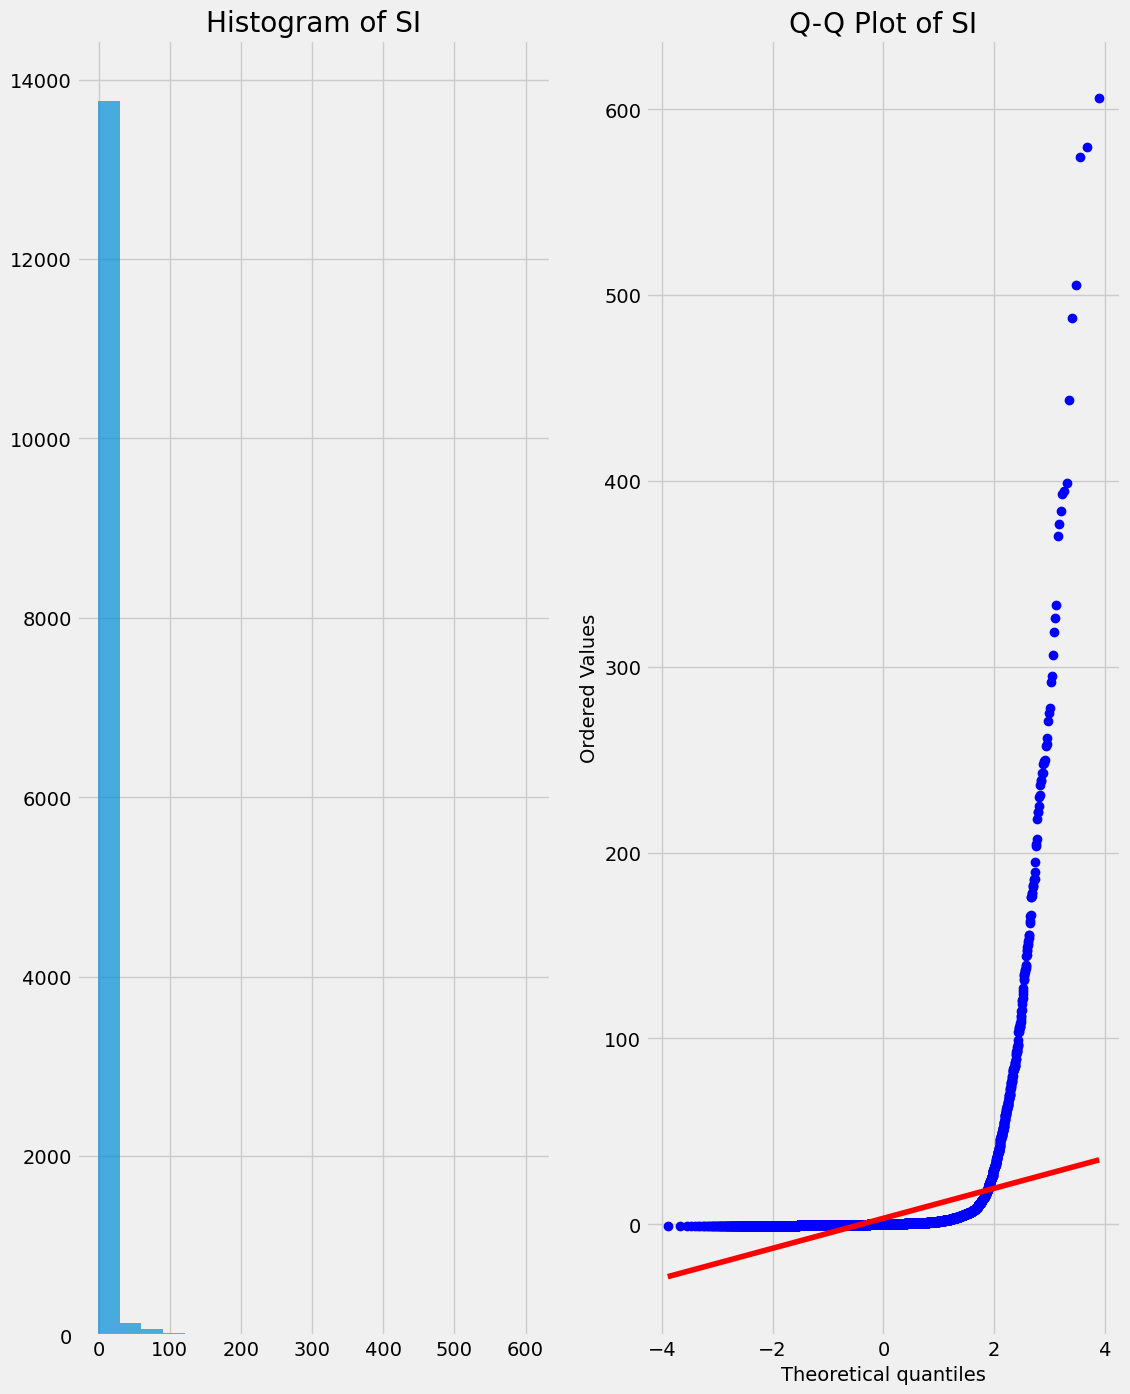

<Figure size 640x480 with 0 Axes>

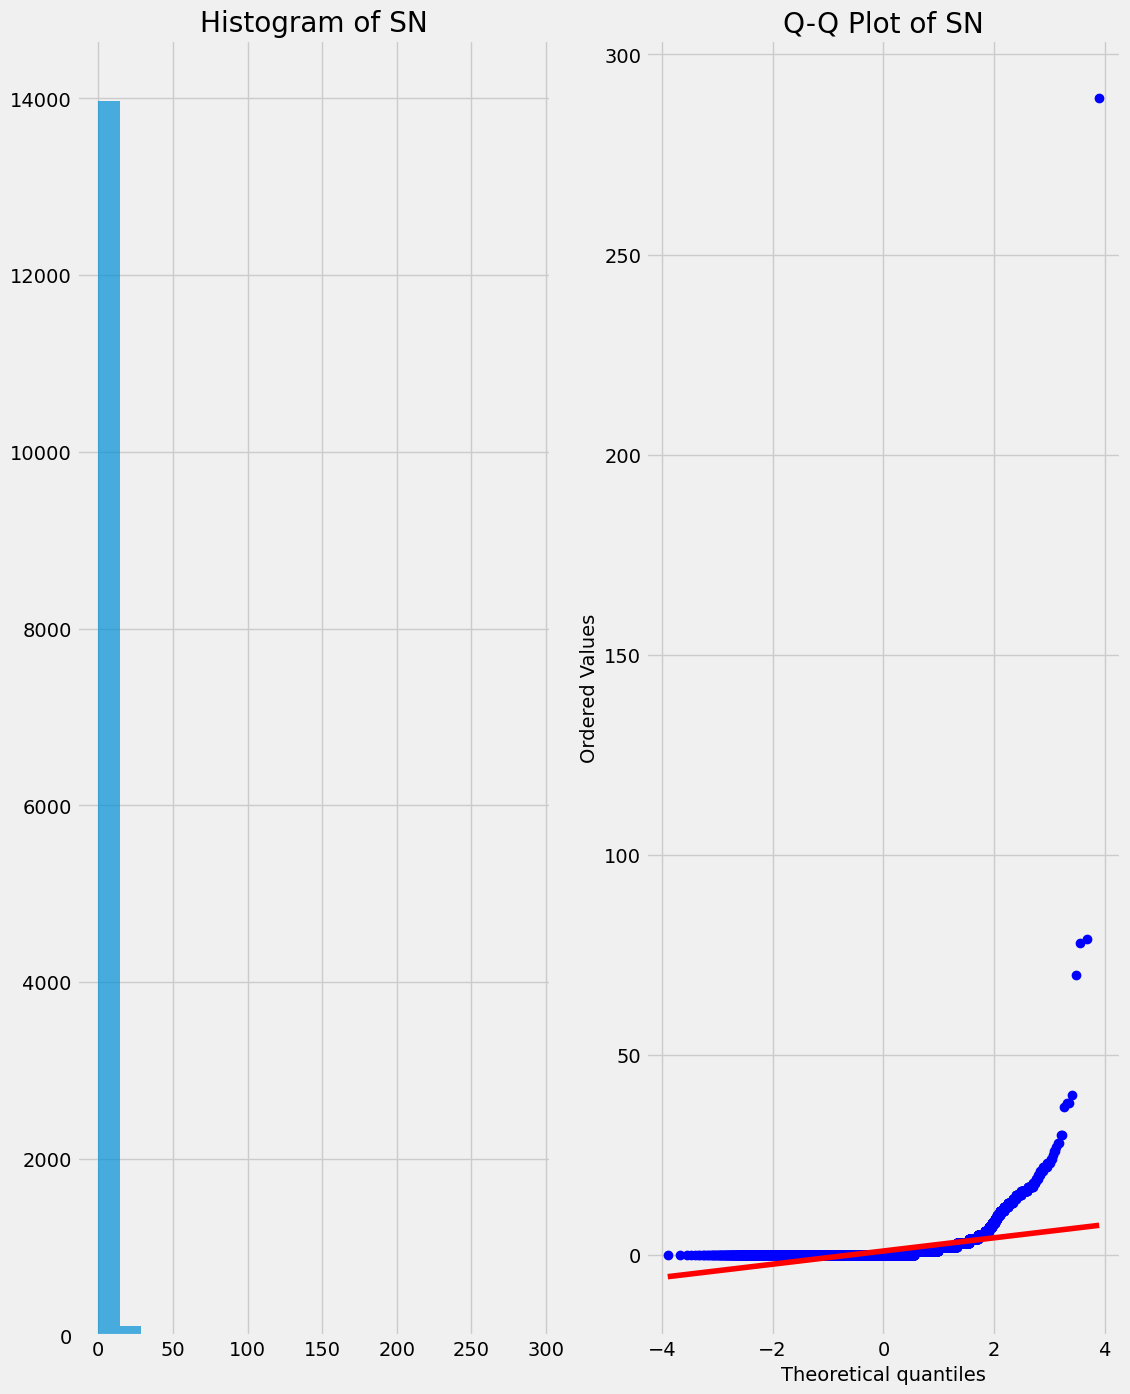

<Figure size 640x480 with 0 Axes>

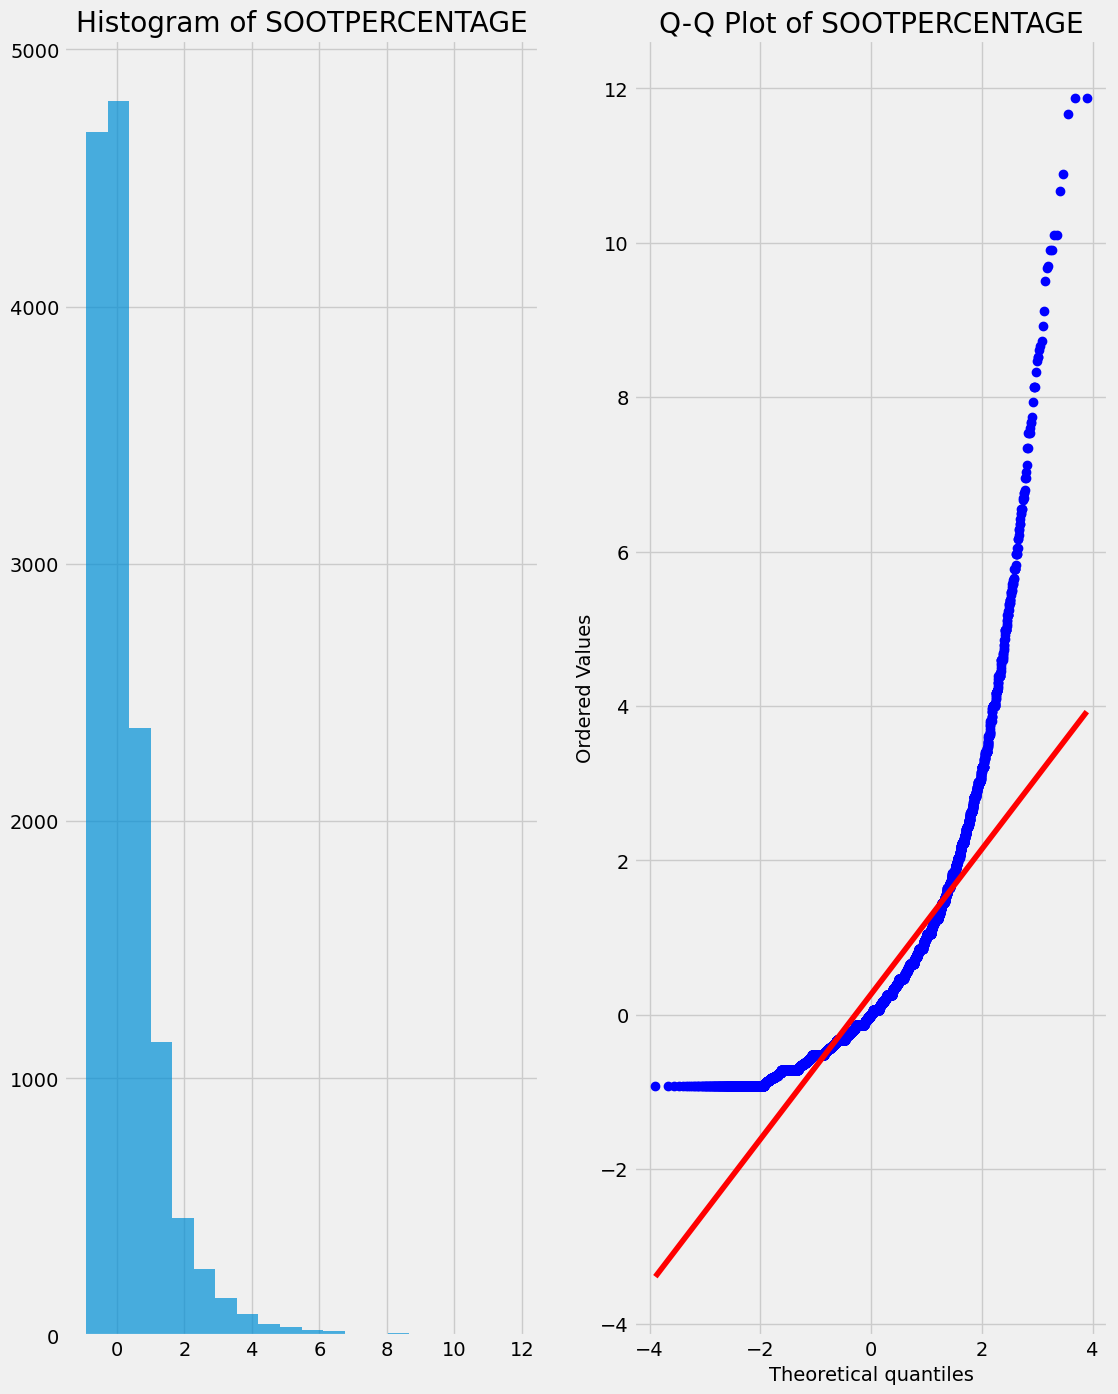

<Figure size 640x480 with 0 Axes>

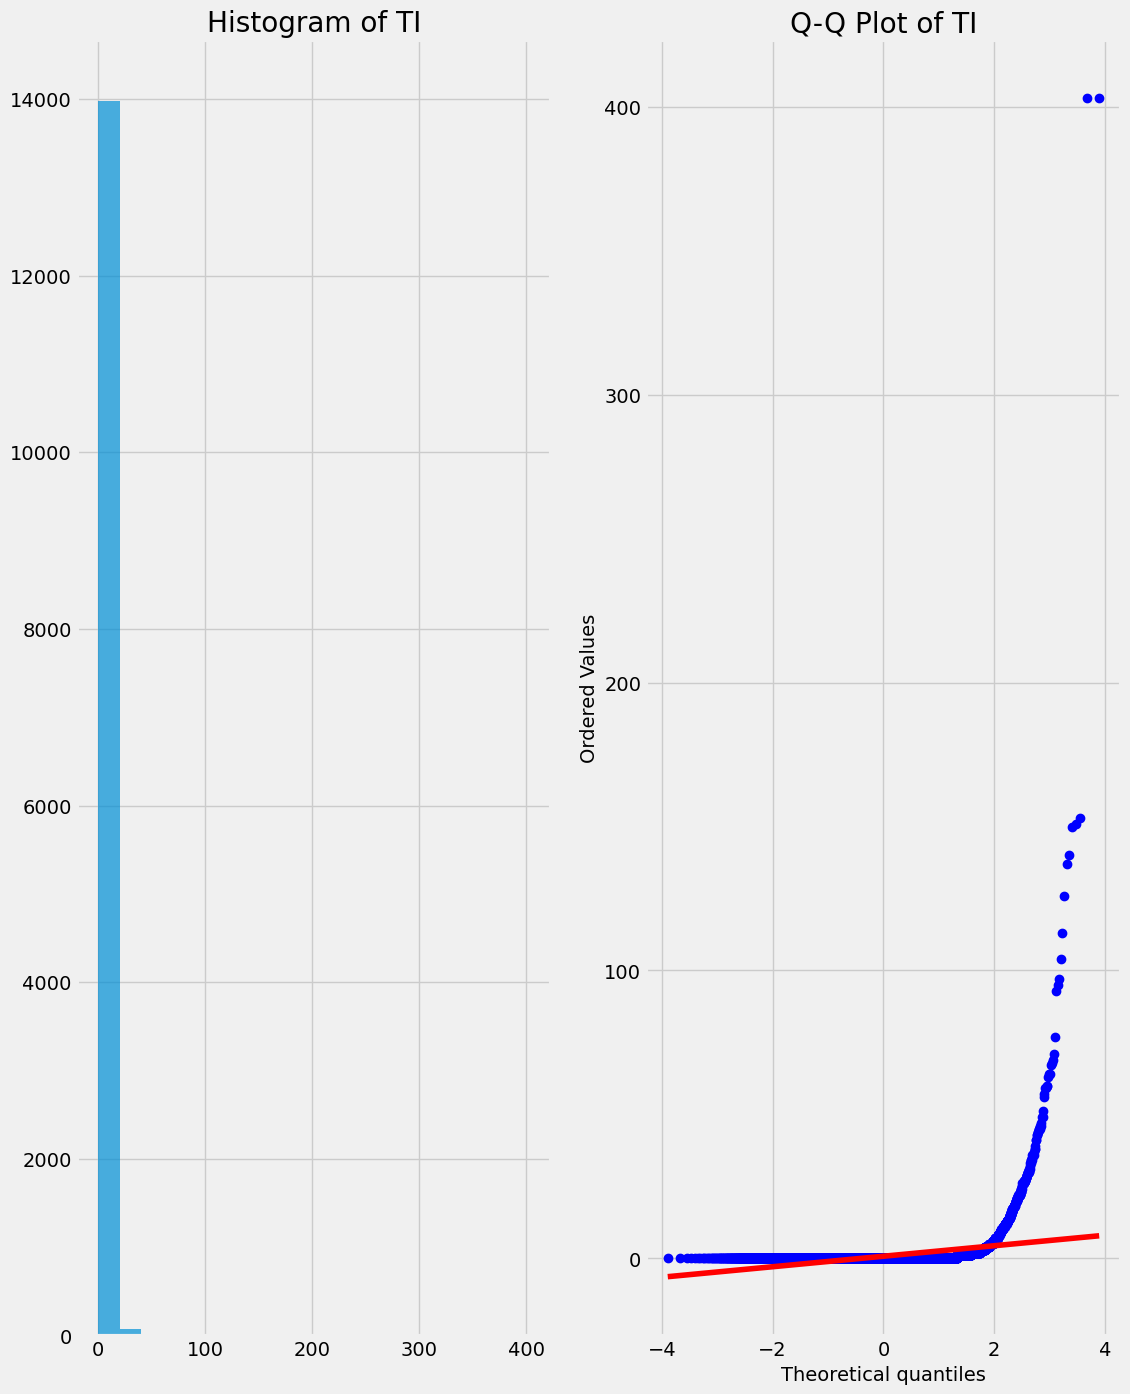

<Figure size 640x480 with 0 Axes>

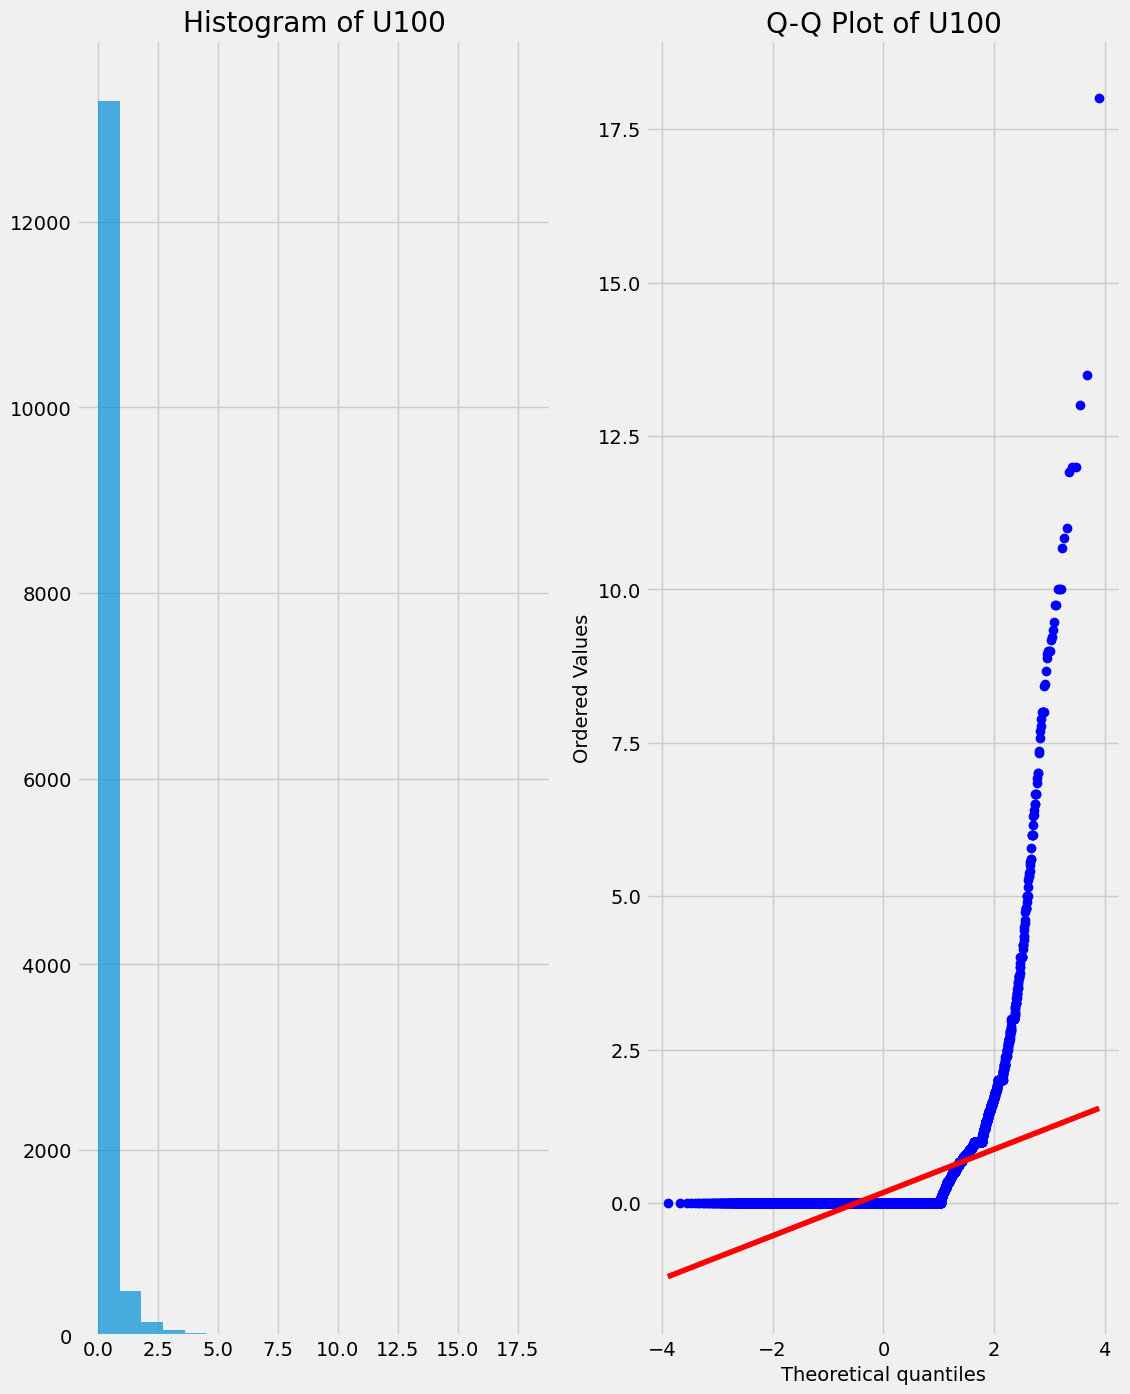

<Figure size 640x480 with 0 Axes>

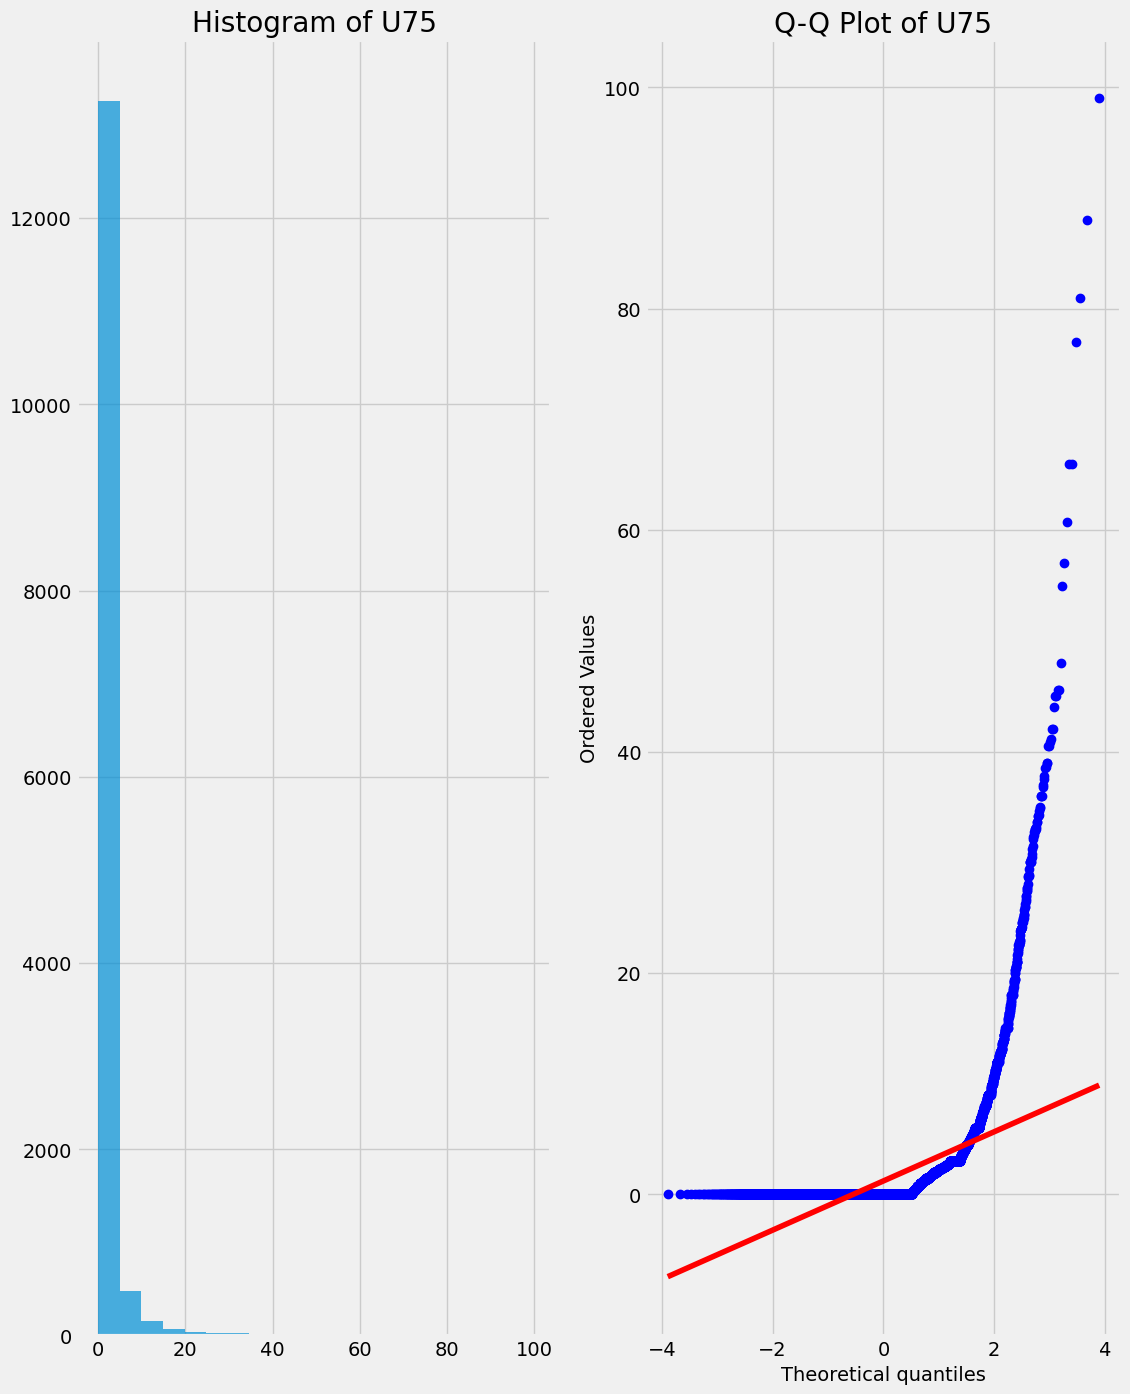

<Figure size 640x480 with 0 Axes>

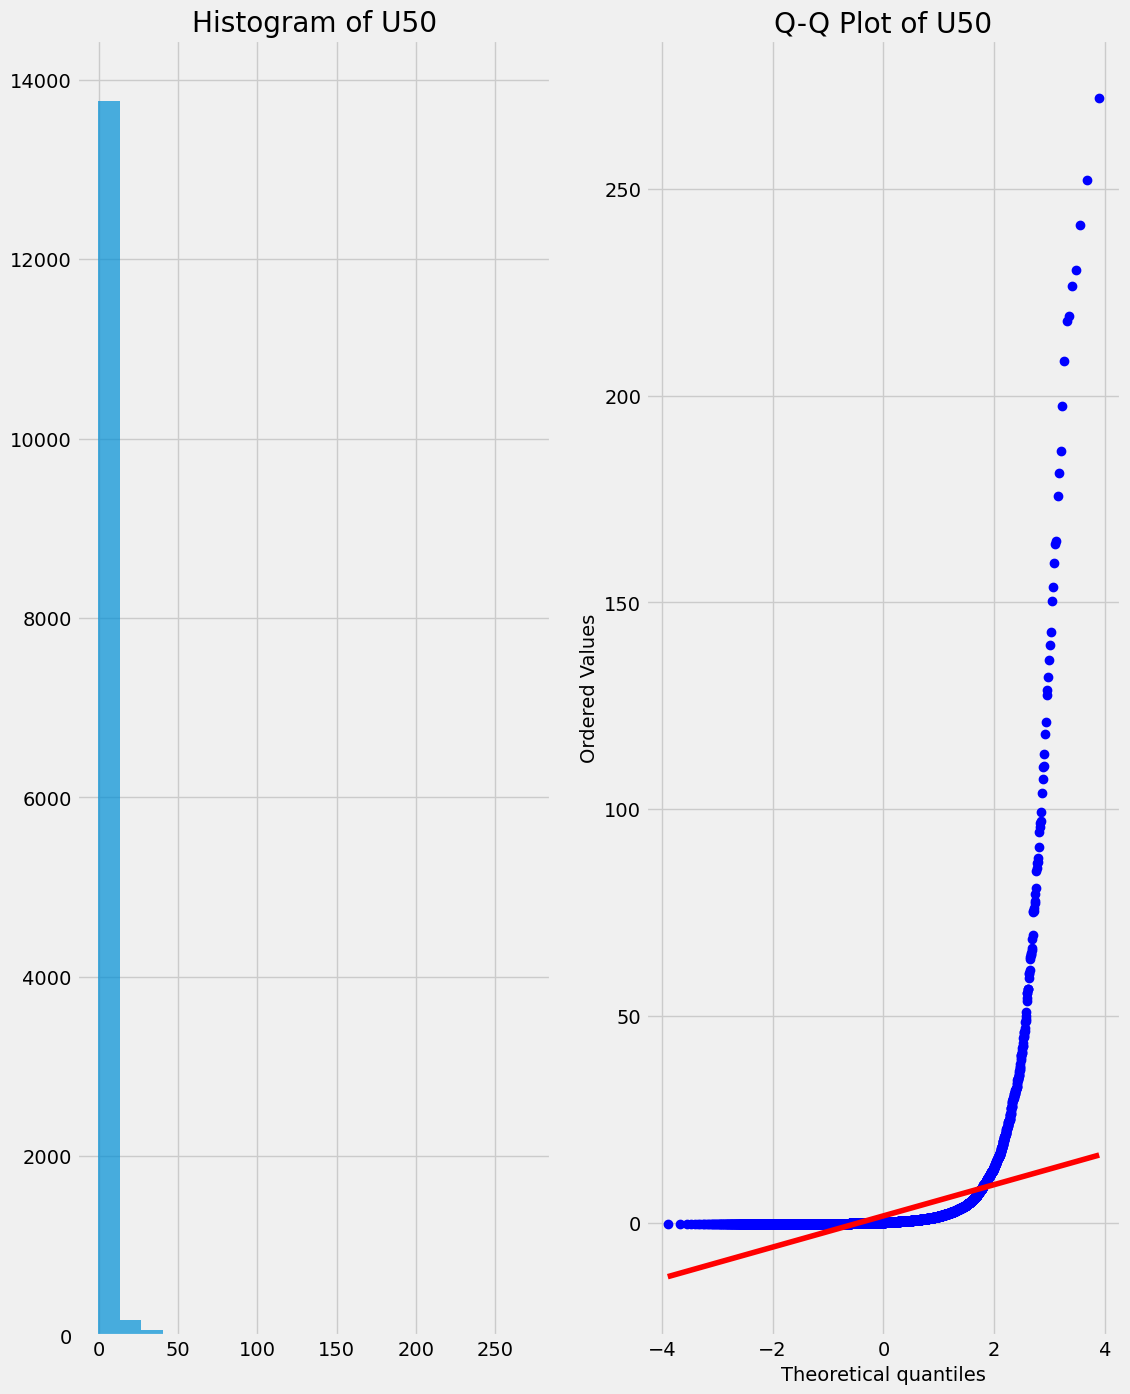

<Figure size 640x480 with 0 Axes>

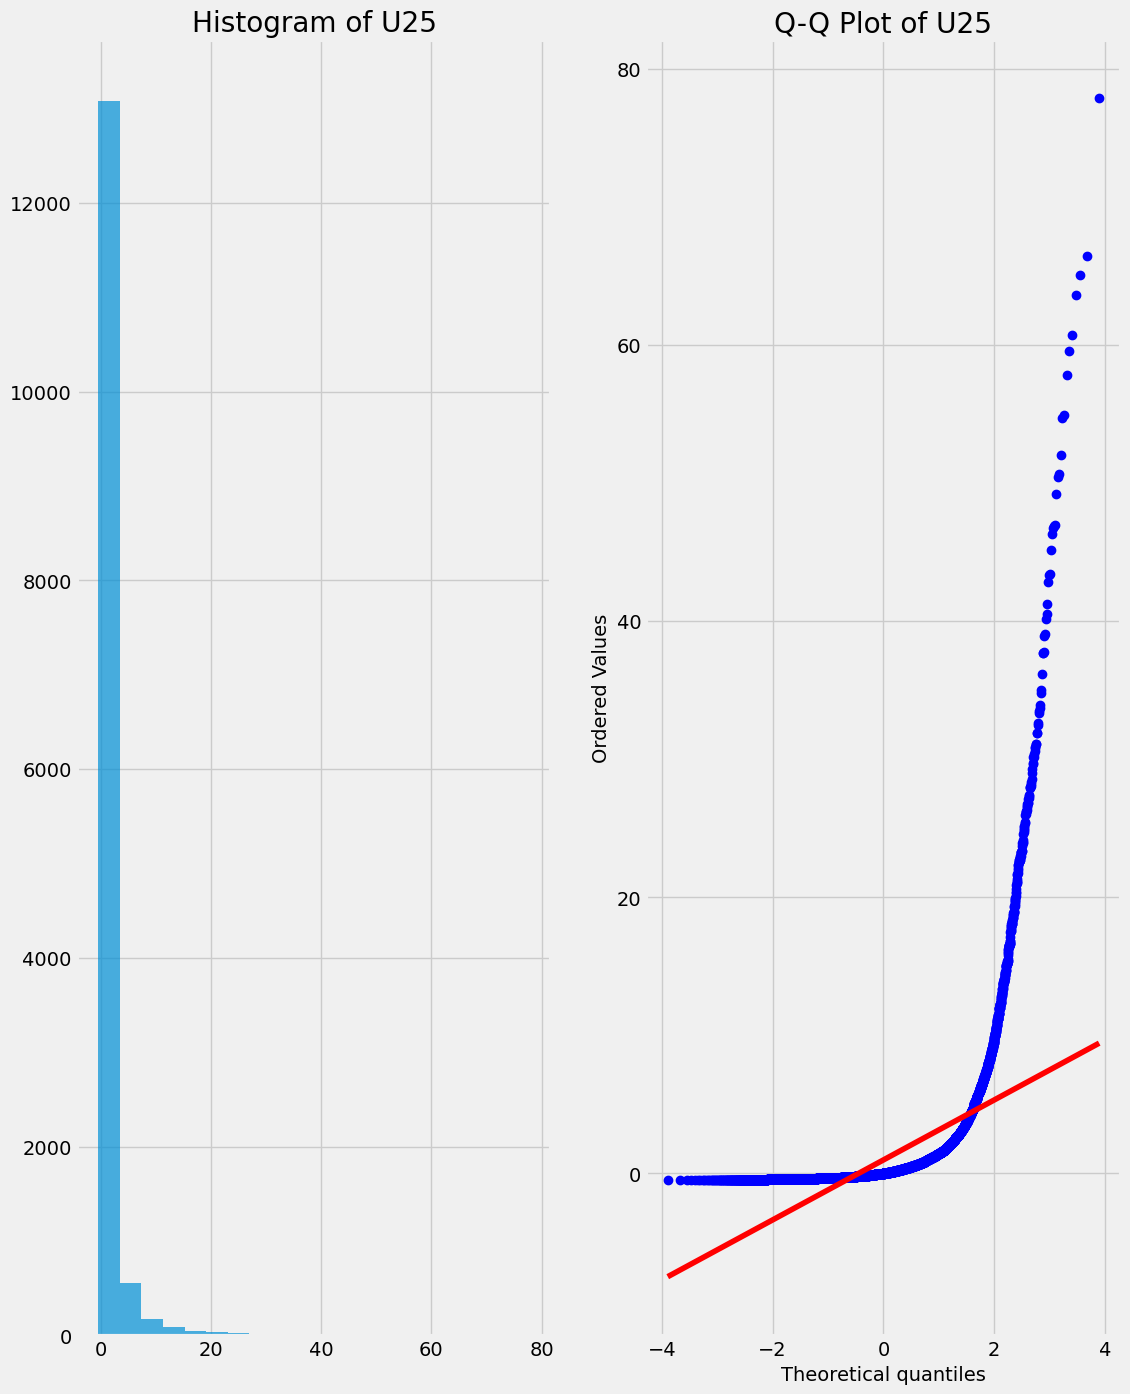

<Figure size 640x480 with 0 Axes>

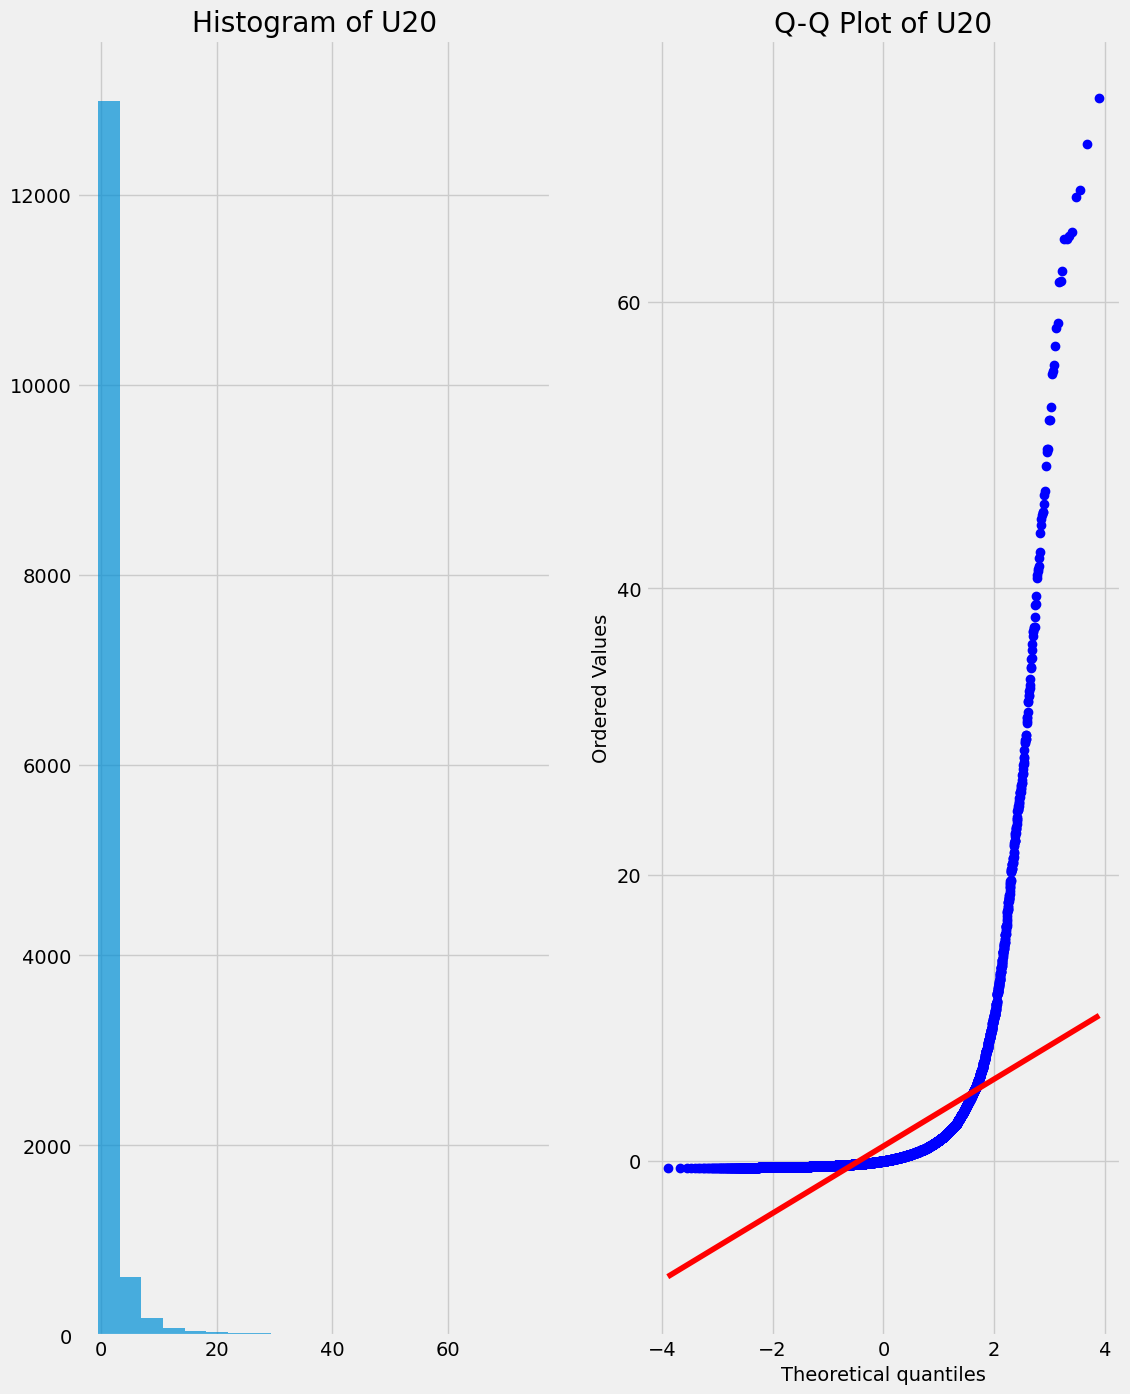

<Figure size 640x480 with 0 Axes>

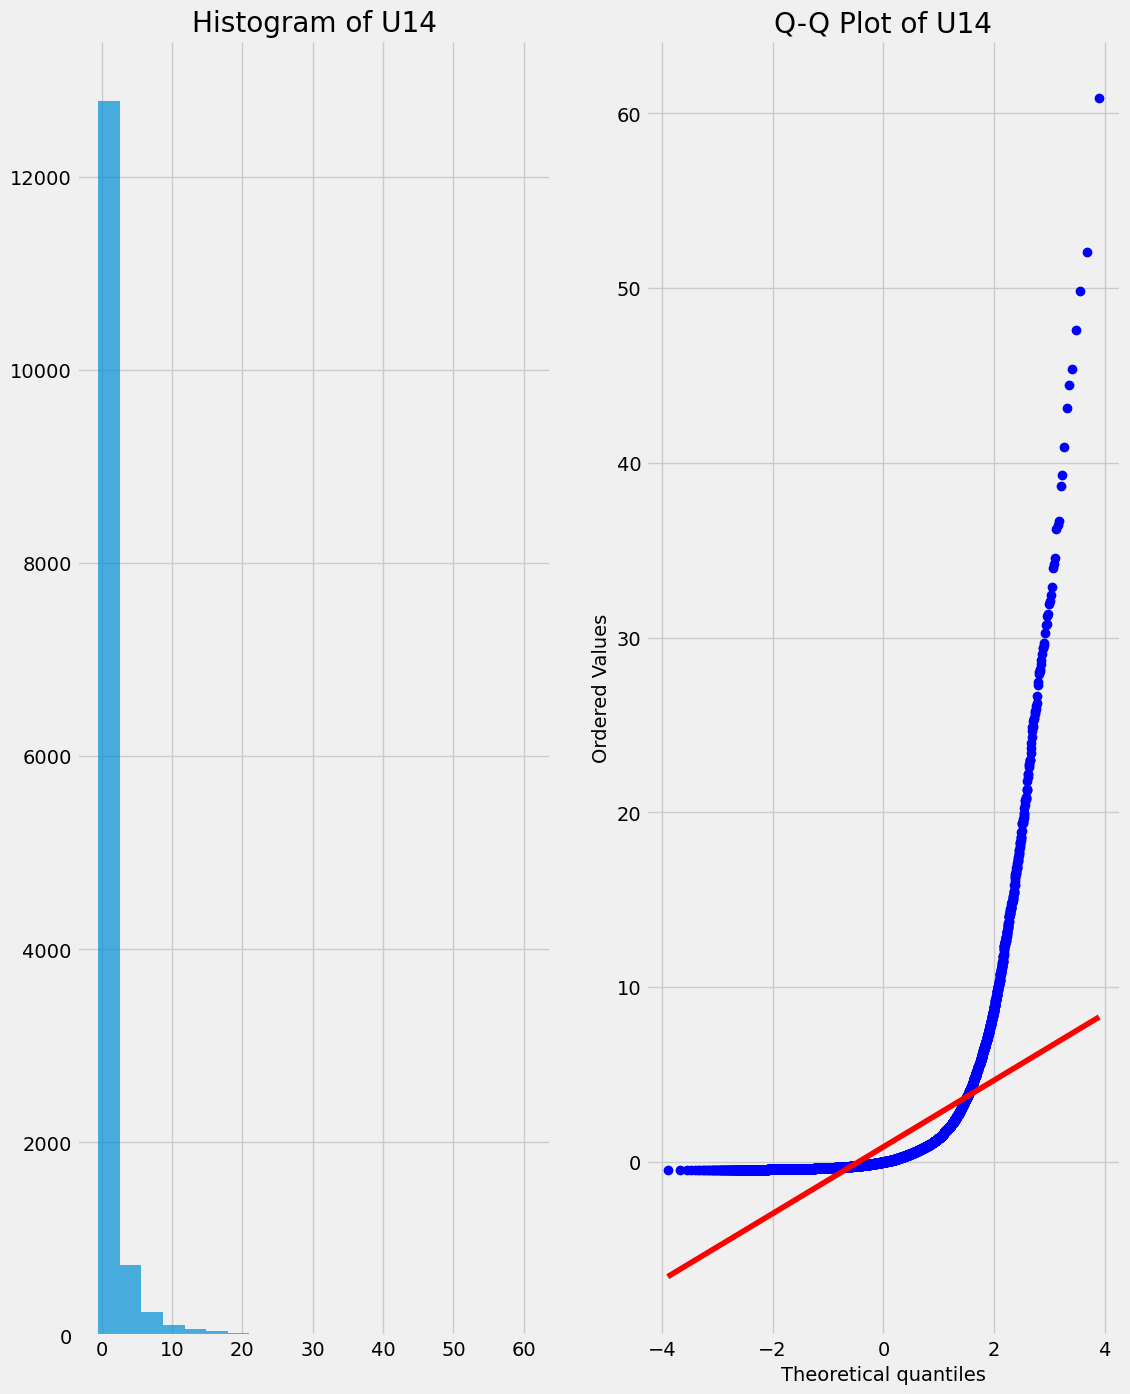

<Figure size 640x480 with 0 Axes>

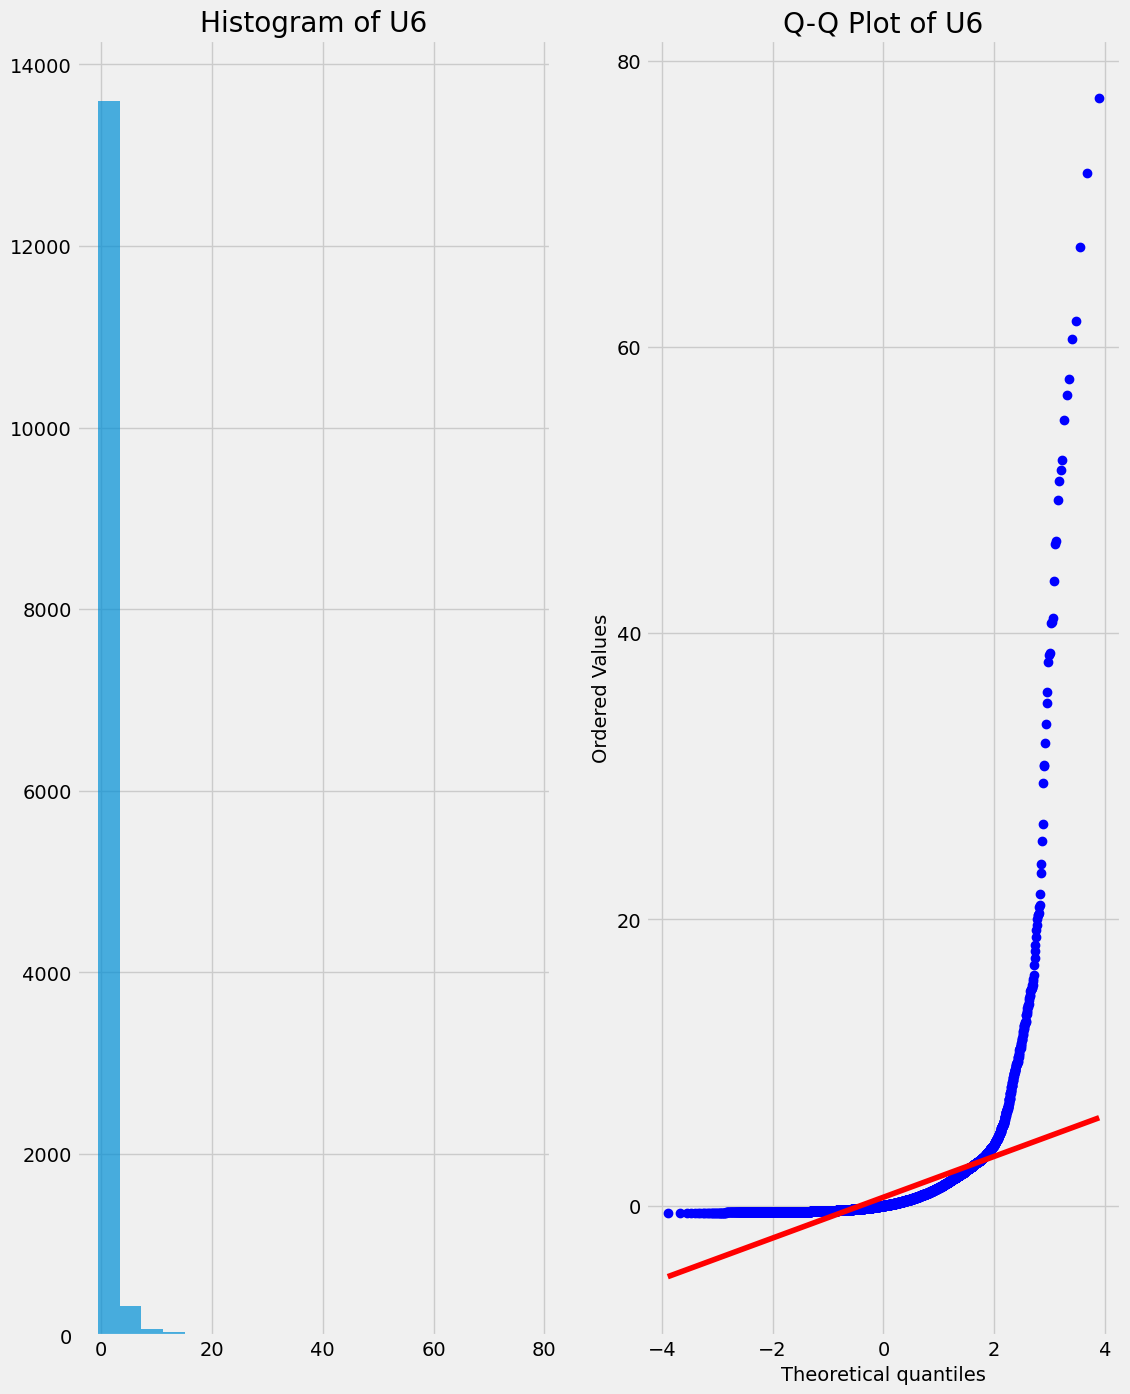

<Figure size 640x480 with 0 Axes>

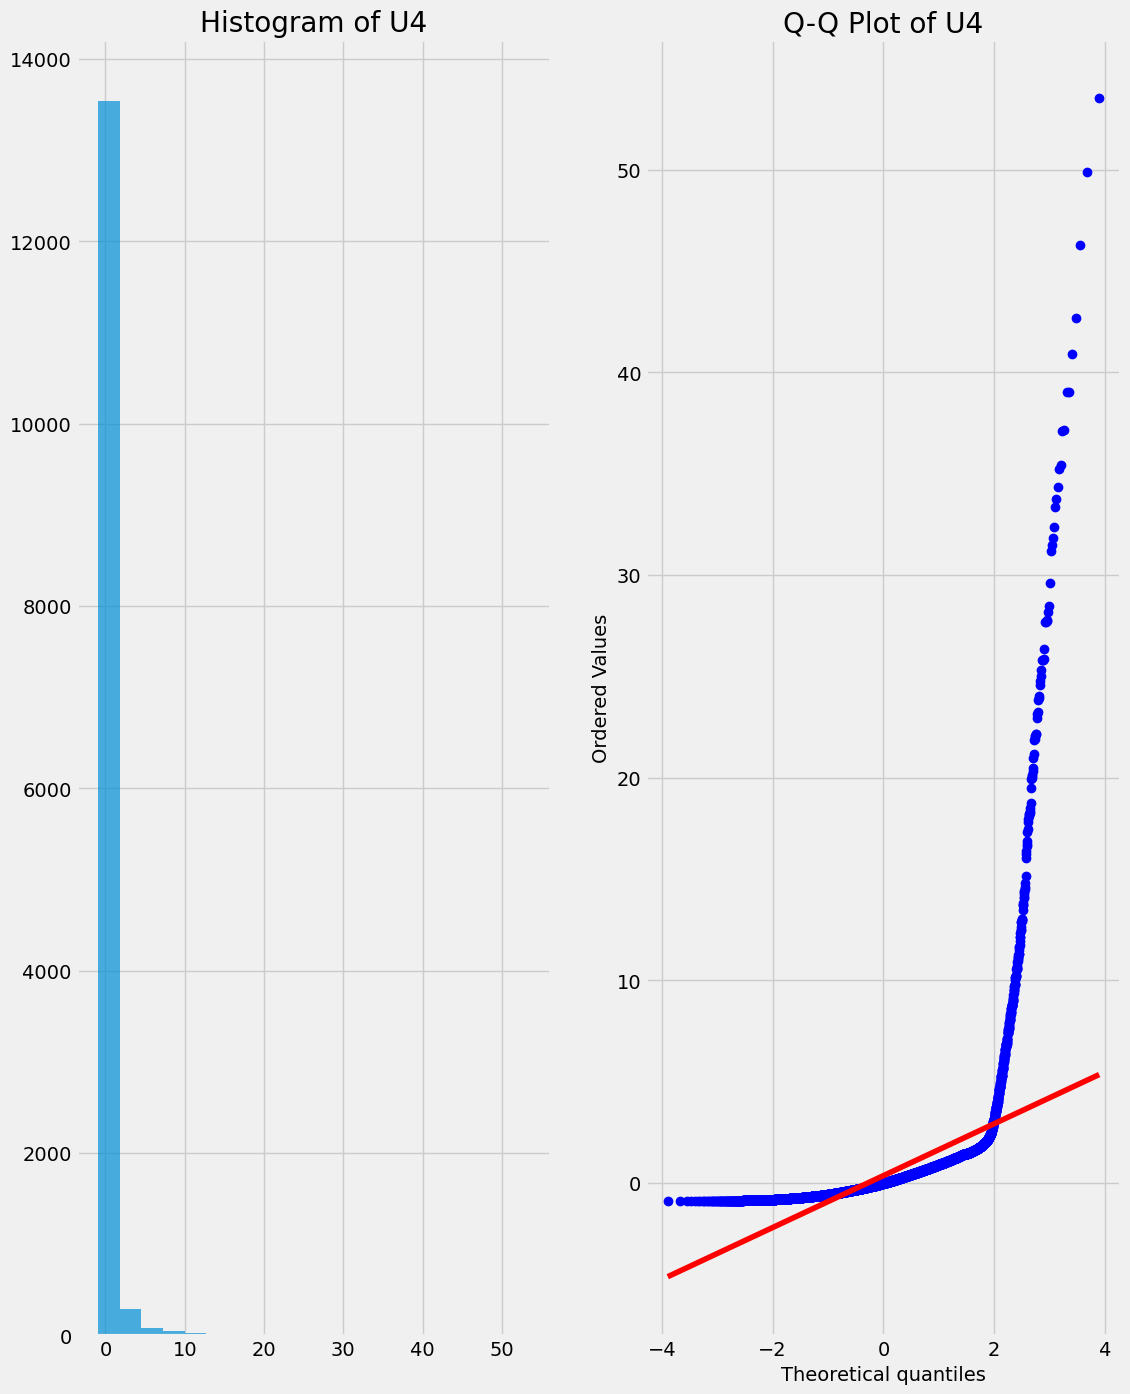

<Figure size 640x480 with 0 Axes>

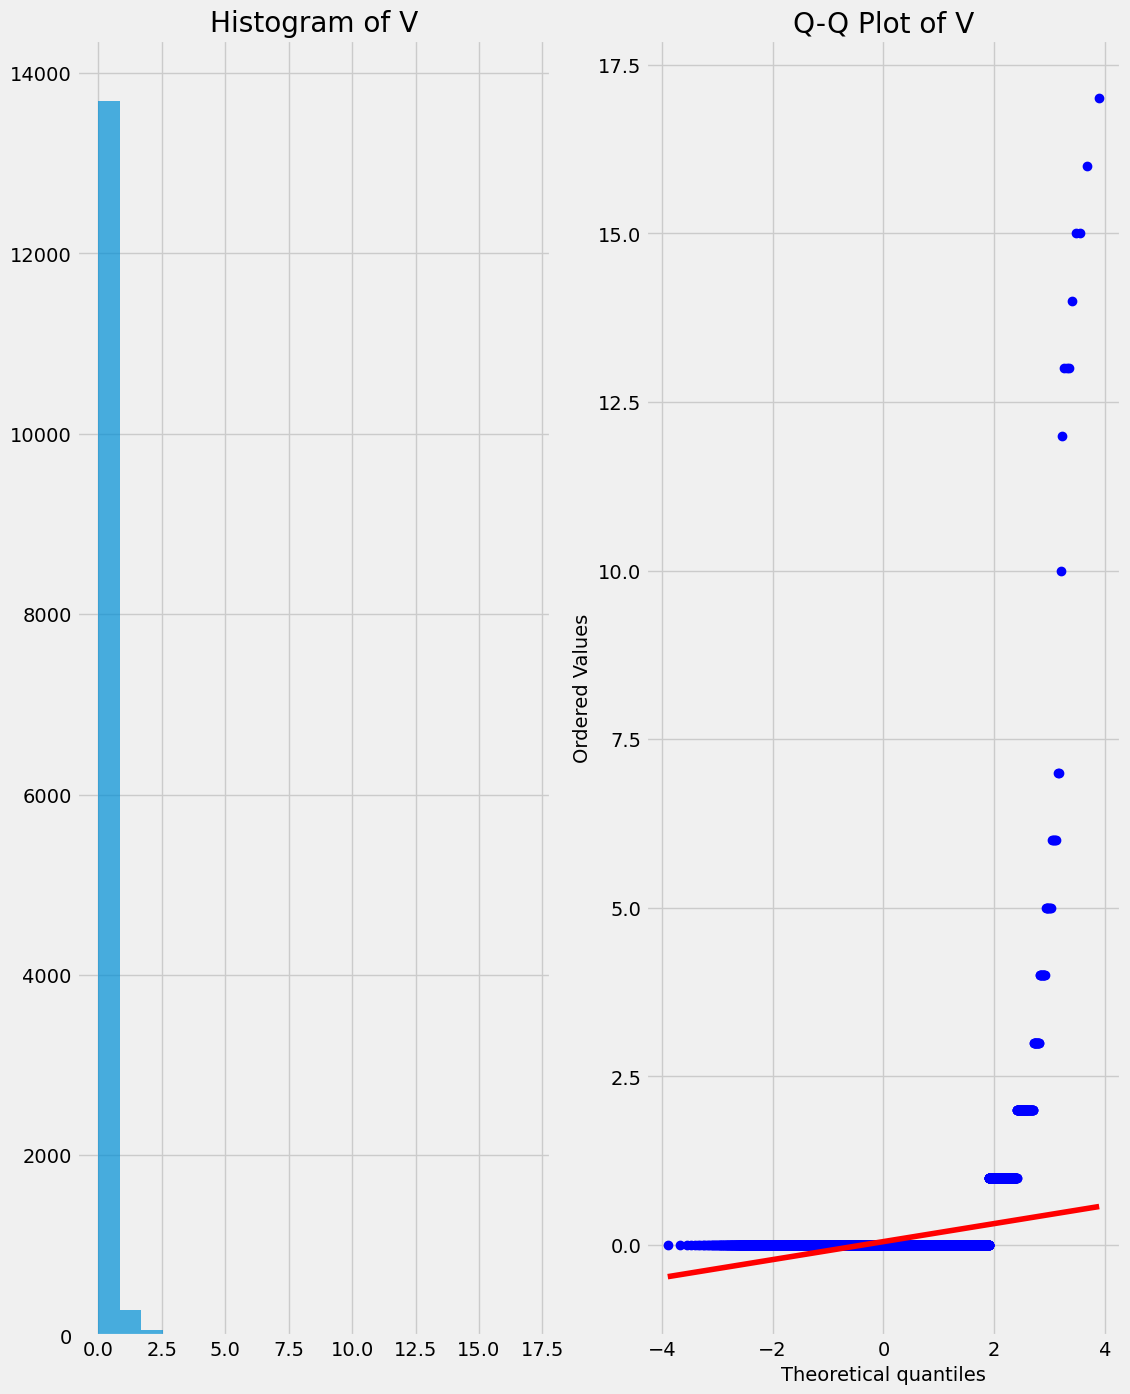

<Figure size 640x480 with 0 Axes>

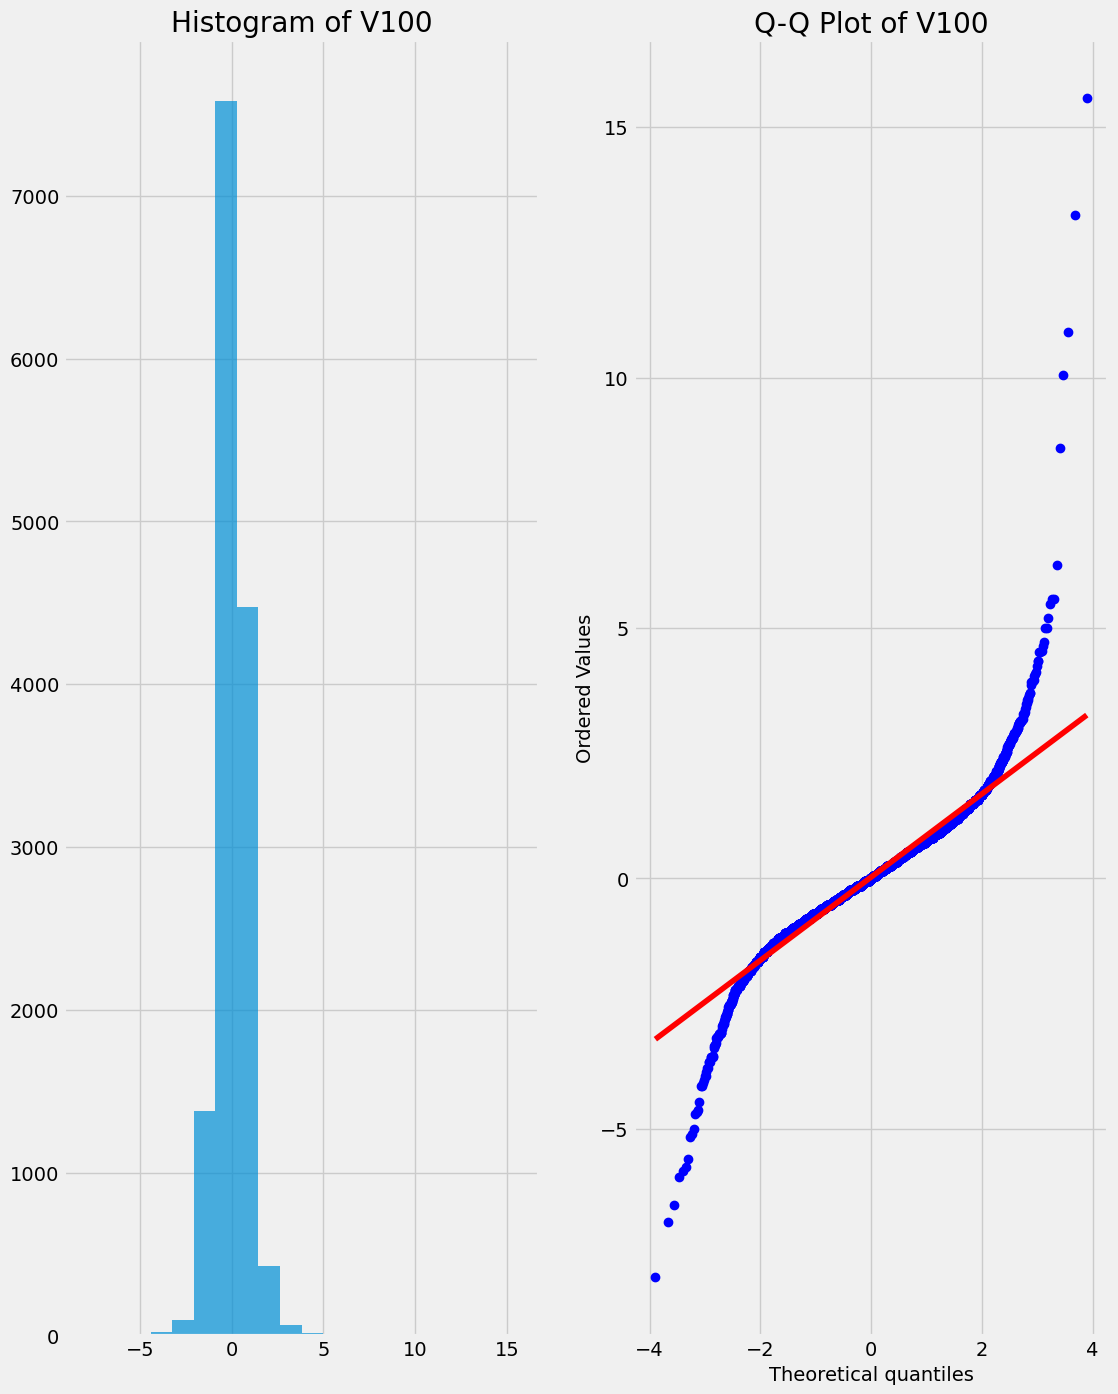

<Figure size 640x480 with 0 Axes>

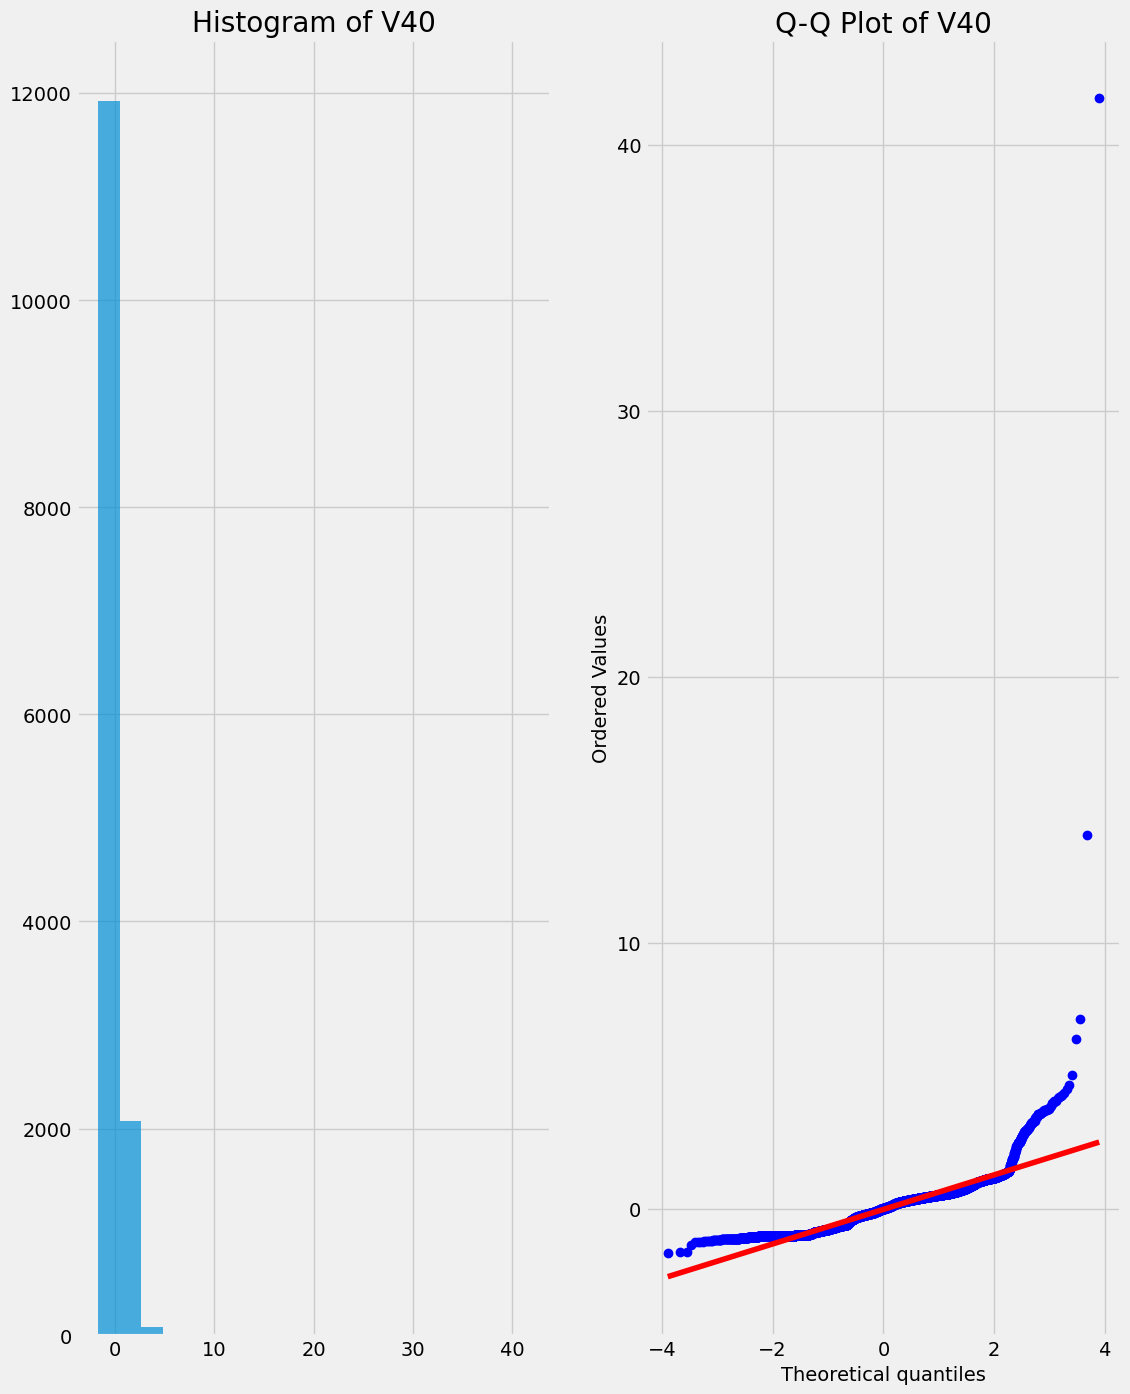

<Figure size 640x480 with 0 Axes>

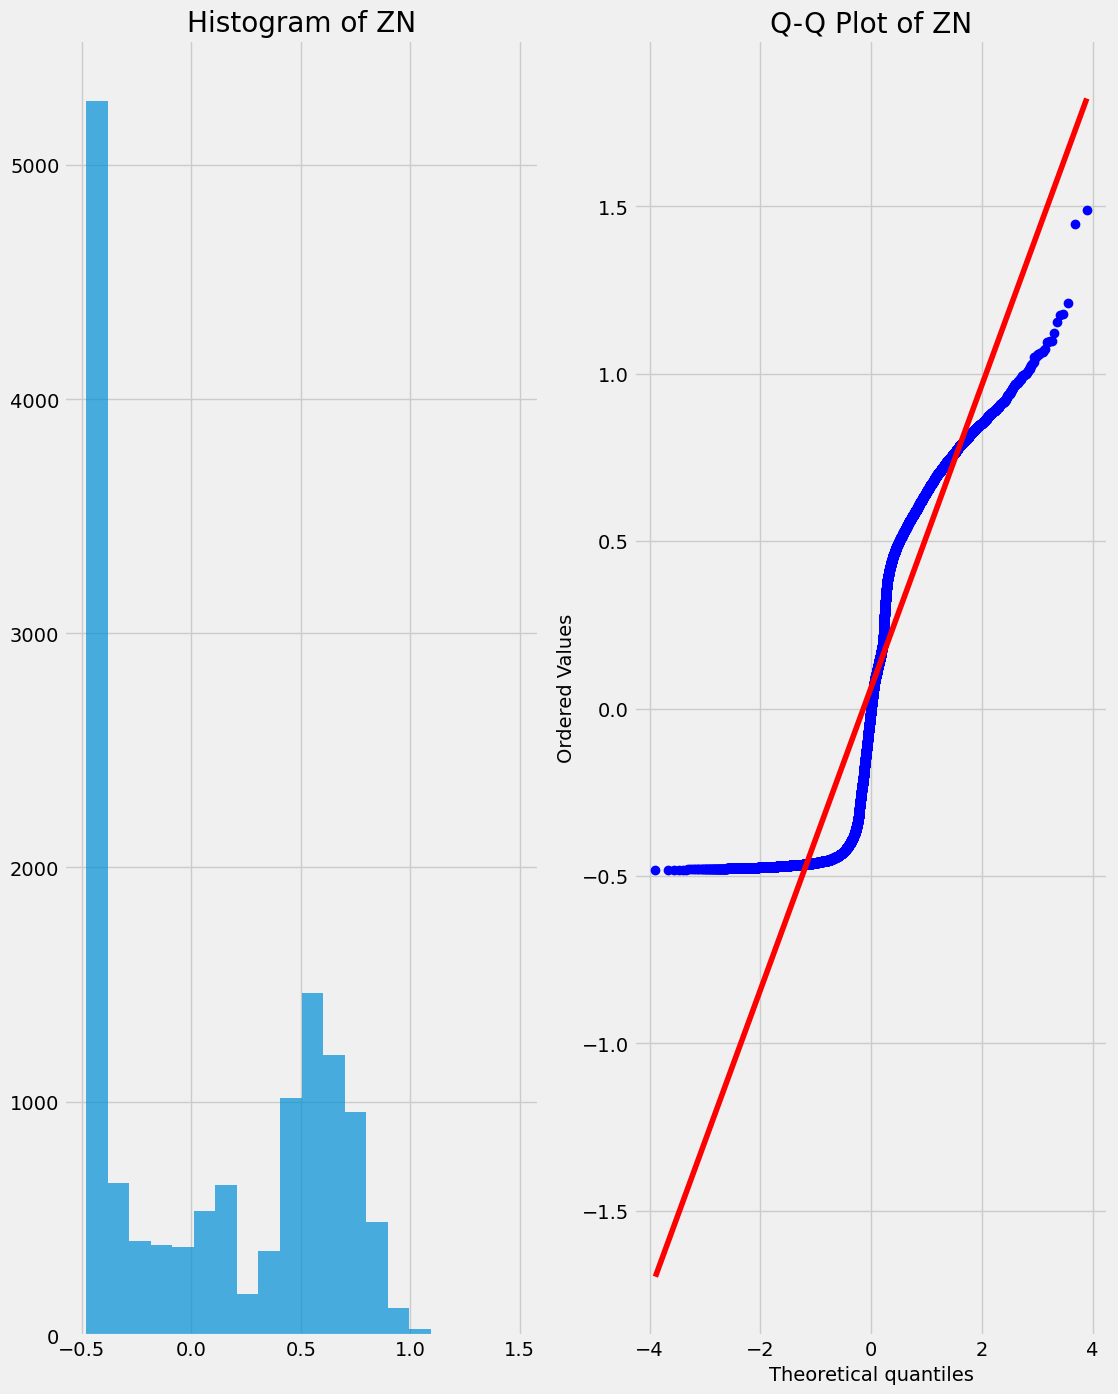

<Figure size 640x480 with 0 Axes>

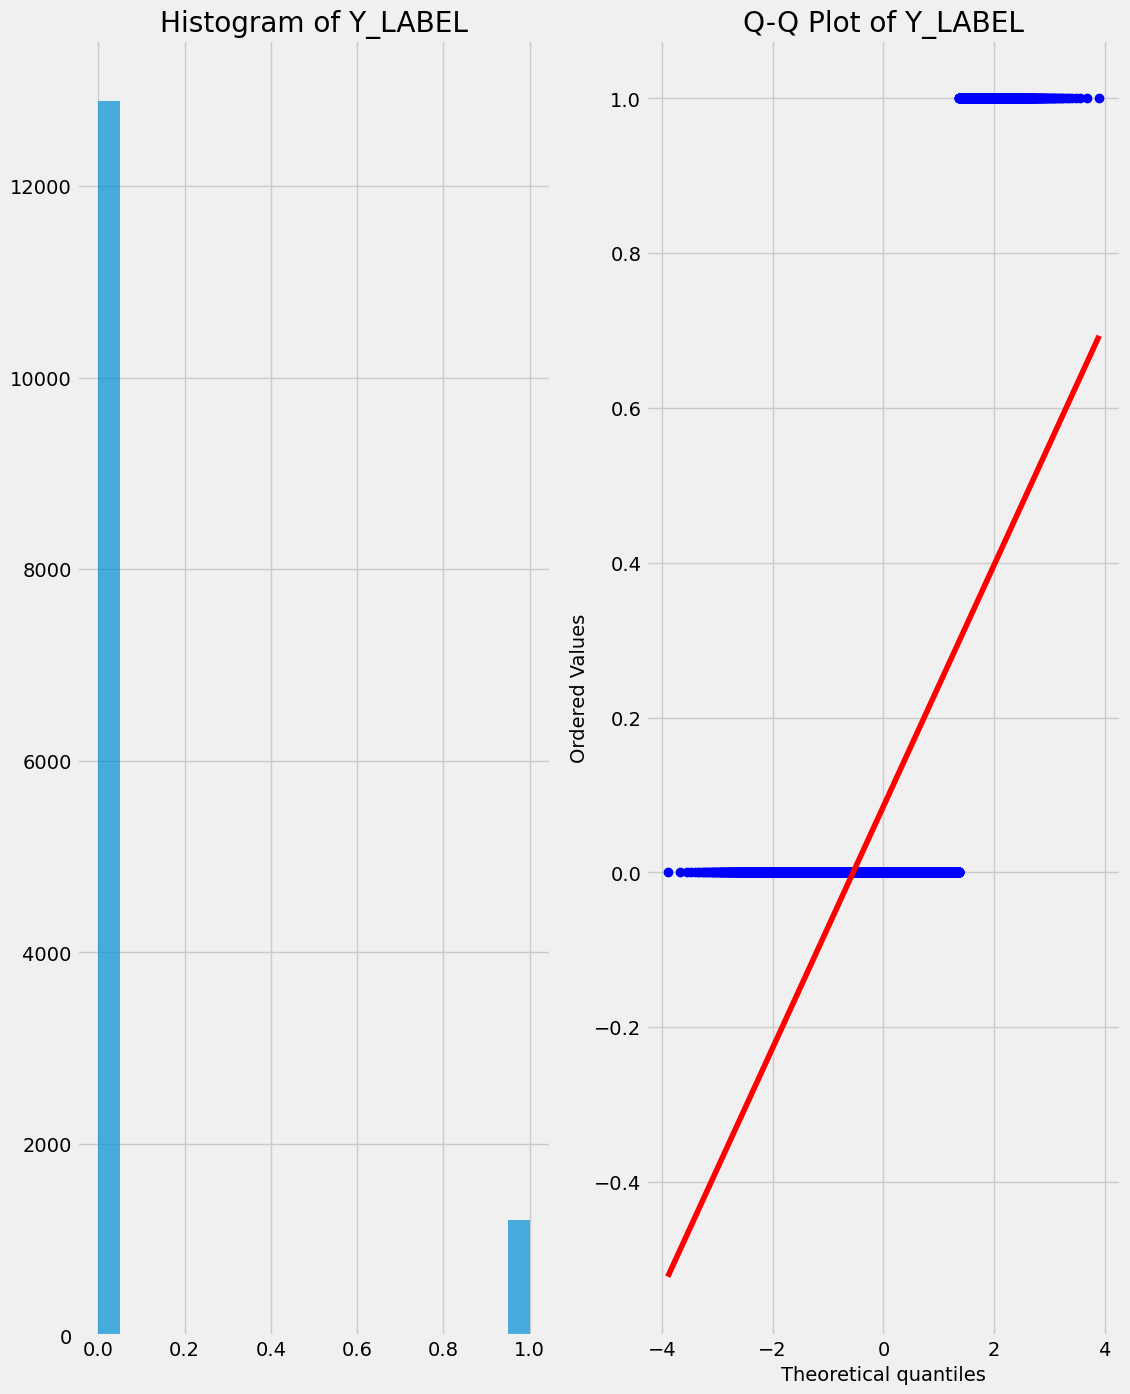

<Figure size 640x480 with 0 Axes>

In [38]:
# 각 피처에 대한 히스토그램과 Q-Q 플롯 그리기
import scipy.stats as stats
for column in train.columns:
    plt.figure(figsize=(12, 16))

    # 히스토그램
    plt.subplot(1, 2, 1)
    train[column].hist(bins=20, alpha=0.7)
    plt.title(f'Histogram of {column}')

    # Q-Q 플롯
    plt.subplot(1, 2, 2)
    stats.probplot(train[column], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {column}')

    plt.show()
    
    # 그래프 저장
    plt.savefig(f'{column}_histogram_qqplot.png')
    